In [124]:
import numpy as np
from numpy import trapz
import matplotlib.pyplot as plt
from io import StringIO
import re
import pymatgen as mg
import tensorflow as tf
import random
import os
from pymatgen.core.periodic_table import Element
import json
import linecache
from pymatgen.core import Composition
import scipy
from scipy.stats import *
%autosave 60

Autosaving every 60 seconds


In [125]:
def balanced_frac(materials, ox_dict):
    balanced = []
    for material in materials:
        try:
            ox_guesses = list(Composition(material).oxi_state_guesses(oxi_states_override=ox_dict))
            if (len(ox_guesses) > 0):
                for j in range(len(ox_guesses)):
                    success=0
                    for key in (ox_guesses[j]):
                        coeff=(ox_guesses[j][key])
                        if(coeff.is_integer()):
                            success=success+1
                        else:
                            continue
                    if(success==len(ox_guesses[j])):
                        #print(ox_guesses[j])
                        return(['True', ox_guesses[j]])
            if(len(Composition(material))==1):
                return(['True','0'])
            else:
                balanced.append(0)
            #print(str(material), len(material))
        except:
            balanced.append(0)
    return(['False', 'None'])

def balanced_frac2(materials, ox_dict):
    balanced=[]
    for material in materials:
        try:
            ox_guesses = list(Composition(material).oxi_state_guesses(oxi_states_override=common_ox_dict))
            if (len(ox_guesses) > 0):
                for j in range(len(ox_guesses)):
                    success=0
                    for key in (ox_guesses[j]):
                        coeff=(ox_guesses[j][key])
                        if(coeff.is_integer()):
                            success=success+1
                        else:
                            continue
                    if(success==len(ox_guesses[j])):
                        #print(ox_guesses[j])
                        balanced.append([material,'True', ox_guesses[j]])
                    else:
                        balanced.append([material,'False','0'])
            elif(len(Composition(material))==1):
                balanced.append([material,'True','0'])
            else:
                balanced.append([material,'False','0'])
        except:
            balanced.append([material,'False','0'])
    return(balanced)

def get_weighted_F1(TP,FP,TN,FN,num_positive,num_negative):
    num_positive_class=num_positive/(num_positive+num_negative)
    num_negative_class=num_negative/(num_positive+num_negative)
    pos_prec=TP/(TP+FP)
    pos_rec=TP/(TP+FN)
    neg_prec=TN/(TN+FN)
    neg_rec=TN/(TN+FP)
    F1_pos=2*(pos_prec*pos_rec)/(pos_prec+pos_rec)
    F1_neg=2*(neg_prec*neg_rec)/(neg_prec+neg_rec)
    F1_weighted=(num_positive_class*F1_pos) + (num_negative_class*F1_neg)
    return(F1_weighted)

def get_batch(batch_size, neg_positive_ratio, use_semi_weights, model_name, seed=False, seed_value=0):
    def random_lines(filename, file_size, num_samples):
        idxs = random.sample(range(1,file_size), num_samples)
        return ([linecache.getline(filename, i) for i in idxs], idxs)
    if(seed):
        random.seed(seed_value)
        np.random.seed(seed_value)
    else:
        random.seed()
        np.random.seed()
    num_positive_examples=int(np.floor(batch_size*(1/(1+neg_positive_ratio))))
    num_negative_examples=batch_size-num_positive_examples
    noTr_positives=48200 #number positive examples in train set
    noTr_negatives=noTr_positives*neg_positive_ratio #no. negatives examples in train set
    noTr = noTr_positives + (noTr_negatives) #total size of train set
    #only sample from first 90% of dataset; shuffle first
    data1=[]
    pulled_lines1,idxs1=random_lines('icsd_full_data_unique_no_frac_no_penta_2020.txt', noTr_positives,num_positive_examples)
    for line in pulled_lines1:
        data1.append(line.replace('\n',''))
    data0=[]
    pulled_lines0,idxs0=random_lines('standard_neg_ex_tr_val_v5_balanced_shuffled.txt', noTr_negatives, num_negative_examples)
    for line in pulled_lines0:
        data0.append(line.replace('\n',''))
    #do consistent shuffling once examples have been chosen
    random.seed(3)
    np.random.seed(3)
    #shuffle the positive and negative examples with themselves
    negative_indices=list(range(0,len(data0)))
    random.shuffle(negative_indices)
    positive_indices=list(range(0,len(data1)))
    random.shuffle(positive_indices)
    data0=np.array(data0)
    data1=np.array(data1)
    idxs0=np.array(idxs0)
    idxs1=np.array(idxs1)
    data0=data0[negative_indices]
    data1=data1[positive_indices]
    featmat0=get_features(data0)
    featmat1=get_features(data1)
    idxs0=idxs0[negative_indices]
    idxs1=idxs1[positive_indices]
    #get labels
    labs = np.zeros((len(data0) + len(data1),1))
    for ind,ent in enumerate(data1):
        labs[ind,0] = 1
    unique, counts = np.unique(labs, return_counts=True)
    ind0 = np.where(labs==0)[0] #indices of label=0
    ind1 = np.where(labs==1)[0] #indices of label=1
    #combine positives and negatives and shuffle
    featmat3 = np.concatenate((featmat0,featmat1)) #set legths of labels 0 and 1 to be the same in the new feature matrix featmat3
    datasorted = np.concatenate((data0,data1)) #data ordered the same as featmat3
    labs3 = np.concatenate((labs[ind0], labs[ind1]), axis=0) #labels ordered the same as featmat3
    idxs_full=np.concatenate((idxs0,idxs1))
    noS = len(featmat3)
    ind = list(range(0,noS)) #training set index
    random.shuffle(ind) #shuffle training set index
    #indB = list(range(0,noTr_subset)) #used later for batch
    labs3 = np.column_stack((labs3,np.abs(labs3-1)))
    xtr_batch = featmat3[ind[0:],:]
    ytr_batch = labs3[ind[0:],:]
    data_batch=datasorted[ind[0:]]
    idxs_full=idxs_full[ind[0:]]
    #all weights stuff here
    weights_full=[]
    if(use_semi_weights):
        weights1=[]
        file=open('semi_weights_testing_pos_20M' + model_name + '.txt','r')
        content=file.readlines()
        weights1=[]
        for i in idxs1:
            weights1.append(float(content[i-1].split()[1]))
        file.close()
        weights0=[]
        file=open('semi_weights_testing_neg_20M' + model_name + '.txt','r')
        content=file.readlines()
        for i in idxs0:
            weights0.append(float(content[i-1].split()[1]))
        file.close()
        weights0=np.array(weights0)
        weights1=np.array(weights1)
        weights0=weights0[negative_indices]
        weights1=weights1[positive_indices]
        weights_full=np.concatenate((weights0,weights1))
        weights_full=weights_full[ind[0:]]
    else:
        weights_full=np.ones(len(idxs_full))
    return(xtr_batch, ytr_batch, data_batch, weights_full, idxs_full)

def get_batch_val(neg_positive_ratio):
    random.seed(3)
    np.random.seed(3)
    noTr_positives=48200 #number positive examples in train set
    noTr_negatives_start=noTr_positives*neg_positive_ratio
    noTr_negatives=noTr_positives*neg_positive_ratio #no. negatives examples in train set
    noTr = noTr_positives + (noTr_negatives) #total size of train set
    #only sample from first 90% of dataset; shuffle first
    data1=[]
    f=open('icsd_full_data_unique_no_frac_no_penta_2020.txt')
    i=0
    for line in f:
        if(i>noTr_positives and i<noTr_positives*1.05):
            data1.append(line.replace('\n',''))
        i+=1
    f.close()
    data0=[]
    f=open('standard_neg_ex_tr_val_v5_balanced_shuffled.txt')
    i=0
    for line in f:
        if(i>noTr_negatives_start and i<noTr_negatives_start + (noTr_negatives*0.05)):
            data0.append(line.replace('\n',''))
        i+=1
    f.close() 
    #shuffle the positive and negative examples with themselves
    negative_indices=list(range(0,len(data0)))
    random.shuffle(negative_indices)
    positive_indices=list(range(0,len(data1)))
    random.shuffle(positive_indices)
    data0=np.array(data0)
    data1=np.array(data1)
    data0=data0[negative_indices]
    data1=data1[positive_indices]
    featmat0=get_features(data0)
    featmat1=get_features(data1)
    #get labels
    labs = np.zeros((len(data0) + len(data1),1))
    for ind,ent in enumerate(data1):
        labs[ind,0] = 1
    unique, counts = np.unique(labs, return_counts=True)
    ind0 = np.where(labs==0)[0] #indices of label=0
    ind1 = np.where(labs==1)[0] #indices of label=1
    #print(len(ind0),len(ind1))
    #combine positives and negatives and shuffle
    featmat3 = np.concatenate((featmat0,featmat1)) #set legths of labels 0 and 1 to be the same in the new feature matrix featmat3
    datasorted = np.concatenate((data0,data1)) #data ordered the same as featmat3
    labs3 = np.concatenate((labs[ind0], labs[ind1]), axis=0) #labels ordered the same as featmat3
    noS = len(featmat3)
    ind = list(range(0,noS)) #training set index
    random.shuffle(ind) #shuffle training set index
    labs3 = np.column_stack((labs3,np.abs(labs3-1)))
    xtr_batch = featmat3[ind[0:],:]
    ytr_batch = labs3[ind[0:],:]
    data_batch=datasorted[ind[0:]]
    return(xtr_batch, ytr_batch, data_batch)

def get_recall(preds,actual_values,precision=0.50):
    difference=100 #variable for how close the precision is to the desired value
    for cutoff_value in np.linspace(1,0,100):
        TP, FP, TN, FN=perf_measure(np.array(yte)[:,0],np.array(preds)[:,0], cutoff=cutoff_value)
        if(TP>0):
            cutoff_precision=TP/(TP+FP)
            difference=cutoff_precision-precision
            if(difference<0):
                return(TP/(TP+FN), cutoff_value)

def get_batch_test(neg_positive_ratio, seed=3):
    random.seed(seed)
    np.random.seed(seed)
    noTr_positives=48200 #number positive examples in train set
    noTr_negatives_start=noTr_positives*neg_positive_ratio
    noTr_negatives=noTr_positives*neg_positive_ratio #no. negatives examples in train set
    noTr = noTr_positives + (noTr_negatives) #total size of train set
    #only sample from first 90% of dataset ; shuffle first
    data1=[]
    f=open('icsd_full_data_unique_no_frac_no_penta_2020.txt')
    i=0
    for line in f:
        if(i>noTr_positives*1.05 and i<noTr_positives*1.10):
            data1.append(line.replace('\n',''))
        i+=1
    f.close()
    data0=[]
    f=open('standard_neg_ex_tr_val_v5_balanced_shuffled.txt')
    i=0
    for line in f:
        if(i>noTr_negatives_start*1.05 and i<noTr_negatives_start*1.05 + (noTr_negatives*0.05)):
            data0.append(line.replace('\n',''))
        i+=1
    f.close()
    #shuffle the positive and negative examples with themselves
    negative_indices=list(range(0,len(data0)))
    random.shuffle(negative_indices)
    positive_indices=list(range(0,len(data1)))
    random.shuffle(positive_indices)
    data0=np.array(data0)
    data1=np.array(data1)
    data0=data0[negative_indices]
    data1=data1[positive_indices]
    featmat0=get_features(data0)
    featmat1=get_features(data1)
    #get labels
    labs = np.zeros((len(data0) + len(data1),1))
    for ind,ent in enumerate(data1):
        labs[ind,0] = 1
    unique, counts = np.unique(labs, return_counts=True)
    ind0 = np.where(labs==0)[0] #indices of label=0
    ind1 = np.where(labs==1)[0] #indices of label=1
    #print(len(ind0),len(ind1))
    #combine positives and negatives and shuffle
    featmat3 = np.concatenate((featmat0,featmat1)) #set legths of labels 0 and 1 to be the same in the new feature matrix featmat3
    datasorted = np.concatenate((data0,data1)) #data ordered the same as featmat3
    labs3 = np.concatenate((labs[ind0], labs[ind1]), axis=0) #labels ordered the same as featmat3
    noS = len(featmat3)
    ind = list(range(0,noS)) #training set index
    random.shuffle(ind) #shuffle training set index
    #indB = list(range(0,noTr_subset)) #used later for batch
    labs3 = np.column_stack((labs3,np.abs(labs3-1)))
    xtr_batch = featmat3[ind[0:],:]
    ytr_batch = labs3[ind[0:],:]
    data_batch=datasorted[ind[0:]]
    return(xtr_batch, ytr_batch, data_batch)

neg_pos_ratio=25
weight_for_0 = (1 + neg_pos_ratio) / (2*neg_pos_ratio)
weight_for_1 = (1 + neg_pos_ratio) / (2*1)
def perf_measure(y_actual, y_hat, cutoff=0.5):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==1 and y_hat[i]>cutoff:
            TP += 1
        if y_hat[i]>cutoff and y_actual[i]==0:
            FP += 1
        if y_actual[i]==0 and y_hat[i]<cutoff:
            TN += 1
        if y_hat[i]<cutoff and y_actual[i]==1:
            FN += 1

    return(TP, FP, TN, FN)

#charge balancing over time
#full_ox_dict = {'H': [-1, 0, 1], 'He': [0], 'Li': [0, 1], 'Be': [0, 1, 2], 'B': [-5, -1, 0, 1, 2, 3], 'C': [-4, -3, -2, -1, 0, 1, 2, 3, 4], 'N': [-3, -2, -1, 0, 1, 2, 3, 4, 5], 'O': [-2, -1, 0, 1, 2], 'F': [-1, 0], 'Ne': [0], 'Na': [-1, 0, 1], 'Mg': [0, 1, 2], 'Al': [-2, -1, 0, 1, 2, 3], 'Si': [-4, -3, -2, -1, 0, 1, 2, 3, 4], 'P': [-3, -2, -1, 0, 1, 2, 3, 4, 5], 'S': [-2, -1, 0, 1, 2, 3, 4, 5, 6], 'Cl': [-1, 0, 1, 2, 3, 4, 5, 6, 7], 'Ar': [0], 'K': [-1, 0, 1], 'Ca': [0, 1, 2], 'Sc': [0, 1, 2, 3], 'Ti': [-2, -1, 0, 1, 2, 3, 4], 'V': [-3, -1, 0, 1, 2, 3, 4, 5], 'Cr': [-4, -2, -1, 0, 1, 2, 3, 4, 5, 6], 'Mn': [-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7], 'Fe': [-4, -2, -1, 0, 1, 2, 3, 4, 5, 6], 'Co': [-3, -1, 0, 1, 2, 3, 4, 5], 'Ni': [-2, -1, 0, 1, 2, 3, 4], 'Cu': [-2, 0, 1, 2, 3, 4], 'Zn': [-2, 0, 1, 2], 'Ga': [-5, -4, -2, -1, 0, 1, 2, 3], 'Ge': [-4, -3, -2, -1, 0, 1, 2, 3, 4], 'As': [-3, -2, -1, 0, 1, 2, 3, 4, 5], 'Se': [-2, -1, 0, 1, 2, 3, 4, 5, 6], 'Br': [-1, 0, 1, 3, 4, 5, 7], 'Kr': [0, 2], 'Rb': [-1, 0, 1], 'Sr': [0, 1, 2], 'Y': [0, 1, 2, 3], 'Zr': [-2, 0, 1, 2, 3, 4], 'Nb': [-3, -1, 0, 1, 2, 3, 4, 5], 'Mo': [-4, -2, -1, 0, 1, 2, 3, 4, 5, 6], 'Tc': [-3, -1, 0, 1, 2, 3, 4, 5, 6, 7], 'Ru': [-4, -2, 0, 1, 2, 3, 4, 5, 6, 7, 8], 'Rh': [-3, -1, 0, 1, 2, 3, 4, 5, 6], 'Pd': [0, 1, 2, 3, 4, 5, 6], 'Ag': [-2, -1, 0, 1, 2, 3, 4], 'Cd': [-2, 0, 1, 2], 'In': [-5, -2, -1, 0, 1, 2, 3], 'Sn': [-4, -3, -2, -1, 0, 1, 2, 3, 4], 'Sb': [-3, -2, -1, 0, 1, 2, 3, 4, 5], 'Te': [-2, -1, 0, 1, 2, 3, 4, 5, 6], 'I': [-1, 0, 1, 3, 4, 5, 6, 7], 'Xe': [0, 2, 4, 6, 8], 'Cs': [-1, 0, 1], 'Ba': [0, 1, 2], 'Hf': [-2, 0, 1, 2, 3, 4], 'Ta': [-3, -1, 0, 1, 2, 3, 4, 5], 'W': [-4, -2, -1, 0, 1, 2, 3, 4, 5, 6], 'Re': [-3, -1, 0, 1, 2, 3, 4, 5, 6, 7], 'Os': [-4, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8], 'Ir': [-3, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'Pt': [-3, -2, -1, 0, 1, 2, 3, 4, 5, 6], 'Au': [-3, -2, -1, 0, 1, 2, 3, 5], 'Hg': [-2, 0, 1, 2], 'Tl': [-5, -2, -1, 0, 1, 2, 3], 'Pb': [-4, -2, -1, 0, 1, 2, 3, 4], 'Bi': [-3, -2, -1, 0, 1, 2, 3, 4, 5], 'Po': [-2, 0, 2, 4, 5, 6], 'At': [-1, 0, 1, 3, 5, 7], 'Rn': [0, 2, 6], 'Fr': [0, 1], 'Ra': [0, 2], 'Rf': [0, 4], 'Db': [0, 5], 'Sg': [0, 6], 'Bh': [0, 7], 'Hs': [0, 8], 'Mt': [0], 'Ds': [0], 'Rg': [0], 'Cn': [0], 'Nh': [0], 'Fl': [0], 'Mc': [0], 'Lv': [0], 'Ts': [0], 'Og': [0], 'La': [0, 1, 2, 3], 'Ce': [0, 2, 3, 4], 'Pr': [0, 2, 3, 4], 'Nd': [0, 2, 3, 4], 'Pm': [0, 2, 3], 'Sm': [0, 2, 3], 'Eu': [0, 2, 3], 'Gd': [0, 1, 2, 3], 'Tb': [0, 1, 2, 3, 4], 'Dy': [0, 2, 3, 4], 'Ho': [0, 2, 3], 'Er': [0, 2, 3], 'Tm': [0, 2, 3], 'Yb': [0, 2, 3], 'Lu': [0, 2, 3], 'Ac': [0, 2, 3], 'Th': [0, 1, 2, 3, 4], 'Pa': [0, 2, 3, 4, 5], 'U': [0, 1, 2, 3, 4, 5, 6], 'Np': [0, 2, 3, 4, 5, 6, 7], 'Pu': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'Am': [0, 2, 3, 4, 5, 6, 7, 8], 'Cm': [0, 2, 3, 4, 6], 'Bk': [0, 2, 3, 4], 'Cf': [0, 2, 3, 4], 'Es': [0, 2, 3, 4], 'Fm': [0, 2, 3], 'Md': [0, 2, 3], 'No': [0, 2, 3], 'Lr': [0, 3]}
#common_ox_dict = {'H': [-1, 0, 1], 'He': [0], 'Li': [0, 1], 'Be': [0, 2], 'B': [0, 3], 'C': [-4, -3, -2, -1, 0, 1, 2, 3, 4], 'N': [-3, 0, 3, 5], 'O': [-2, 0], 'F': [-1, 0], 'Ne': [0], 'Na': [0, 1], 'Mg': [0, 2], 'Al': [0, 3], 'Si': [-4, 0, 4], 'P': [-3, 0, 3, 5], 'S': [-2, 0, 2, 4, 6], 'Cl': [-1, 0, 1, 3, 5, 7], 'Ar': [0], 'K': [0, 1], 'Ca': [0, 2], 'Sc': [0, 3], 'Ti': [0, 4], 'V': [0, 5], 'Cr': [0, 3, 6], 'Mn': [0, 2, 4, 7], 'Fe': [0, 2, 3, 6], 'Co': [0, 2, 3], 'Ni': [0, 2], 'Cu': [0, 2], 'Zn': [0, 2], 'Ga': [0, 3], 'Ge': [-4, 0, 2, 4], 'As': [-3, 0, 3, 5], 'Se': [-2, 0, 2, 4, 6], 'Br': [-1, 0, 1, 3, 5, 7], 'Kr': [0, 2], 'Rb': [0, 1], 'Sr': [0, 2], 'Y': [0, 3], 'Zr': [0, 4], 'Nb': [0, 5], 'Mo': [0, 4, 6], 'Tc': [0, 4, 7], 'Ru': [0, 2, 3, 4], 'Rh': [0, 3], 'Pd': [0, 2, 4], 'Ag': [0, 1], 'Cd': [0, 2], 'In': [0, 3], 'Sn': [-4, 0, 2, 4], 'Sb': [-3, 0, 3, 5], 'Te': [-2, 0, 2, 4, 6], 'I': [-1, 0, 1, 3, 5, 7], 'Xe': [0, 2, 4, 6], 'Cs': [0, 1], 'Ba': [0, 2], 'Hf': [0, 4], 'Ta': [0, 5], 'W': [0, 4, 6], 'Re': [0, 4], 'Os': [0, 4], 'Ir': [0, 3, 4], 'Pt': [0, 2, 4], 'Au': [0, 3], 'Hg': [0, 1, 2], 'Tl': [0, 1, 3], 'Pb': [0, 2, 4], 'Bi': [0, 3], 'Po': [-2, 0, 2, 4], 'At': [-1, 0, 1], 'Rn': [0, 2], 'Fr': [0, 1], 'Ra': [0, 2], 'Rf': [0, 4], 'Db': [0, 5], 'Sg': [0, 6], 'Bh': [0, 7], 'Hs': [0, 8], 'Mt': [0], 'Ds': [0], 'Rg': [0], 'Cn': [0], 'Nh': [0], 'Fl': [0], 'Mc': [0], 'Lv': [0], 'Ts': [0], 'Og': [0], 'La': [0, 3], 'Ce': [0, 3, 4], 'Pr': [0, 3], 'Nd': [0, 3], 'Pm': [0, 3], 'Sm': [0, 3], 'Eu': [0, 2, 3], 'Gd': [0, 3], 'Tb': [0, 3], 'Dy': [0, 3], 'Ho': [0, 3], 'Er': [0, 3], 'Tm': [0, 3], 'Yb': [0, 3], 'Lu': [0, 3], 'Ac': [0, 3], 'Th': [0, 4], 'Pa': [0, 5], 'U': [0, 4, 6], 'Np': [0, 5], 'Pu': [0, 4], 'Am': [0, 3], 'Cm': [0, 3], 'Bk': [0, 3], 'Cf': [0, 3], 'Es': [0, 3], 'Fm': [0, 3], 'Md': [0, 3], 'No': [0, 2], 'Lr': [0, 3]}
mg_common_ox_dict = {}
mg_full_ox_dict = {}
species_in_use = ['Ac', 'Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca', 'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'F', 'Fe', 'Ga', 'Gd', 'Ge', 'H', 'Hf', 'Hg', 'Ho', 'I', 'In', 'Ir', 'K', 'La', 'Li', 'Lu', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd', 'Ni', 'Np', 'O', 'Os', 'P', 'Pa', 'Pb', 'Pd', 'Pr', 'Pt', 'Pu', 'Rb', 'Re', 'Rh', 'Ru', 'S', 'Sb', 'Sc', 'Se', 'Si', 'Sm', 'Sn', 'Sr', 'Ta', 'Tb', 'Te', 'Th', 'Ti', 'Tl', 'Tm', 'U', 'V', 'W', 'Y', 'Yb', 'Zn', 'Zr']
for specie in species_in_use:
    mg_common_ox_dict[specie] = list(mg.core.periodic_table.Specie(specie).common_oxidation_states)
for specie in species_in_use:
    mg_full_ox_dict[specie] = list(mg.core.periodic_table.Specie(specie).oxidation_states)
full_ox_dict = mg_full_ox_dict
common_ox_dict = mg_common_ox_dict
full_ox_dict = {x: full_ox_dict[x] for x in full_ox_dict if x in species_in_use}
common_ox_dict = {x: common_ox_dict[x] for x in common_ox_dict if x in species_in_use}
element_names_array=['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl', 'Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn','Fr','Ra','Ac','Th','Pa','U','Np','Pu']

def load_data(data, is_charge_balanced, max_atoms=5, max_coefficient=100000):
    #takes input file (icsd_full_properties_no_frac_charges) and processes the data and applies some filters
    output_array=[]
    coeff_array=np.zeros((10000,1))
    element_names_array=['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl', 'Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn','Fr','Ra','Ac','Th','Pa','U','Np','Pu']

    for i in range(len(data)):
        try:
            comp=mg.core.composition.Composition(data[i,1])
        except:
            continue #bad formula

        if(len(mg.core.composition.Composition(data[i,1]))==1):
            continue

        truth_array=[]
        for element_name in mg.core.composition.Composition(data[i,1]).as_dict().keys():
            if(element_name not in element_names_array):
                truth_array.append('False')
        if('False' in truth_array):
            continue

        if(is_charge_balanced):
            if('True' in data[i][8]):
                if(len(mg.core.composition.Composition(data[i,1]))<max_atoms):
                    values=mg.core.composition.Composition(data[i,1]).as_dict().values()
                    for value in values:
                        coeff_array[int(value)]=coeff_array[int(value)]+1
                    large_values=[x for x in values if x>max_coefficient]
                    if(len(large_values)==0):
                        output_array.append(mg.core.composition.Composition(data[i,1]).alphabetical_formula.replace(' ', ''))
        else:
            output_array.append(mg.core.composition.Composition(data[i,1]).alphabetical_formula.replace(' ', ''))
    return(np.unique(output_array))

def get_features(data0):
    p = re.compile('[A-Z][a-z]?\d*\.?\d*')
    p3 = re.compile('[A-Z][a-z]?')
    p5 = re.compile('\d+\.?\d+|\d+')
    data0_ratio=[]
    for i in data0:
        x = i
        p2 = p.findall(x)
        temp1,temp2 = [], []
        for x in p2:
            temp1.append(Element[p3.findall(x)[0]].number)
            kkk = p5.findall(x)
            if len(kkk)<1:
                temp2.append(1)
            else:
                temp2.append(kkk[0])
        data0_ratio.append([temp1,list(map(float,temp2))])

    I = 94
    featmat0 = np.zeros((len(data0_ratio),I))
    # featmat: n-hot vectors with fractions
    for idx,ent in enumerate(data0_ratio):
        for idy,at in enumerate(ent[0]):
            featmat0[idx,at-1] = ent[1][idy]/sum(ent[1])
    return(featmat0)


def make_negative_data(num_examples, max_atoms=5, max_coefficient=11, seed=3, weighted=False):
    output_array=[]
    element_names_array=['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl', 'Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn','Fr','Ra','Ac','Th','Pa','U','Np','Pu']
    element_sum=np.loadtxt('icsd_mpids_unique_element_proportions.txt')
    random.seed(seed)
    np.random.seed(seed)

    while len(output_array) < num_examples:
        if(len(output_array)%10000==0):
            a=1
        num_atoms=np.random.randint(2,max_atoms,1)[0] #number of atom types (binary, tern,  quat)
        coeffs=np.random.randint(1,max_coefficient,num_atoms) #coeffs for each atom
        if(weighted):
            atomic_numbers=np.random.choice(94, num_atoms, p=np.reshape(element_sum, [94]))+1 #add one to give between 1,95
        else:
            atomic_numbers=np.random.randint(1,95,num_atoms)  #goes up to atomic number 94

        output=''
        for i in range(num_atoms):
            output+=element_names_array[atomic_numbers[i]-1]
            output+=str(coeffs[i])
        if(mg.core.composition.Composition(output).alphabetical_formula.replace(' ', '') not in output_array):
            output_array.append(mg.core.composition.Composition(output).alphabetical_formula.replace(' ', ''))
    return(output_array)

def get_coeffs(data):
    coeffs = []
    for entry in data:
        coeffs.append(list(mg.core.Composition(entry).as_dict().values()))
    return coeffs

def get_max_coeff(coeffs):
    max_entry = 0
    for entry in coeffs:
        if max(entry) > max_entry:
            max_entry = max(entry)
    return max_entry
def filter_data(data, max_coeff=100, species_counts=[1,2,3,4,5], mandatory_species=[]):
    filtered_data = []
    for entry in data:
        # check coefficients
        try:
            if get_max_coeff(get_coeffs([entry])) > max_coeff:
                continue
        except:
            continue

        # check length
        if len(mg.core.Composition(entry).elements) not in species_counts:
            continue

        # check that all species are from species_in use
        if False in [species in species_in_use for species in list(mg.core.Composition(entry).as_dict().keys())]:
            continue

        # mandatory species
        mandatory_count = len(mandatory_species)
        mandatory_present = 0
        if mandatory_count > 0:
            for species in entry:
                if species in mandatory_species:
                    mandatory_present += 1
            if mandatory_present != mandatory_count:
                continue

        filtered_data.append(entry)

    return filtered_data

def SynthNN_best_model(x_input,y_input,data_input):
    #predicts the synthesizability using the best performing SynthNN model
    num_positive=41599
    tf.compat.v1.disable_eager_execution()
    M =30
    DIR='All_hyperparam_training/' +str(M) + 'M/20/'
    name='performance_matrix_TL_v3_30M_14112.txt'

    hyperparams=[name[-9],name[-8],name[-7],name[-6],name[-5]]
    hyperparams=np.array(hyperparams, dtype=int)
    no_h1=[30,40,50,60,80][hyperparams[1]]
    no_h2=[30,40,50,60,80][hyperparams[2]]
    x = tf.compat.v1.placeholder(tf.float32, shape=[None, x_input.shape[1]])
    y_ = tf.compat.v1.placeholder(tf.float32, shape=[None, 2])
    W1=tf.compat.v1.placeholder(tf.float32, shape=[x_input.shape[1],M]) #
    F1 = tf.compat.v1.placeholder(tf.float32, shape=[M,no_h1])
    F2 = tf.compat.v1.placeholder(tf.float32, shape=[no_h1,no_h2])
    F3 = tf.compat.v1.placeholder(tf.float32, shape=[no_h2,2])
    b1 = tf.compat.v1.placeholder(tf.float32, shape=[no_h1])
    b2 = tf.compat.v1.placeholder(tf.float32, shape=[no_h2])
    b3 = tf.compat.v1.placeholder(tf.float32, shape=[2])
    sess = tf.compat.v1.InteractiveSession()
    z0_raw = tf.multiply(tf.expand_dims(x,2),tf.expand_dims(W1,0)) #(ntr, I, M)
    tempmean,var = tf.nn.moments(x=z0_raw,axes=[1])
    z0 = tf.concat([tf.reduce_sum(input_tensor=z0_raw,axis=1)],1) #(ntr, M)
    z1 = tf.add(tf.matmul(z0,F1),b1) #(ntr, no_h1)
    a1 = tf.tanh(z1) #(ntr, no_h1)
    z2= tf.add(tf.matmul(a1,F2),b2) #(ntr,no_h1)
    a2= tf.tanh(z2) #(ntr, no_h1)
    z3 = tf.add(tf.matmul(a2,F3),b3) #(ntr, 2)
    a3 = tf.nn.softmax(z3) #(ntr, 2)
    clipped_y = tf.clip_by_value(a3, 1e-10, 1.0)
    cross_entropy = -tf.reduce_sum(input_tensor=y_*tf.math.log(clipped_y)*np.array([weight_for_1,weight_for_0]))
    correct_prediction = tf.equal(tf.argmax(input=a3,axis=1), tf.argmax(input=y_,axis=1))
    accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
    sess.run(tf.compat.v1.initialize_all_variables())
    model_name=str(M) + 'M_synth_v3_semi' + str(hyperparams[0]) + str(hyperparams[1])+ str(hyperparams[2])+ str(hyperparams[3])+ str(hyperparams[4])  +'.txt'
    directory=DIR + '/'
    W1_loaded=np.loadtxt(directory + 'W1_' + model_name) 
    F1_loaded=np.loadtxt(directory + 'F1_' + model_name) 
    F2_loaded=np.loadtxt(directory + 'F2_' + model_name) 
    F3_loaded=np.loadtxt(directory + 'F3_' + model_name) 
    F3_loaded=np.reshape(F3_loaded, [no_h2,2])
    b1_loaded=np.loadtxt(directory + 'b1_' + model_name) 
    b2_loaded=np.loadtxt(directory + 'b2_' + model_name) 
    b3_loaded=np.loadtxt(directory + 'b3_' + model_name)
    b3_loaded=np.reshape(b3_loaded, [2])
    preds=a3.eval(feed_dict={x: x_input, y_: y_input , W1:W1_loaded, F1:F1_loaded, F2:F2_loaded, F3:F3_loaded, b1:b1_loaded, b2:b2_loaded, b3:b3_loaded})
    #te_accuracy=accuracy.eval(feed_dict={x: x_input, y_: y_input , W1:W1_loaded, F1:F1_loaded, F2:F2_loaded, F3:F3_loaded, b1:b1_loaded, b2:b2_loaded, b3:b3_loaded})
    sess.close()
    return(preds)

def get_model_preds(M,nsynth_train,hyperparameter_string,formulas):
    #given input hyperparameters, M, nsynth_train and hyperparameter string, returns the predicted synthesizability
    #formulas: array of input formulas string, i.e. ['NaCl','K2O']
    DIR='All_hyperparam_training/' +str(M) + 'M/' + str(nsynth_train) +'/'
    x_data=get_features(formulas)
    y_data=np.zeros((len(formulas),2)) #make fake y_data
    for name in os.listdir(DIR):
        if(name.endswith('.txt')):
            if(name.startswith('performance_matrix_TL_v3_' + str(M) + 'M_' + hyperparameter_string)):
                hyperparams=[name[-9],name[-8],name[-7],name[-6],name[-5]]
                hyperparams=np.array(hyperparams, dtype=int)
                no_h1=[30,40,50,60,80][hyperparams[1]]
                no_h2=[30,40,50,60,80][hyperparams[2]]
                x = tf.compat.v1.placeholder(tf.float32, shape=[None, x_data.shape[1]])
                y_ = tf.compat.v1.placeholder(tf.float32, shape=[None, 2])
                W1=tf.compat.v1.placeholder(tf.float32, shape=[x_data.shape[1],M]) #if loading in weights for TL
                F1 = tf.compat.v1.placeholder(tf.float32, shape=[M,no_h1])
                F2 = tf.compat.v1.placeholder(tf.float32, shape=[no_h1,no_h2])
                F3 = tf.compat.v1.placeholder(tf.float32, shape=[no_h2,2])
                b1 = tf.compat.v1.placeholder(tf.float32, shape=[no_h1])
                b2 = tf.compat.v1.placeholder(tf.float32, shape=[no_h2])
                b3 = tf.compat.v1.placeholder(tf.float32, shape=[2])
                sess = tf.compat.v1.InteractiveSession()
                sess.run(tf.compat.v1.initialize_all_variables())
                z0_raw = tf.multiply(tf.expand_dims(x,2),tf.expand_dims(W1,0)) #(ntr, I, M)
                tempmean,var = tf.nn.moments(x=z0_raw,axes=[1])
                z0 = tf.concat([tf.reduce_sum(input_tensor=z0_raw,axis=1)],1) #(ntr, M)
                z1 = tf.add(tf.matmul(z0,F1),b1) #(ntr, no_h1)
                a1 = tf.tanh(z1) #(ntr, no_h1)
                z2= tf.add(tf.matmul(a1,F2),b2) #(ntr,no_h1)
                a2= tf.tanh(z2) #(ntr, no_h1)
                z3 = tf.add(tf.matmul(a2,F3),b3) #(ntr, 2)
                a3 = tf.nn.softmax(z3) #(ntr, 2)
                clipped_y = tf.clip_by_value(a3, 1e-10, 1.0)
                cross_entropy = -tf.reduce_sum(input_tensor=y_*tf.math.log(clipped_y)*np.array([weight_for_1,weight_for_0]))
                correct_prediction = tf.equal(tf.argmax(input=a3,axis=1), tf.argmax(input=y_,axis=1))
                accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
                sess.run(tf.compat.v1.initialize_all_variables())
                model_name=str(M) + 'M_synth_v3_semi' + str(hyperparams[0]) + str(hyperparams[1])+ str(hyperparams[2])+ str(hyperparams[3])+ str(hyperparams[4])  +'.txt'
                directory=DIR + '/'
                W1_loaded=np.loadtxt(directory + 'W1_' + model_name) #load weights if doing TL HERE!!
                F1_loaded=np.loadtxt(directory + 'F1_' + model_name) #load weights if doing TL HERE!!
                F2_loaded=np.loadtxt(directory + 'F2_' + model_name) #load weights if doing TL HERE!!
                F3_loaded=np.loadtxt(directory + 'F3_' + model_name) #load weights if doing TL HERE!!
                F3_loaded=np.reshape(F3_loaded, [no_h2,2])
                b1_loaded=np.loadtxt(directory + 'b1_' + model_name) #load weights if doing TL HERE!!
                b2_loaded=np.loadtxt(directory + 'b2_' + model_name) #load weights if doing TL HERE!!
                b3_loaded=np.loadtxt(directory + 'b3_' + model_name) #load weights if doing TL HERE!!
                b3_loaded=np.reshape(b3_loaded, [2])
                sess.run(tf.compat.v1.initialize_all_variables())
                preds=a3.eval(feed_dict={x: x_data, y_: y_data , W1:W1_loaded, F1:F1_loaded, F2:F2_loaded, F3:F3_loaded, b1:b1_loaded, b2:b2_loaded, b3:b3_loaded})
                sess.close()
                return(preds)
            
def get_decade_model_preds(decade,formulas):
    #given input hyperparameters, M, nsynth_train and hyperparameter string, returns the predicted synthesizability
    #formulas: array of input formulas string, i.e. ['NaCl','K2O']
    nsynth_train=20
    M=30
    hyperparameter_string='14112'
    DIR='All_hyperparam_training/'+decade+ '_best/'
    x_data=get_features(formulas)
    y_data=np.zeros((len(formulas),2)) #make fake y_data
    name='performance_matrix_TL_v3_' + str(M) + 'M_' + hyperparameter_string + '.txt'
    hyperparams=[name[-9],name[-8],name[-7],name[-6],name[-5]]
    hyperparams=np.array(hyperparams, dtype=int)
    no_h1=[30,40,50,60,80][hyperparams[1]]
    no_h2=[30,40,50,60,80][hyperparams[2]]
    x = tf.compat.v1.placeholder(tf.float32, shape=[None, x_data.shape[1]])
    y_ = tf.compat.v1.placeholder(tf.float32, shape=[None, 2])
    W1=tf.compat.v1.placeholder(tf.float32, shape=[x_data.shape[1],M]) #if loading in weights for TL
    F1 = tf.compat.v1.placeholder(tf.float32, shape=[M,no_h1])
    F2 = tf.compat.v1.placeholder(tf.float32, shape=[no_h1,no_h2])
    F3 = tf.compat.v1.placeholder(tf.float32, shape=[no_h2,2])
    b1 = tf.compat.v1.placeholder(tf.float32, shape=[no_h1])
    b2 = tf.compat.v1.placeholder(tf.float32, shape=[no_h2])
    b3 = tf.compat.v1.placeholder(tf.float32, shape=[2])
    sess = tf.compat.v1.InteractiveSession()
    z0_raw = tf.multiply(tf.expand_dims(x,2),tf.expand_dims(W1,0)) #(ntr, I, M)
    tempmean,var = tf.nn.moments(x=z0_raw,axes=[1])
    z0 = tf.concat([tf.reduce_sum(input_tensor=z0_raw,axis=1)],1) #(ntr, M)
    z1 = tf.add(tf.matmul(z0,F1),b1) #(ntr, no_h1)
    a1 = tf.tanh(z1) #(ntr, no_h1)
    z2= tf.add(tf.matmul(a1,F2),b2) #(ntr,no_h1)
    a2= tf.tanh(z2) #(ntr, no_h1)
    z3 = tf.add(tf.matmul(a2,F3),b3) #(ntr, 2)
    a3 = tf.nn.softmax(z3) #(ntr, 2)
    clipped_y = tf.clip_by_value(a3, 1e-10, 1.0)
    cross_entropy = -tf.reduce_sum(input_tensor=y_*tf.math.log(clipped_y)*np.array([weight_for_1,weight_for_0]))
    correct_prediction = tf.equal(tf.argmax(input=a3,axis=1), tf.argmax(input=y_,axis=1))
    accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
    model_name=str(M) + 'M_synth_v3_semi' + str(hyperparams[0]) + str(hyperparams[1])+ str(hyperparams[2])+ str(hyperparams[3])+ str(hyperparams[4])  +'.txt'
    W1_loaded=np.loadtxt(DIR + 'W1_' + model_name) 
    F1_loaded=np.loadtxt(DIR + 'F1_' + model_name)
    F2_loaded=np.loadtxt(DIR + 'F2_' + model_name) 
    F3_loaded=np.loadtxt(DIR + 'F3_' + model_name) 
    F3_loaded=np.reshape(F3_loaded, [no_h2,2])
    b1_loaded=np.loadtxt(DIR + 'b1_' + model_name) 
    b2_loaded=np.loadtxt(DIR + 'b2_' + model_name) 
    b3_loaded=np.loadtxt(DIR + 'b3_' + model_name) 
    b3_loaded=np.reshape(b3_loaded, [2])
    sess.run(tf.compat.v1.initialize_all_variables())
    preds=a3.eval(feed_dict={x: x_data, y_: y_data , W1:W1_loaded, F1:F1_loaded, F2:F2_loaded, F3:F3_loaded, b1:b1_loaded, b2:b2_loaded, b3:b3_loaded})
    sess.close()
    return(preds)
                     
def get_block_performance(data,yvalues):
    #only used in making Figure 3c
    #inputs:
    #data: array of formulas to make predictions on
    #yvalues: ground truth labels of the formulas in data
    #returns: the F1-scores of the s_block,p_block,d_block and f_block containing formulas

    s_block_performance=0
    p_block_performance=0
    d_block_performance=0
    f_block_performance=0
    synthNN_TP_block_pred_dict = {"s": 0,"p": 0,"d": 0,"f":0}
    synthNN_FP_block_pred_dict = {"s": 0,"p": 0,"d": 0,"f":0}
    synthNN_TN_block_pred_dict = {"s": 0,"p": 0,"d": 0,"f":0}
    synthNN_FN_block_pred_dict = {"s": 0,"p": 0,"d": 0,"f":0}
    x_data=get_features(data)
    dummy_y_values=np.zeros((len(data),2))
    synthNN_quiz_preds=SynthNN_best_model(x_data,dummy_y_values,data)[:,0]

    for i in range(len(data)):
        elements=mg.core.composition.Composition(data[i]).as_dict().keys()
        blocks_in_formula=np.unique([mg.core.periodic_table.Element(element).block for element in elements])
        for element_block_name in blocks_in_formula:
            if(yvalues[i]==1):
                if(synthNN_quiz_preds[i]>0.5):
                    synthNN_TP_block_pred_dict[element_block_name]=synthNN_TP_block_pred_dict[element_block_name]+1
                else:
                    synthNN_FN_block_pred_dict[element_block_name]=synthNN_FN_block_pred_dict[element_block_name]+1
            else:
                if(synthNN_quiz_preds[i]<0.5):
                    synthNN_TN_block_pred_dict[element_block_name]=synthNN_TN_block_pred_dict[element_block_name]+1
                else:
                    synthNN_FP_block_pred_dict[element_block_name]=synthNN_FP_block_pred_dict[element_block_name]+1

    #throw exception in case of no instances of that block
    try:
        s_block_performance=(synthNN_TP_block_pred_dict['s']/(synthNN_TP_block_pred_dict['s']+(0.5*(synthNN_FP_block_pred_dict['s']+synthNN_FN_block_pred_dict['s']))))
    except ZeroDivisionError:
        pass
    try:
        p_block_performance=(synthNN_TP_block_pred_dict['p']/(synthNN_TP_block_pred_dict['p']+(0.5*(synthNN_FP_block_pred_dict['p']+synthNN_FN_block_pred_dict['p']))))
    except ZeroDivisionError:
        pass
    try:
        d_block_performance=(synthNN_TP_block_pred_dict['d']/(synthNN_TP_block_pred_dict['d']+(0.5*(synthNN_FP_block_pred_dict['d']+synthNN_FN_block_pred_dict['d']))))
    except ZeroDivisionError:
        pass
    try:
        f_block_performance=(synthNN_TP_block_pred_dict['f']/(synthNN_TP_block_pred_dict['f']+(0.5*(synthNN_FP_block_pred_dict['f']+synthNN_FN_block_pred_dict['f']))))
    except ZeroDivisionError:
        pass
    return(s_block_performance,p_block_performance,d_block_performance,f_block_performance)

def get_element_type_color(symbol):
    #given input symbol, return color to use in plot for Figure 5b
    c=''

    if(mg.core.periodic_table.Element(symbol).is_transition_metal):
        return('purple')
    elif(symbol=='O'):
        return('red')
    elif(mg.core.periodic_table.Element(symbol).is_post_transition_metal):
        c='orange'
    elif(mg.core.periodic_table.Element(symbol).is_rare_earth_metal):
        c='green'
    elif(symbol=='As' or symbol=='N' or symbol=='P'):
        return('blue')
    elif(mg.core.periodic_table.Element(symbol).is_metalloid):
        c='cyan'
    elif(mg.core.periodic_table.Element(symbol).is_halogen):
        c='pink'
    elif(mg.core.periodic_table.Element(symbol).is_chalcogen):
        c='yellow'
    elif(symbol=='C'):
        c='gray'
    elif(mg.core.periodic_table.Element(symbol).is_alkali):
        c='yellow'
    else:
        c='white'
    return(c)

def get_batch_val_2000(neg_positive_ratio):
    random.seed(3)
    np.random.seed(3)
    noTr_positives=30400 #number positive examples in train set
    noTr_negatives=noTr_positives*neg_positive_ratio #no. negatives examples in train set
    noTr = noTr_positives + (noTr_negatives) #total size of train set

    #only sample from first 90% of dataset; shuffle first
    data1=[]
    f=open('All_hyperparam_training/icsd_full_data_unique_no_frac_2000_nopenta.txt')
    i=0
    for line in f:
        if(i>noTr_positives and i<noTr_positives*1.05):
            data1.append(line.replace('\n',''))
        i+=1
    f.close()

    data0=[]
    f=open('All_hyperparam_training/standard_neg_ex_tr_val_v5_balanced_shuffled.txt')
    i=0
    for line in f:
        if(i>noTr_negatives and i<noTr_negatives*1.05):
            data0.append(line.replace('\n',''))
        i+=1
    f.close()

    #shuffle the positive and negative examples with themselves
    negative_indices=list(range(0,len(data0)))
    random.shuffle(negative_indices)
    positive_indices=list(range(0,len(data1)))
    random.shuffle(positive_indices)
    data0=np.array(data0)
    data1=np.array(data1)
    data0=data0[negative_indices]
    data1=data1[positive_indices]
    featmat0=get_features(data0)
    featmat1=get_features(data1)

    #get labels
    labs = np.zeros((len(data0) + len(data1),1))
    for ind,ent in enumerate(data1):
        labs[ind,0] = 1
    unique, counts = np.unique(labs, return_counts=True)
    ind0 = np.where(labs==0)[0] #indices of label=0
    ind1 = np.where(labs==1)[0] #indices of label=1
    #print(len(ind0),len(ind1))

    #combine positives and negatives and shuffle

    featmat3 = np.concatenate((featmat0,featmat1)) #set legths of labels 0 and 1 to be the same in the new feature matrix featmat3
    datasorted = np.concatenate((data0,data1)) #data ordered the same as featmat3
    labs3 = np.concatenate((labs[ind0], labs[ind1]), axis=0) #labels ordered the same as featmat3
    noS = len(featmat3)
    ind = list(range(0,noS)) #training set index
    random.shuffle(ind) #shuffle training set index
    #indB = list(range(0,noTr_subset)) #used later for batch
    labs3 = np.column_stack((labs3,np.abs(labs3-1)))
    xtr_batch = featmat3[ind[0:],:]
    ytr_batch = labs3[ind[0:],:]
    data_batch=datasorted[ind[0:]]
    return(xtr_batch, ytr_batch, data_batch)

def get_batch_val_2010(neg_positive_ratio):

    random.seed(3)
    np.random.seed(3)
    noTr_positives=38900 #number positive examples in train set
    noTr_negatives=noTr_positives*neg_positive_ratio #no. negatives examples in train set
    noTr = noTr_positives + (noTr_negatives) #total size of train set

    #only sample from first 90% of dataset; shuffle first
    data1=[]
    f=open('All_hyperparam_training/icsd_full_data_unique_no_frac_2010_nopenta.txt')
    i=0
    for line in f:
        if(i>noTr_positives and i<noTr_positives*1.05):
            data1.append(line.replace('\n',''))
        i+=1
    f.close()

    data0=[]
    f=open('All_hyperparam_training/standard_neg_ex_tr_val_v5_balanced_shuffled.txt')
    i=0
    for line in f:
        if(i>noTr_negatives and i<noTr_negatives*1.05):
            data0.append(line.replace('\n',''))
        i+=1
    f.close()

    #shuffle the positive and negative examples with themselves
    negative_indices=list(range(0,len(data0)))
    random.shuffle(negative_indices)
    positive_indices=list(range(0,len(data1)))
    random.shuffle(positive_indices)
    data0=np.array(data0)
    data1=np.array(data1)
    data0=data0[negative_indices]
    data1=data1[positive_indices]
    featmat0=get_features(data0)
    featmat1=get_features(data1)

    #get labels
    labs = np.zeros((len(data0) + len(data1),1))
    for ind,ent in enumerate(data1):
        labs[ind,0] = 1
    unique, counts = np.unique(labs, return_counts=True)
    ind0 = np.where(labs==0)[0] #indices of label=0
    ind1 = np.where(labs==1)[0] #indices of label=1
    #print(len(ind0),len(ind1))

    #combine positives and negatives and shuffle
    featmat3 = np.concatenate((featmat0,featmat1)) #set legths of labels 0 and 1 to be the same in the new feature matrix featmat3
    datasorted = np.concatenate((data0,data1)) #data ordered the same as featmat3
    labs3 = np.concatenate((labs[ind0], labs[ind1]), axis=0) #labels ordered the same as featmat3
    noS = len(featmat3)
    ind = list(range(0,noS)) #training set index
    random.shuffle(ind) #shuffle training set index
    #indB = list(range(0,noTr_subset)) #used later for batch
    labs3 = np.column_stack((labs3,np.abs(labs3-1)))
    xtr_batch = featmat3[ind[0:],:]
    ytr_batch = labs3[ind[0:],:]
    data_batch=datasorted[ind[0:]]
    return(xtr_batch, ytr_batch, data_batch)

def get_batch_val_1990(neg_positive_ratio):

    random.seed(3)
    np.random.seed(3)
    noTr_positives=22600 #number positive examples in train set
    noTr_negatives=noTr_positives*neg_positive_ratio #no. negatives examples in train set
    noTr = noTr_positives + (noTr_negatives) #total size of train set

    #only sample from first 90% of dataset; shuffle first
    data1=[]
    f=open('All_hyperparam_training/icsd_full_data_unique_no_frac_1990_nopenta.txt')
    i=0
    for line in f:
        if(i>noTr_positives and i<noTr_positives*1.05):
            data1.append(line.replace('\n',''))
        i+=1
    f.close()

    data0=[]
    f=open('All_hyperparam_training/standard_neg_ex_tr_val_v5_balanced_shuffled.txt')
    i=0
    for line in f:
        if(i>noTr_negatives and i<noTr_negatives*1.05):
            data0.append(line.replace('\n',''))
        i+=1
    f.close()

    #shuffle the positive and negative examples with themselves
    negative_indices=list(range(0,len(data0)))
    random.shuffle(negative_indices)
    positive_indices=list(range(0,len(data1)))
    random.shuffle(positive_indices)
    data0=np.array(data0)
    data1=np.array(data1)
    data0=data0[negative_indices]
    data1=data1[positive_indices]
    featmat0=get_features(data0)
    featmat1=get_features(data1)

    #get labels
    labs = np.zeros((len(data0) + len(data1),1))
    for ind,ent in enumerate(data1):
        labs[ind,0] = 1
    unique, counts = np.unique(labs, return_counts=True)
    ind0 = np.where(labs==0)[0] #indices of label=0
    ind1 = np.where(labs==1)[0] #indices of label=1
    #print(len(ind0),len(ind1))

    #combine positives and negatives and shuffle
    featmat3 = np.concatenate((featmat0,featmat1)) #set legths of labels 0 and 1 to be the same in the new feature matrix featmat3
    datasorted = np.concatenate((data0,data1)) #data ordered the same as featmat3
    labs3 = np.concatenate((labs[ind0], labs[ind1]), axis=0) #labels ordered the same as featmat3
    noS = len(featmat3)
    ind = list(range(0,noS)) #training set index
    random.shuffle(ind) #shuffle training set index
    #indB = list(range(0,noTr_subset)) #used later for batch
    labs3 = np.column_stack((labs3,np.abs(labs3-1)))
    xtr_batch = featmat3[ind[0:],:]
    ytr_batch = labs3[ind[0:],:]
    data_batch=datasorted[ind[0:]]
    return(xtr_batch, ytr_batch, data_batch)

def get_batch_val_1980(neg_positive_ratio):

    random.seed(3)
    np.random.seed(3)
    noTr_positives=15100 #number positive examples in train set
    noTr_negatives=noTr_positives*neg_positive_ratio #no. negatives examples in train set
    noTr = noTr_positives + (noTr_negatives) #total size of train set

    #only sample from first 90% of dataset; shuffle first
    data1=[]
    f=open('All_hyperparam_training/icsd_full_data_unique_no_frac_1980_nopenta.txt')
    i=0
    for line in f:
        if(i>noTr_positives and i<noTr_positives*1.05):
            data1.append(line.replace('\n',''))
        i+=1
    f.close()
    data0=[]
    f=open('All_hyperparam_training/standard_neg_ex_tr_val_v5_balanced_shuffled.txt')
    i=0
    for line in f:
        if(i>noTr_negatives and i<noTr_negatives*1.05):
            data0.append(line.replace('\n',''))
        i+=1
    f.close()

    #shuffle the positive and negative examples with themselves
    negative_indices=list(range(0,len(data0)))
    random.shuffle(negative_indices)
    positive_indices=list(range(0,len(data1)))
    random.shuffle(positive_indices)
    data0=np.array(data0)
    data1=np.array(data1)
    data0=data0[negative_indices]
    data1=data1[positive_indices]
    featmat0=get_features(data0)
    featmat1=get_features(data1)

    #get labels
    labs = np.zeros((len(data0) + len(data1),1))
    for ind,ent in enumerate(data1):
        labs[ind,0] = 1
    unique, counts = np.unique(labs, return_counts=True)
    ind0 = np.where(labs==0)[0] #indices of label=0
    ind1 = np.where(labs==1)[0] #indices of label=1
    #print(len(ind0),len(ind1))

    #combine positives and negatives and shuffle
    featmat3 = np.concatenate((featmat0,featmat1)) #set legths of labels 0 and 1 to be the same in the new feature matrix featmat3
    datasorted = np.concatenate((data0,data1)) #data ordered the same as featmat3
    labs3 = np.concatenate((labs[ind0], labs[ind1]), axis=0) #labels ordered the same as featmat3
    noS = len(featmat3)
    ind = list(range(0,noS)) #training set index
    random.shuffle(ind) #shuffle training set index
    #indB = list(range(0,noTr_subset)) #used later for batch
    labs3 = np.column_stack((labs3,np.abs(labs3-1)))
    xtr_batch = featmat3[ind[0:],:]
    ytr_batch = labs3[ind[0:],:]
    data_batch=datasorted[ind[0:]]
    return(xtr_batch, ytr_batch, data_batch)

# Data Preparation

## Make Negative Examples- Step 1
## Get elemental distribution from ICSD

In [3]:
#make negative examples
data=np.loadtxt('icsd_mpids_unique_shuffled.txt',dtype=str)
element_names_array=['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl', 'Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn','Fr','Ra','Ac','Th','Pa','U','Np','Pu']
atom_type_array=np.zeros(len(element_names_array))
for i in range(len(data)):
    for key in Composition(data[i][1]).as_dict():
        index=mg.core.periodic_table.Element(key).Z-1
        atom_type_array[index]=atom_type_array[index]+1
for i in range(len(atom_type_array)):
    atom_type_array[i]=atom_type_array[i]/np.sum(atom_type_array)
np.savetxt('icsd_mpids_unique_element_proportions.txt',atom_type_array,fmt='%s')

array([3.56286924e-02, 7.55366678e-06, 1.40272652e-02, 2.98020235e-03,
       2.09237730e-02, 2.94703792e-02, 3.32198234e-02, 1.37562263e-01,
       2.92025954e-02, 9.99037896e-06, 2.63648735e-02, 1.33803521e-02,
       2.24539511e-02, 3.40662343e-02, 4.70859578e-02, 5.40937613e-02,
       3.57908755e-02, 1.26730607e-05, 3.79436247e-02, 2.11690885e-02,
       9.15139696e-03, 1.48317967e-02, 1.86396324e-02, 1.41469068e-02,
       2.52940335e-02, 3.18568754e-02, 3.11684973e-02, 3.62237854e-02,
       4.24693850e-02, 2.39499439e-02, 2.79465709e-02, 4.24396602e-02,
       3.26455256e-02, 4.85836687e-02, 2.49262742e-02, 2.07159345e-04,
       3.22199528e-02, 3.42346590e-02, 2.37429713e-02, 2.13683413e-02,
       2.22293734e-02, 3.09458267e-02, 2.79177853e-03, 2.06531466e-02,
       2.40476190e-02, 3.30162471e-02, 2.94936145e-02, 2.67212081e-02,
       4.21105085e-02, 5.04810775e-02, 5.41235764e-02, 5.54874940e-02,
       4.04686981e-02, 4.00468093e-03, 6.35718282e-02, 9.62415077e-02,
      

# Make Negative Examples- Step 2


In [4]:
num_negative_examples=500
negative_examples=make_negative_data(num_negative_examples)
print(negative_examples)
np.savetxt('standard_neg_ex_tr_val_v5_examples.txt',negative_examples,fmt='%s')


['Ca9H10Ta9Ti4', 'Pu8Rh6Sc10Y10', 'Gd2He3Li9Pm7', 'Eu6O9Ru2Se9', 'Sn6Ti5', 'Gd7K8Sr1Tb5', 'Ag8Sr9', 'Cl6Re2U2', 'K1Os1', 'Se1Sm6', 'Cu3Li2', 'Nd9Re1', 'As6La1Zn2Zr5', 'Ac2Pm10', 'Ir1Tm1', 'Sb1Zr4', 'Gd5He4K3', 'Ce2Np4O5V8', 'F7Sc1', 'Co5Ne4', 'As8Ne5Pb6Si10', 'Eu5Ga9Rh9Sc8', 'Fr5Pm6Zr1', 'Rn9Se8', 'Gd4Hf7Si10Tm2', 'Ba1La9Rn5', 'Br6Mg2Ta8Th4', 'H5Pu10Rn9', 'Br2Ti8', 'Mo10Rh7Sn8Ti8', 'Pd3Rb7', 'Ca5Yb10', 'Cr9K3Ru4Sb5', 'As8Au6', 'Br6Cr4Ir4K6', 'Ca7Pm7', 'Al8Pm8Tb7', 'Pr5Tc10', 'Mo6Pu1Tm6Yb4', 'Co1Er1Fe8Ra2', 'Ag2Be6Cd6Lu7', 'Hg6Tl7', 'Sb2Y3', 'Fe2Na5O6Re8', 'Al6Bi2Tm5Xe4', 'B2Pm3Tc4', 'Ba2K9Yb4', 'Rh4Rn4Zr10', 'Au2Cs1Rb5Sr1', 'K8Re1Th5', 'Mn9Pa3', 'H5Sc9', 'At6Po7Sm10Y10', 'Se7Tm4', 'Al6At9Dy2Fe2', 'Xe6Zn5', 'Er8Sc9', 'Bi2Cu10S2Si8', 'Ho8Yb1', 'Cu3Nb5Pa4Te2', 'K4La7Pm9Ra1', 'B9Nb1', 'Co4In5Ir9Rh7', 'Cs1Se3Ti7Yb3', 'Cd10Fe6V5', 'Ba5La2Si2Ti9', 'Ce8Sc2', 'Pt7Sn7Zn4', 'At7O2Pu9Sc1', 'Ga1Si3', 'Ir9Mn4Nd1Po1', 'Bi9Gd4Lu4Ne6', 'Ce2Ru3S5Ta10', 'C3Nb2Ni3', 'B5Ga5Ho4Y4', 'Al2Se8', 'H1Lu7Nd10W4', 

/opt/anaconda3/envs/synthnn_env/lib/python3.9/site-packages/pymatgen/core/periodic_table.py:209: UserWarning: No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/opt/anaconda3/envs/synthnn_env/lib/python3.9/site-packages/pymatgen/core/periodic_table.py:209: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/opt/anaconda3/envs/synthnn_env/lib/python3.9/site-packages/pymatgen/core/periodic_table.py:209: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


In [ ]:
#make charge-balancing data from ICSD entries; 
#REQUIRES ICSD DATA.

save_iter=50000
Nsynth=20
data_type='test'
if(data_type=='train'):
    xtr,ytr,batch_data,weights,idxs=get_batch(1012000, neg_positive_ratio=Nsynth, use_semi_weights=False, model_name='test')
    output=[]
    for i in range(len(batch_data)):
        if(i%save_iter==0):
            print(i)
            np.savetxt('decade_v4_train_set_charges.txt', output, fmt='%s')
        formula=batch_data[i]
        is_charge_balanced=balanced_frac([formula], ox_dict=common_ox_dict)
        output.append([batch_data[i], ytr[i][0], is_charge_balanced])
    np.savetxt('decade_v4_train_set_charges.txt', output, fmt='%s')
elif(data_type=='test'):
    xtr,ytr,batch_data=get_batch_test(neg_positive_ratio=Nsynth)
    output=[]
    for i in range(len(batch_data)):
        if(i%save_iter==0):
            print(i)
            np.savetxt('decade_v4_test_set_charges.txt', output, fmt='%s')
        formula=batch_data[i]
        is_charge_balanced=balanced_frac([formula], ox_dict=common_ox_dict)
        output.append([batch_data[i], ytr[i][0], is_charge_balanced])
    np.savetxt('decade_v4_test_set_charges.txt', output, fmt='%s')

# Figure 2a data generation

In [90]:
#figure 2a

#for 20:1 neg:positive ratio
bars1 = [100*((1/21)**2 + (20/21)**2), 100*(1/21), 100*(20/21)] #Random guessing: Accuracy, + Precision, - Precision
np.savetxt('Figure_data/Figure_2/random_performance.txt',bars1)

#Charge balancing results
data=np.loadtxt('./decade_v4_test_set_charges.txt',dtype=str,delimiter='[')
labels=[data[i][0].split(' ')[1] for i in range(len(data))]
charge_balancing_preds=['True' in data[i][1] for i in range(len(data))]
TP,FP,TN,FN=0,0,0,0
for i in range(len(labels)):
    if(charge_balancing_preds[i]):
        if(labels[i]=='1.0'):
            TP=TP+1
        else:
            FP=FP+1
    else:
        if(labels[i]=='0.0'):
            TN=TN+1
        else:
            FN=FN+1
bars2=[100*(TP+TN)/(TP+FP+TN+FN),100*TP/(TP+FP),100*TN/(TN+FN)] #Charge-balancing: Accuracy, + Precision, - Precision
print('Charge balancing: ' + str(TP) + ' ' + str(FP) + ' ' + str(TN) + ' ' + str(FN))
np.savetxt('Figure_data/Figure_2/charge_balancing_performance.txt',bars2)

#synthNN performance
xte,yte,te_data=get_batch_test(20)
preds=SynthNN_best_model(xte,yte,te_data)
TP, FP, TN, FN=perf_measure(np.array(yte)[:,0],np.array(preds)[:,0])
print('SynthNN: ' + str(TP) + ' ' + str(FP) + ' ' + str(TN) + ' ' + str(FN))

bars3=[100*(TP+TN)/(TP+FP+TN+FN),100*TP/(TP+FP),100*TN/(TN+FN)] #SynthNN: Accuracy: Accuracy, + Precision, - Precision
np.savetxt('Figure_data/Figure_2/synthNN_performance.txt',bars3)

Charge balancing: 1150 4185 44014 1260
SynthNN: 1484 1192 47007 926


# Figure 2a Plotting

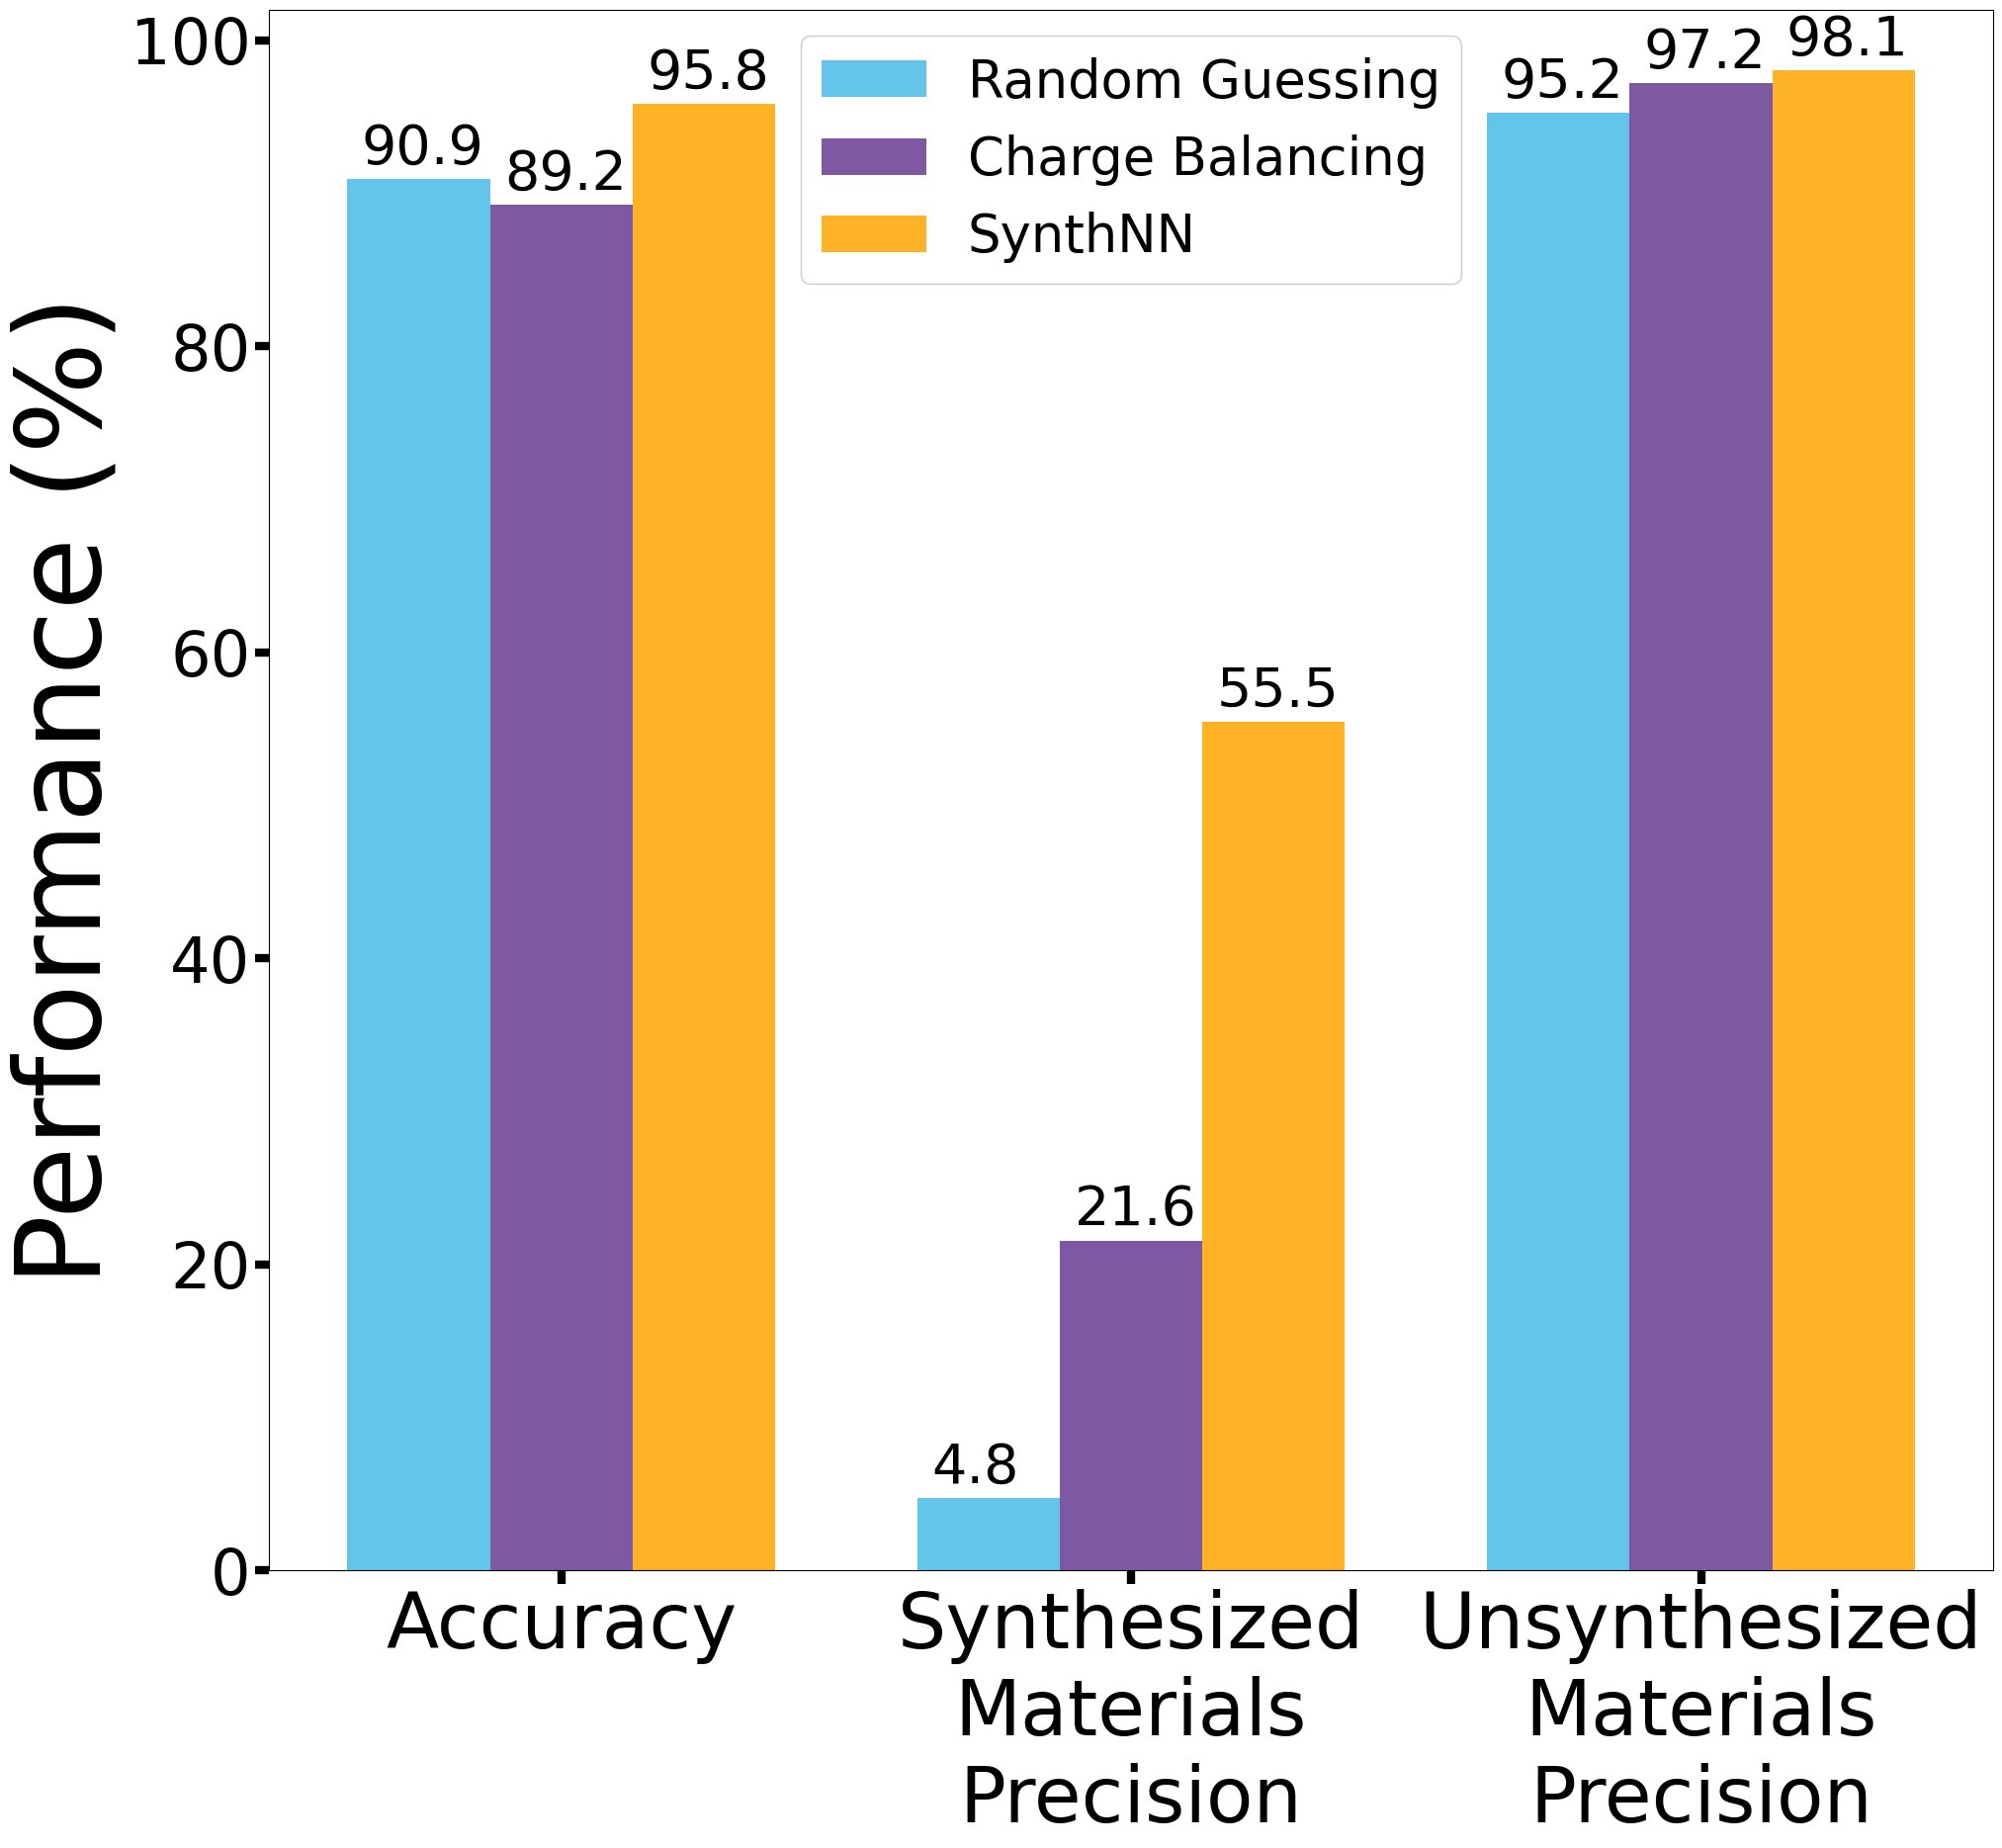

In [5]:
bars1=np.loadtxt('Figure_data/Figure_2/random_performance.txt')
bars2=np.loadtxt('Figure_data/Figure_2/charge_balancing_performance.txt')
bars3=np.loadtxt('Figure_data/Figure_2/synthNN_performance.txt')

# set width of bars
barWidth = 0.25
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + (barWidth) for x in r2]

# Make the plot
plt.bar(r1, bars1, color='#64c5eb', width=barWidth,  label='Random Guessing')
above_bar_fontsize=40
x_offset_amount=0.4
plt.annotate(str(np.round(bars1[0],decimals=1)), [r1[0]-((x_offset_amount)*barWidth),bars1[0]+1], fontsize=above_bar_fontsize)
plt.annotate(str(np.round(bars1[1],decimals=1)), [r1[1]-((x_offset_amount)*barWidth),bars1[1]+1], fontsize=above_bar_fontsize)
plt.annotate(str(np.round(bars1[2],decimals=1)), [r1[2]-((x_offset_amount)*barWidth),bars1[2]+1], fontsize=above_bar_fontsize)
plt.bar(r2, bars2, color='#7f58a4', width=barWidth, label='Charge Balancing')
plt.annotate(str(np.round(bars2[0],decimals=1)), [r2[0]-((x_offset_amount)*barWidth),bars2[0]+1], fontsize=above_bar_fontsize)
plt.annotate(str(np.round(bars2[1],decimals=1)), [r2[1]-((x_offset_amount)*barWidth),bars2[1]+1], fontsize=above_bar_fontsize)
plt.annotate(str(np.round(bars2[2],decimals=1)), [r2[2]-((x_offset_amount)*barWidth),bars2[2]+1], fontsize=above_bar_fontsize)
plt.annotate(str(np.round(bars3[0],decimals=1)), [r3[0]-((x_offset_amount)*barWidth),bars3[0]+1], fontsize=above_bar_fontsize)
plt.annotate(str(np.round(bars3[1],decimals=1)), [r3[1]-((x_offset_amount)*barWidth),bars3[1]+1], fontsize=above_bar_fontsize)
plt.annotate(str(np.round(bars3[2],decimals=1)), [r3[2]-((x_offset_amount)*barWidth),bars3[2]+1], fontsize=above_bar_fontsize)
plt.bar(r3, bars3, color='#feb326', width=barWidth, label='SynthNN')

# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(bars1))], ['Accuracy', 'Synthesized\nMaterials\nPrecision', 'Unsynthesized\nMaterials\nPrecision'], fontsize=56)
plt.yticks([0,20,40,60,80,100])
# Create legend & Show graphic
plt.legend(fontsize=38, framealpha=1)
plt.ylabel('Performance (%)', fontsize=86)
plt.tick_params(axis='y', which='major', labelsize=46, width=6, length=10)
plt.tick_params(axis='x', which='major', labelsize=56, width=6, length=10)
plt.ylim(0,102)
fig = plt.gcf()
fig.set_size_inches(22.5, 20.5)
plt.show()

# FIGURE 2b data generation

In [75]:
#performance of charge balancing on all ICSD (Figure 2b)
#make data for figure 2b; 
#assumes access to ICSD data ('icsd_full_properties_tab_unique.txt'). Otherwise, use processed data below.

import matplotlib.pyplot as plt
results=np.loadtxt('results_common_ox3.txt',dtype=str,delimiter='\t')
database=np.loadtxt('icsd_full_properties_tab_unique.txt', dtype=str, delimiter='\t')
decade_counter=np.zeros((12,1)) #counts number of instances of each decade
true_decade_counter=np.zeros((12,1)) #counts number of charge-balanced instances of each decade
for i in range(len(results)):
    if(len(results[i][0])>5):
        year=int(database[i][5])
        decade=year - (year%10)
        index=int(decade/10)-191 #index of counter arrays
        #ignore penta+ formulas
        if('TooMany' not in results[i][1]):
            decade_counter[index]=decade_counter[index]+1
            if('True' in results[i][1]):
                true_decade_counter[index]=true_decade_counter[index]+1
np.savetxt('Figure_data/Figure_2/true_decade_counter.txt',true_decade_counter)
np.savetxt('Figure_data/Figure_2/decade_counter.txt',decade_counter)

# Figure 2b plotting

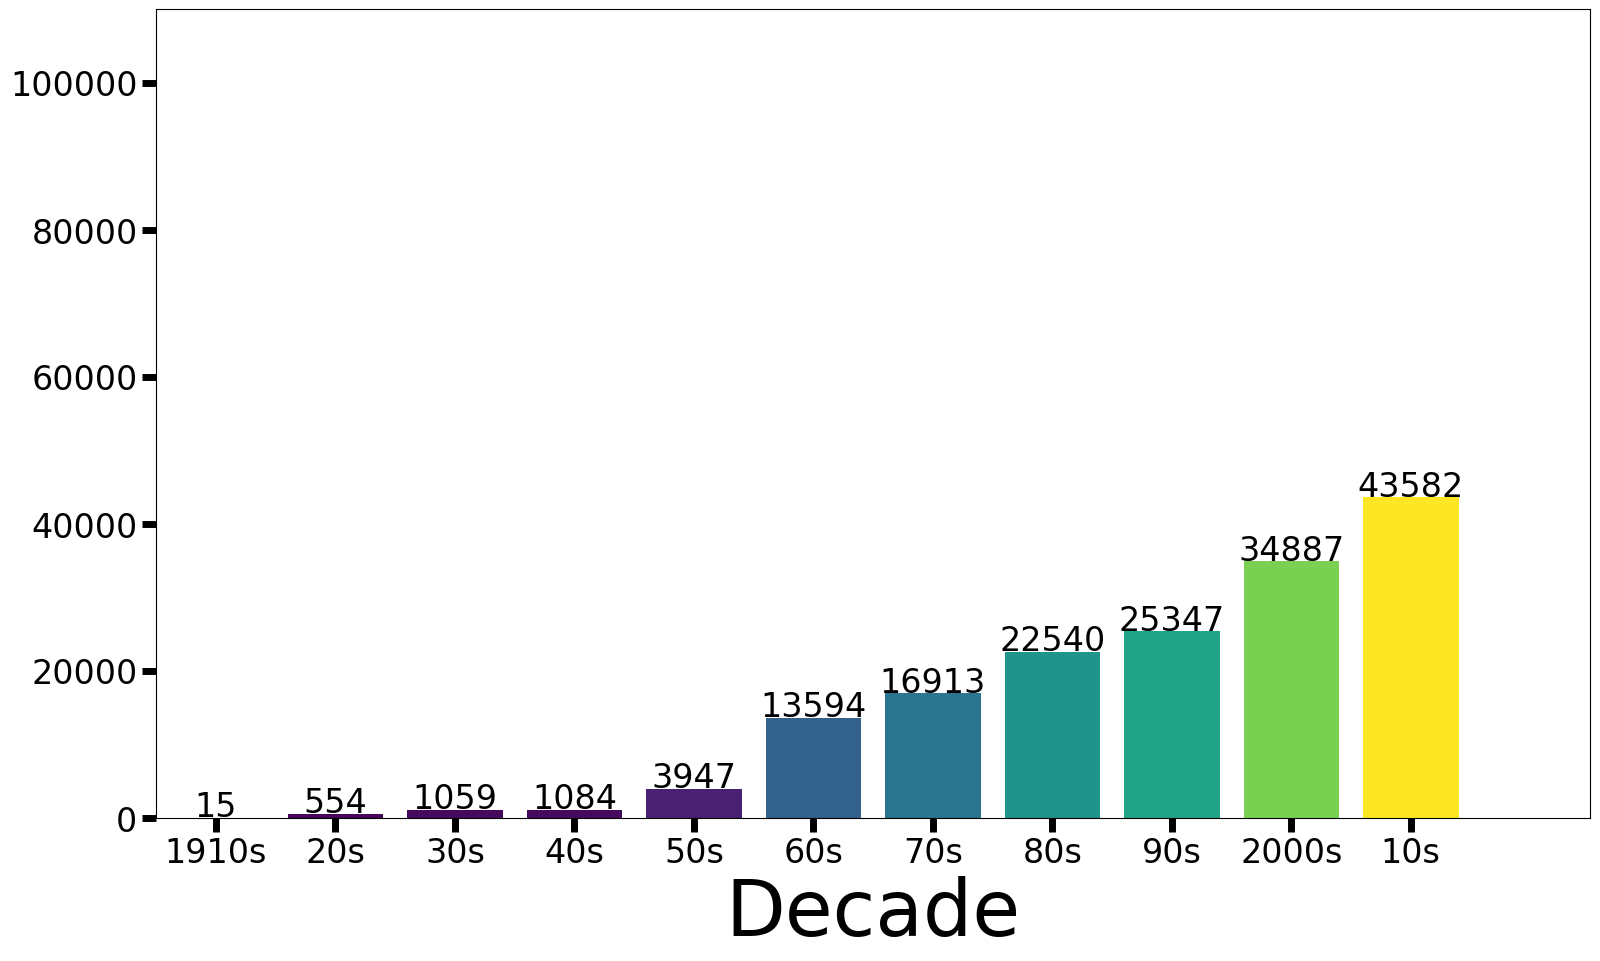

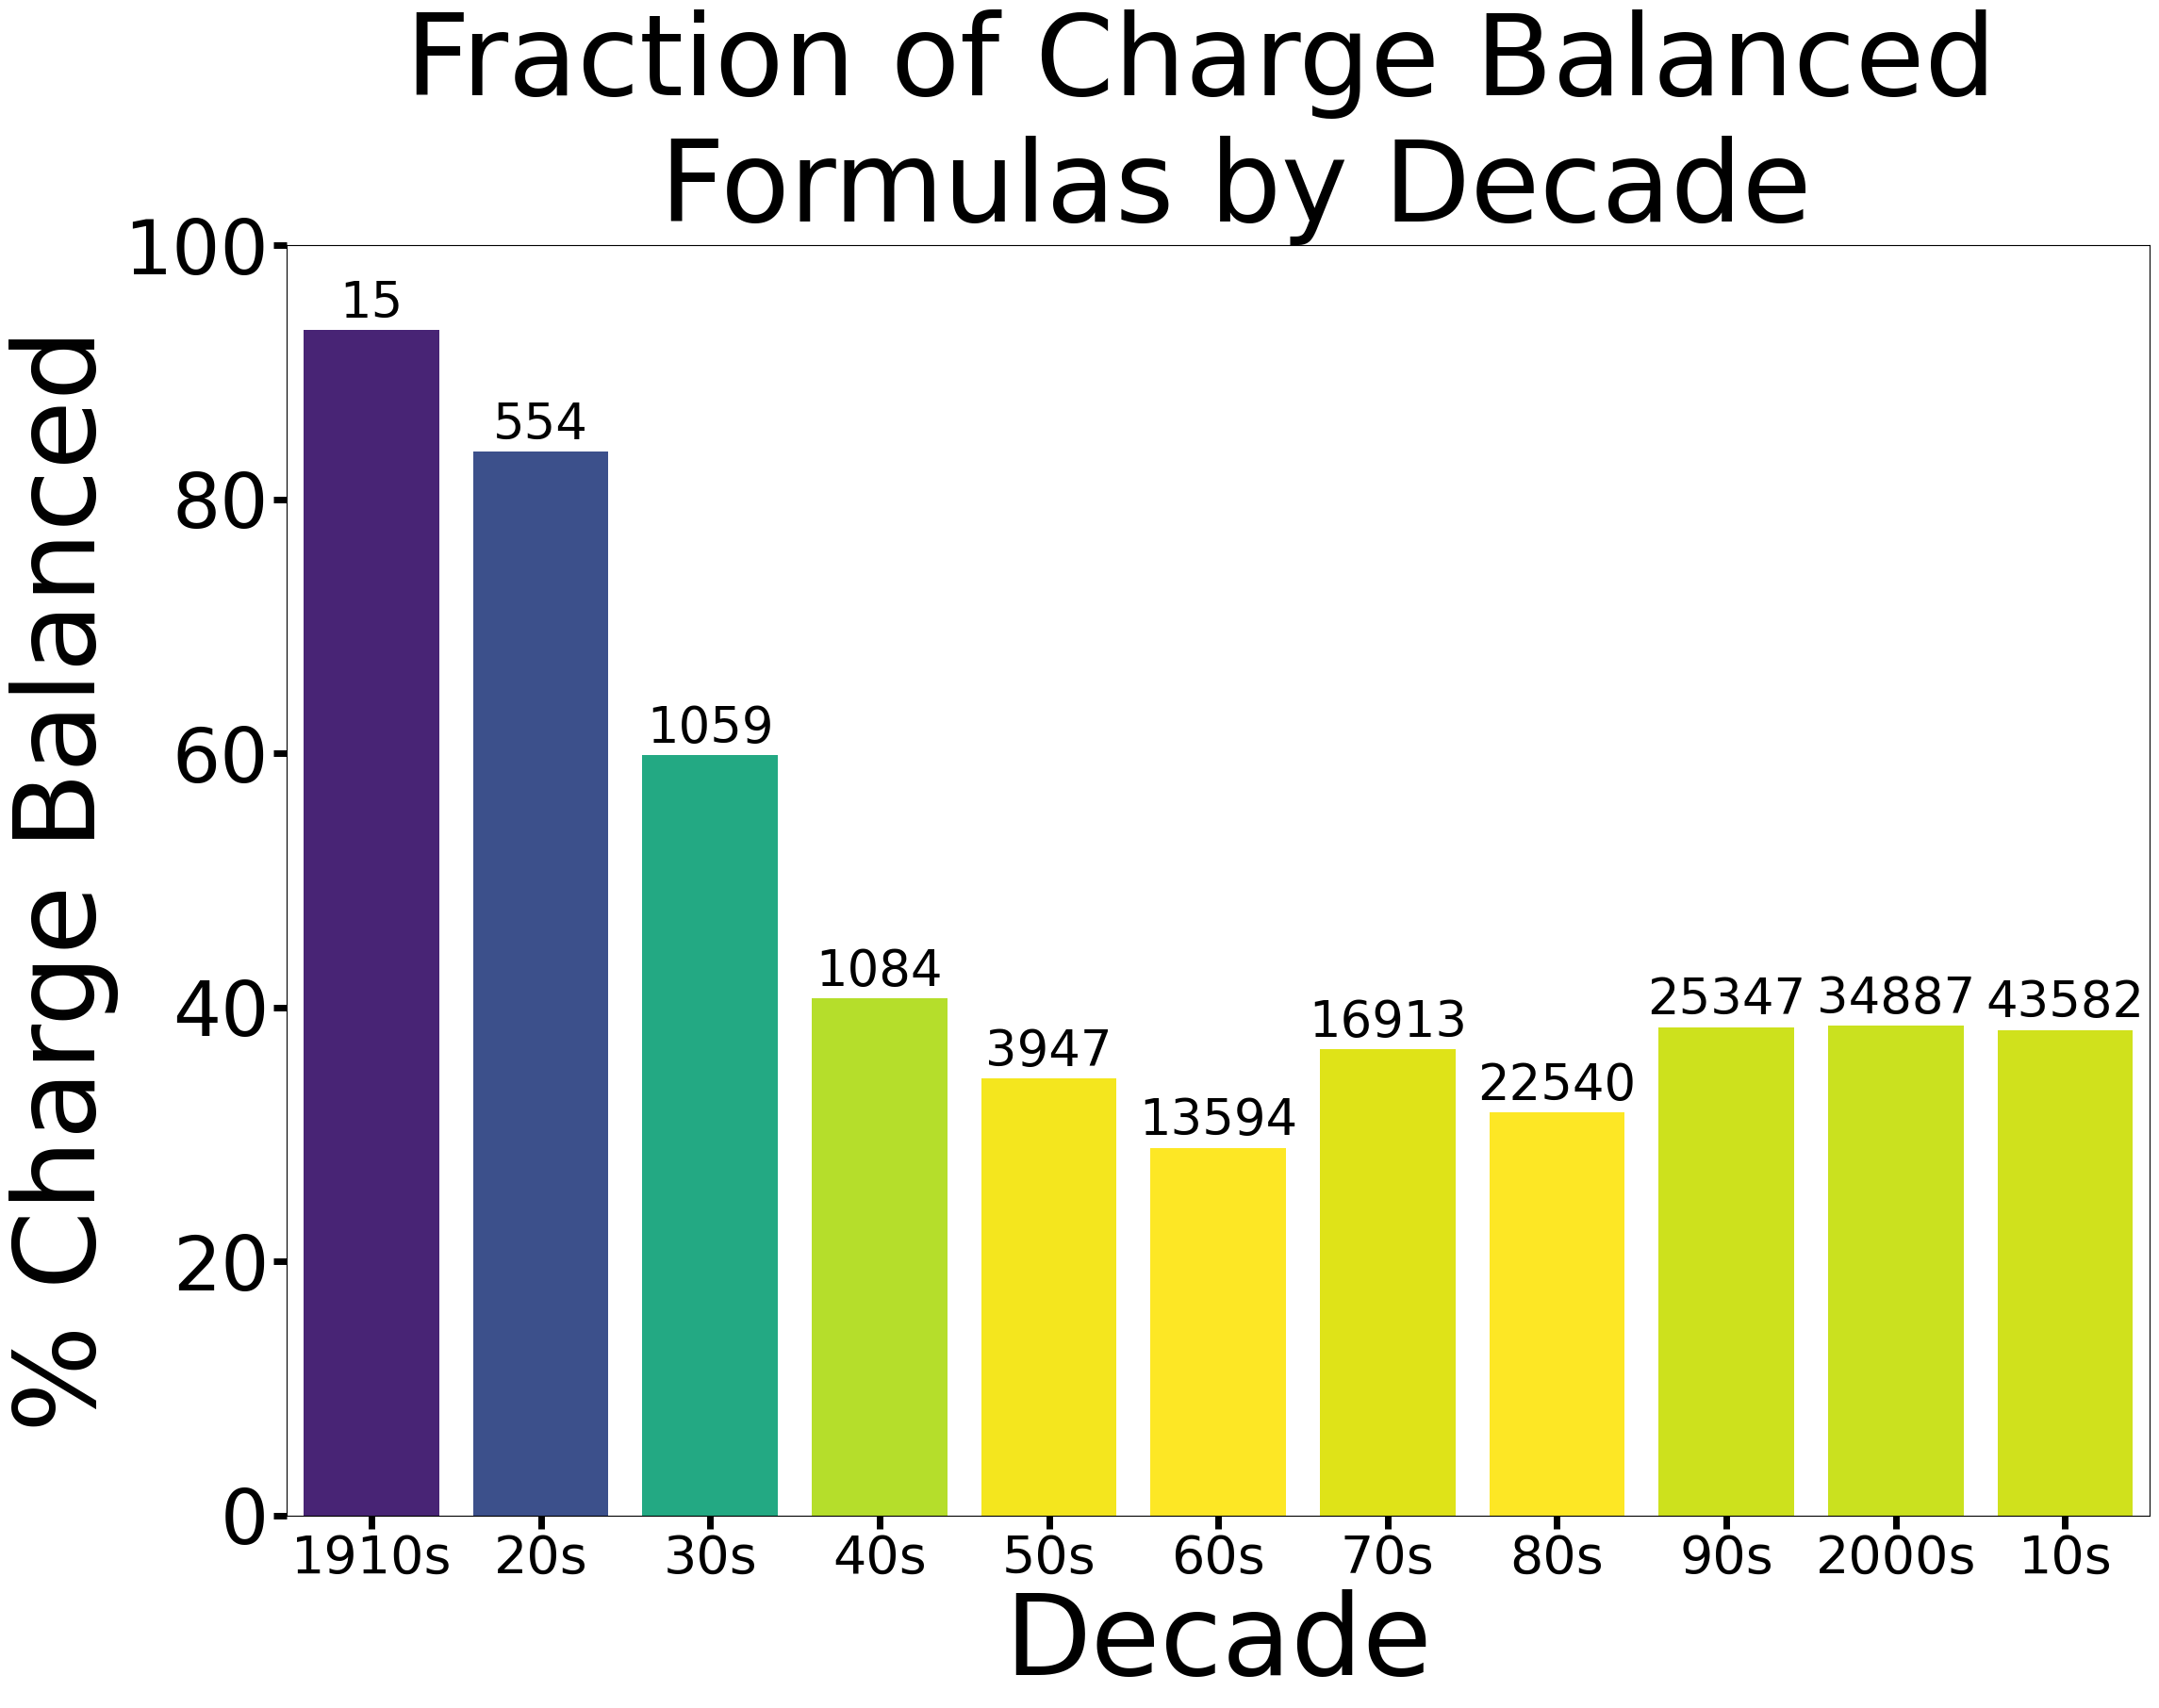

In [6]:
#performance of charge balancing on all ICSD (Figure 2b)
true_decade_counter=np.loadtxt('Figure_data/Figure_2/true_decade_counter.txt',dtype=float)
decade_counter=np.loadtxt('Figure_data/Figure_2/decade_counter.txt',dtype=float)

decades = ['1910s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '2000s', '10s', '20s']
y=np.reshape(np.array(true_decade_counter/decade_counter), [12,])
colors=plt.get_cmap('viridis')
decade_counter=np.reshape(np.array(decade_counter), [12,])
color_bars=[]

#optional plot of number of materials synthesized per decade (not in paper)
for i in range(11):
    color_bars.append(colors(decade_counter[i]/max(decade_counter)))
plt.bar(decades[0:11],decade_counter[0:11], color=color_bars)
for i in range(11):
    plt.annotate( str(int(decade_counter[i])), [i,decade_counter[i]+200], fontsize=24, ha='center')
plt.ylim(0,110000)
plt.xlim(-0.5,11.5)
#plt.ylabel('# Materials', fontsize=66)
plt.xlabel('Decade', fontsize=56)
plt.tick_params(axis='both', which='major', labelsize=24, width=5, length=10)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

colors=plt.get_cmap('viridis')
color_bars=[]

for i in range(11):
    color_bars.append(colors(1.5*(1-y[i])))
plt.bar(decades[0:11],100*y[0:11], color=color_bars)
for i in range(11):
    plt.annotate( str(int(decade_counter[i])), [i,100*y[i]+1], fontsize=38, ha='center')
plt.ylim(0,100)
plt.xlim(-0.5,10.5)
plt.ylabel('% Charge Balanced', fontsize=86)
plt.xlabel('Decade', fontsize=86)
plt.tick_params(axis='y', which='major', labelsize=58, width=5, length=10)
plt.tick_params(axis='x', which='major', labelsize=40, width=5, length=10)
plt.title('Fraction of Charge Balanced \n Formulas by Decade', fontsize=86)
fig = plt.gcf()
fig.set_size_inches(25.5, 17.5)
plt.show()

# Direct Comparison of Roost, Charge Balancing and SynthNN (Table S4)

In [126]:
#get MAE of Roost on training data
roost_full_preds=np.loadtxt('roost_MP_ehull_preds.csv',dtype=str,delimiter=',')
np.mean(np.abs(np.array(roost_full_preds[1:][:,2],dtype=float)-np.array(roost_full_preds[1:][:,3],dtype=float)))

0.06257490040815061

In [127]:
roost_full_preds=np.loadtxt('roost_synthesizability_test_set.txt',dtype=str,delimiter=',')
cb_preds=np.loadtxt('decade_v4_test_set_charges.txt',dtype=str,delimiter='[')
formulas=[cb_preds[:,0][i].split(' ')[0] for i in range(len(cb_preds))]
true_labels=[cb_preds[:,0][i].split(' ')[1] for i in range(len(cb_preds))]
roost_ehull_preds=np.array(roost_full_preds[1:][:,2],dtype=float)

#Roost
ehull_cutoff=0.05
TP,FP,TN,FN=0,0,0,0
for i in range(len(formulas)):
    if(roost_ehull_preds[i]<ehull_cutoff):
        if(true_labels[i]=='1.0'):
            TP=TP+1
        else:
            FP=FP+1
    else:
        if(true_labels[i]=='1.0'):
            FN=FN+1
        else:
            TN=TN+1
print('Roost')
print(TP,FP,TN,FN)

#Charge balancing
TP,FP,TN,FN=0,0,0,0
for i in range(len(formulas)):
    if('True' in cb_preds[i][1]):
        if(true_labels[i]=='1.0'):
            TP=TP+1
        else:
            FP=FP+1
    else:
        if(true_labels[i]=='1.0'):
            FN=FN+1
        else:
            TN=TN+1
print('Charge Balancing')
print(TP,FP,TN,FN)

##SynthNN
x_data=get_features(formulas)
yvalues=np.zeros((len(formulas),2))
for i in range(len(yvalues)):
    if (true_labels[i]=='1.0'):
        yvalues[i,0]=1
    else:
        yvalues[i,1]=1
preds=SynthNN_best_model(x_data,yvalues,formulas)
TP, FP, TN, FN=perf_measure(np.array(yvalues)[:,0],np.array(preds)[:,0],0.5)
print('SynthNN')
print(TP,FP,TN,FN)

Roost
1775 24396 23803 635
Charge Balancing
1150 4185 44014 1260
SynthNN
1484 1192 47007 926


# Figure 2c data generation

In [77]:
#roost icsd preds, 
roost_energy_preds=np.loadtxt('roost_icsd_ehull_preds.csv',dtype=str,delimiter=',')
num_synth_entries=53594 #first 53594 entries are in icsd
formulas=[roost_energy_preds[i][1] for i in range(1,len(roost_energy_preds))]
roost_ehull_pred=np.array([float(roost_energy_preds[i][2]) for i in range(1,len(roost_energy_preds))])
precision_DFT_array=[]
recall_DFT_array=[]
ehull_range=np.array([0.000001,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

print('doing Roost Preds')
for ehull_cutoff in ehull_range:
    synth_preds_ehull=np.where(np.array(roost_ehull_pred,dtype=float)<ehull_cutoff)[0]
    TP,FP,TN,FN=0,0,0,0
    TP=len(np.where(roost_ehull_pred[0:num_synth_entries]<ehull_cutoff)[0])
    FP=len(np.where(roost_ehull_pred[num_synth_entries:]<ehull_cutoff)[0])
    TN=len(np.where(roost_ehull_pred[num_synth_entries:]>ehull_cutoff)[0])
    FN=len(np.where(roost_ehull_pred[0:num_synth_entries]>ehull_cutoff)[0])
    print(TP,FP,TN,FN)
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    print(precision,recall)
    precision_DFT_array.append(precision)
    recall_DFT_array.append(recall)
    
print('doing SynthNN Preds')
x_data=get_features(formulas)
yvalues=np.zeros((len(formulas),2))
for i in range(len(yvalues)):
    if i<num_synth_entries+1:
        yvalues[i,0]=1
    else:
        yvalues[i,1]=1
preds=SynthNN_best_model(x_data,yvalues,formulas)
precision_synthNN_array=[]
recall_synthNN_array=[]

for threshold in np.linspace(0,0.998,50):
    TP, FP, TN, FN=perf_measure(np.array(yvalues)[:,0],np.array(preds)[:,0],threshold)
    print(TP,FP,TN,FN)
    precision_synthNN=TP/(TP+FP)
    recall_synthNN=TP/(TP+FN)
    precision_synthNN_array.append(precision_synthNN)
    recall_synthNN_array.append(recall_synthNN)

np.savetxt('Figure_data/Figure_2/roost_precision.txt',precision_DFT_array)
np.savetxt('Figure_data/Figure_2/roost_recall.txt',recall_DFT_array)
np.savetxt('Figure_data/Figure_2/synthNN_precision.txt',precision_synthNN_array)
np.savetxt('Figure_data/Figure_2/synthNN_recall.txt',recall_synthNN_array)

doing Roost Preds
181 5721 1127163 53413
0.030667570315147406 0.003377243721312087
37028 511325 621559 16566
0.06752584557757503 0.6908982348770385
47326 708828 424056 6268
0.06258777973798987 0.8830466096951152
51207 832991 299893 2387
0.057913499012664585 0.9554614322498787
52255 896383 236501 1339
0.05508423655809698 0.9750158599843266
52647 937824 195060 947
0.05315349969862823 0.9823301115796544
52888 969515 163369 706
0.05172911268844086 0.9868268836063738
53020 991089 141795 574
0.05078013885523446 0.98928984587827
53118 1007340 125544 476
0.050089678233367095 0.9911184087771019
53184 1022570 110314 410
0.049438812219150474 0.99234988991305
53237 1037169 95715 357
0.0488230989191182 0.9933388065828265
53281 1051372 81512 313
0.04823324609628544 0.9941597940067918
doing SynthNN Preds
53595 1132883 0 0
52067 384046 748837 1528
50592 269234 863649 3003
49304 212404 920479 4291
48194 176337 956546 5401
47167 151735 981148 6428
46246 132671 1000212 7349
45334 117426 1015457 8261
4447

# Figure 2c plotting

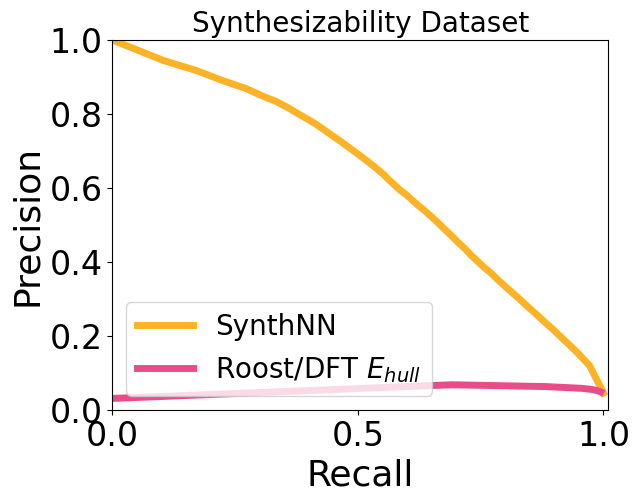

In [7]:
fig, ax = plt.subplots()
precision_DFT_array=np.loadtxt('Figure_data/Figure_2/roost_precision.txt')
recall_DFT_array=np.loadtxt('Figure_data/Figure_2/roost_recall.txt')
recall_synthNN_array=np.loadtxt('Figure_data/Figure_2/synthNN_recall.txt')
precision_synthNN_array=np.loadtxt('Figure_data/Figure_2/synthNN_precision.txt')
plt.plot(recall_synthNN_array,precision_synthNN_array,label='SynthNN', color='#feb326',linewidth=5)
plt.plot(recall_DFT_array,precision_DFT_array,label=r'Roost/DFT $E_{hull}$', color='#e84d8a',linewidth=5)
plt.title('Synthesizability Dataset',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('Precision',fontsize=26)
plt.xlabel('Recall',fontsize=26)
plt.xlim(0,1.01)
plt.ylim(0,1)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=24)
plt.show()

# Figure 3a

Instructions for updating:
Use `tf.global_variables_initializer` instead.


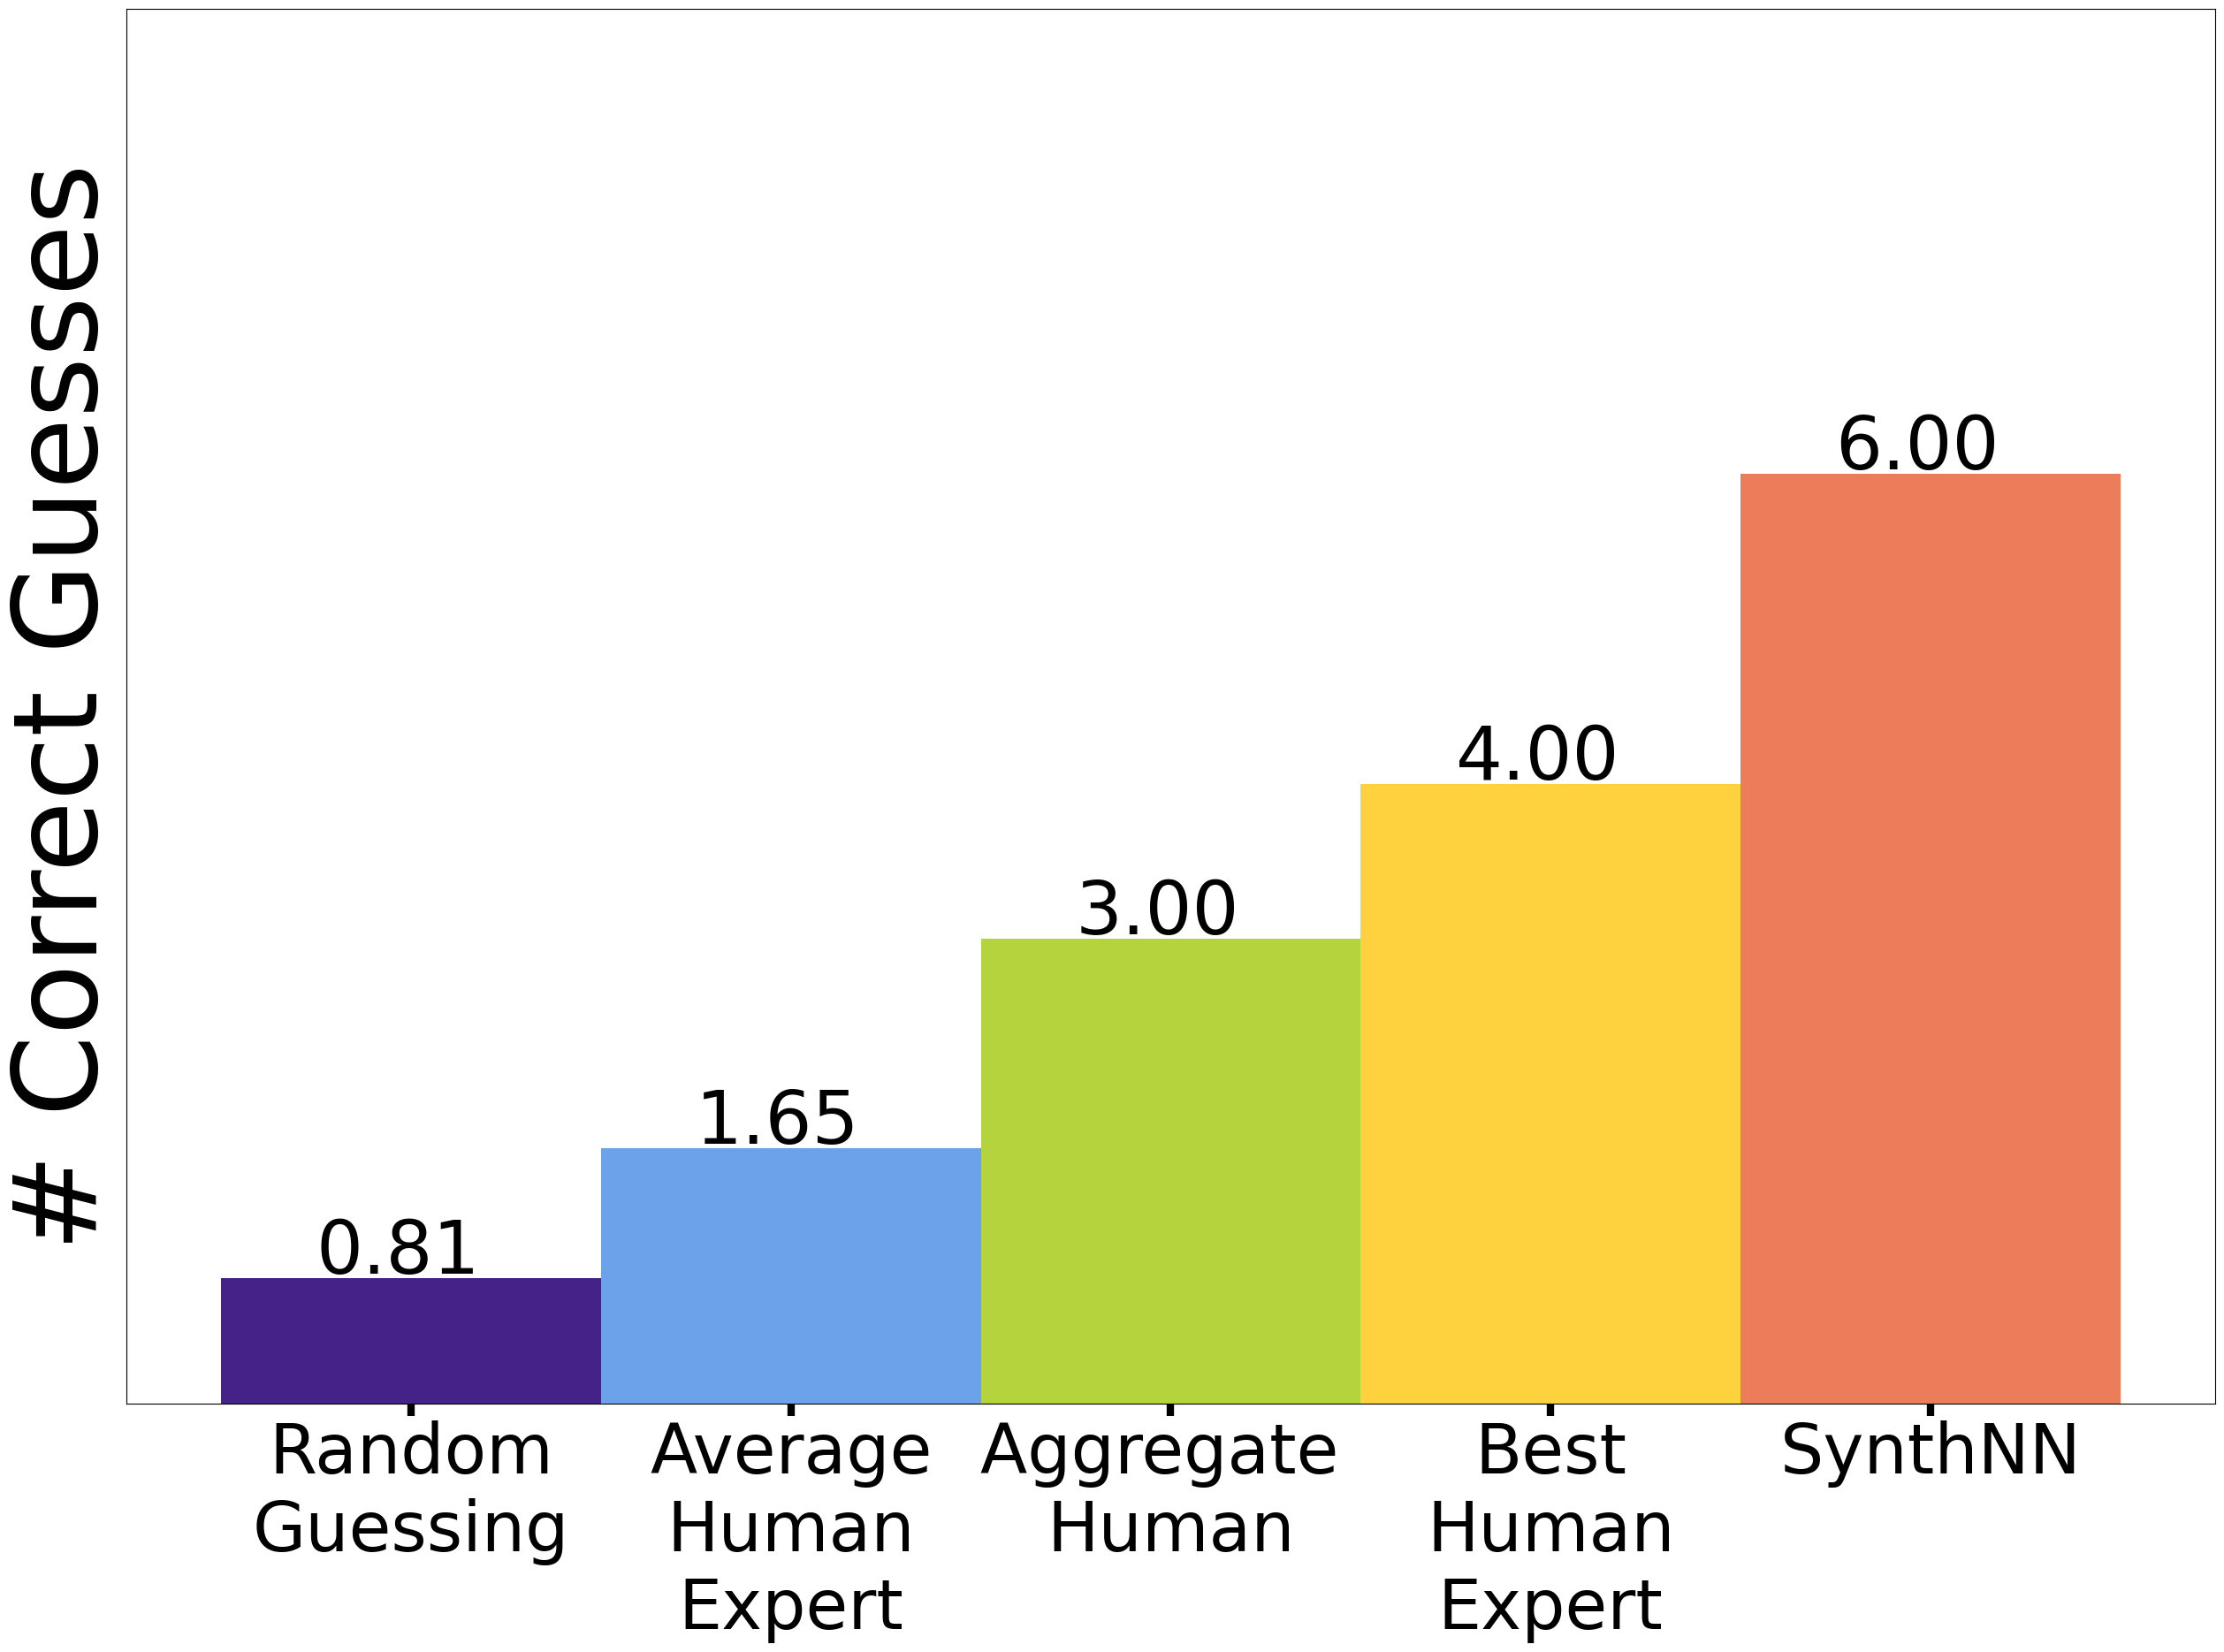

In [8]:
#figure 3a
output=np.zeros(100)
results=np.loadtxt('Figure_data/Figure_3/synthesizability_quiz_responses.txt', dtype=str, delimiter=';')
formula_array=np.loadtxt('Figure_data/Figure_3/human_test_set.txt', dtype=str)
labels_array=np.loadtxt('Figure_data/Figure_3/human_test_set_labels.txt', dtype=int)
individual_responses_array=[]
for j in range(len(results)):
    individual_responses=[]
    for i in range(len(results[j])):
        try:
            answer=int(results[j][i][0:3])
        except:
            try:
                answer=int(results[j][i][0:2])
            except:
                answer=int(results[j][i][0:1])
        output[answer-1]=output[answer-1]+1
        individual_responses.append(answer-1)
    individual_responses_array.append(individual_responses)

#then plot this vs. avg coefficient, binary, ternary, quat, 
binary_counter_synth=[0,0,0]
binary_counter_unsynth=[0,0,0]
for i in range(len(formula_array)):
    if(labels_array[i]==1):
        num_atoms=len(mg.core.composition.Composition(formula_array[i]))
        binary_counter_synth[num_atoms-2]=binary_counter_synth[num_atoms-2]+1
    else:
        num_atoms=len(mg.core.composition.Composition(formula_array[i]))
        binary_counter_unsynth[num_atoms-2]=binary_counter_unsynth[num_atoms-2]+1

#normalize these and plot 
binary_counter_synth_human=[0,0,0]
for i in range(len(formula_array)):
    num_atoms=len(mg.core.composition.Composition(formula_array[i]))
    binary_counter_synth_human[num_atoms-2]=binary_counter_synth_human[num_atoms-2]+output[i]

num_humans=20
barWidth = 0.20
#for 15:1 neg:positive ratio
# set heights of bars, 
bars1= [9*(9/100)] #random guessing

#average human performance
bars2=np.sum(output[np.where(labels_array==1)[0]])/num_humans

#hivemind human performance
hivemind_guesses=np.argsort(-output)[0:9]
human_hivemind_counter=0
true_label_indices=np.where(labels_array==1)[0]
for i in np.argsort(-output)[0:9]:
    if(i in true_label_indices):
        human_hivemind_counter=human_hivemind_counter+1
bars3=human_hivemind_counter

#best human performance
best_human=0
#true_label_indices
for individual_guesses in individual_responses_array:
    performance=0
    for i in individual_guesses:
        if(i in true_label_indices):
            performance=performance+1
    if(performance>best_human):
        best_human=performance
bars4= best_human

#synthNN performance
x_quiz=get_features(formula_array)
dummy_y_values=np.zeros((len(formula_array),2))
synthNN_quiz_preds=SynthNN_best_model(x_quiz,dummy_y_values,formula_array)[:,0]
synthNN_guesses=np.argsort(-synthNN_quiz_preds)[:9]
synthNN_counter=0
for i in synthNN_guesses:
    if(i in true_label_indices):
        synthNN_counter=synthNN_counter+1

bars5 = synthNN_counter

# Set position of bar on X axis
r1 = 0
r2 = 0.20
r3 = 0.40
r4 = 0.60
r5=0.80
colors=['#442288','#6CA2EA','#B5D33D', '#FED23F','#EB7D5B']
# Make the plot
plt.bar(r1, bars1, color=colors[0], width=barWidth,  label='Random Guessing')
plt.annotate(str(np.round(bars1[0], decimals=2)), [r1-0.05,bars1[0]+0.03], fontsize=60)
#make another bar for SynthNN predictions
plt.bar(r2, bars2, color=colors[1], width=barWidth, label='Average Human Expert')
plt.annotate(str(np.round(bars2, decimals=2)), [r2-0.05,bars2+0.03], fontsize=60)
plt.bar(r3, bars3, color=colors[2], width=barWidth, label='Aggregate Human')
plt.annotate('3.00', [r3-0.05,bars3+0.03], fontsize=60)
plt.bar(r4, bars4, color=colors[3], width=barWidth, label='Best Human Expert')
plt.annotate('4.00', [r4-0.05,bars4+0.03], fontsize=60)
plt.bar(r5, bars5, color=colors[4], width=barWidth, label='SynthNN')
plt.annotate('6.00', [r5-0.05,bars5+0.03], fontsize=60)
# Add xticks on the middle of the group bars
plt.yticks(np.linspace(12,13,10))
# Create legend & Show graphic
#plt.legend(fontsize=56, framealpha=1, loc='upper left')
plt.xticks([10,20])
plt.ylabel('# Correct Guesses', fontsize=95)
plt.tick_params(axis='y', which='major', labelsize=46, width=6, length=10)
plt.tick_params(axis='x', which='major', labelsize=56, width=6, length=10)
plt.xticks([r for r in np.linspace(0,0.8,5)], ['Random\nGuessing', 'Average\nHuman\nExpert', 'Aggregate \nHuman', 'Best\nHuman\nExpert', 'SynthNN'], fontsize=56)
plt.ylim(0.0,9)
plt.xlim(-0.15,0.95)
fig = plt.gcf()
fig.set_size_inches(30.5, 20.5)
plt.show()

# Figure 3b Data Generation

In [10]:
#get counter for synthNN preds on test set
xte,yte,data_te=get_batch_test(20)
synthNN_preds=SynthNN_best_model(xte,yte,data_te)[:,0]
synthNN_formula_preds=data_te[np.where(synthNN_preds>0.5)[0]]
synthNN_counter=[0,0,0] #counter for binary, ternary, quaternary
for i in range(len(synthNN_formula_preds)):
    formula_num_atom_types=len(mg.core.Composition(synthNN_formula_preds[i]))
    synthNN_counter[formula_num_atom_types-2]=synthNN_counter[formula_num_atom_types-2]+1
np.savetxt('Figure_data/Figure_3/SynthNN_counter.txt',synthNN_counter)

#get true counter for test set of Synthesizability Dataset
dataset_counter=[0,0,0] #counter for binary, ternary, quaternary
for i in range(len(data_te)):
    if(int(yte[i][0])==1):
        formula_num_atom_types=len(mg.core.Composition(data_te[i]))
        dataset_counter[formula_num_atom_types-2]=dataset_counter[formula_num_atom_types-2]+1
np.savetxt('Figure_data/Figure_3/dataset_counter.txt',dataset_counter)

# Figure 3b Plotting

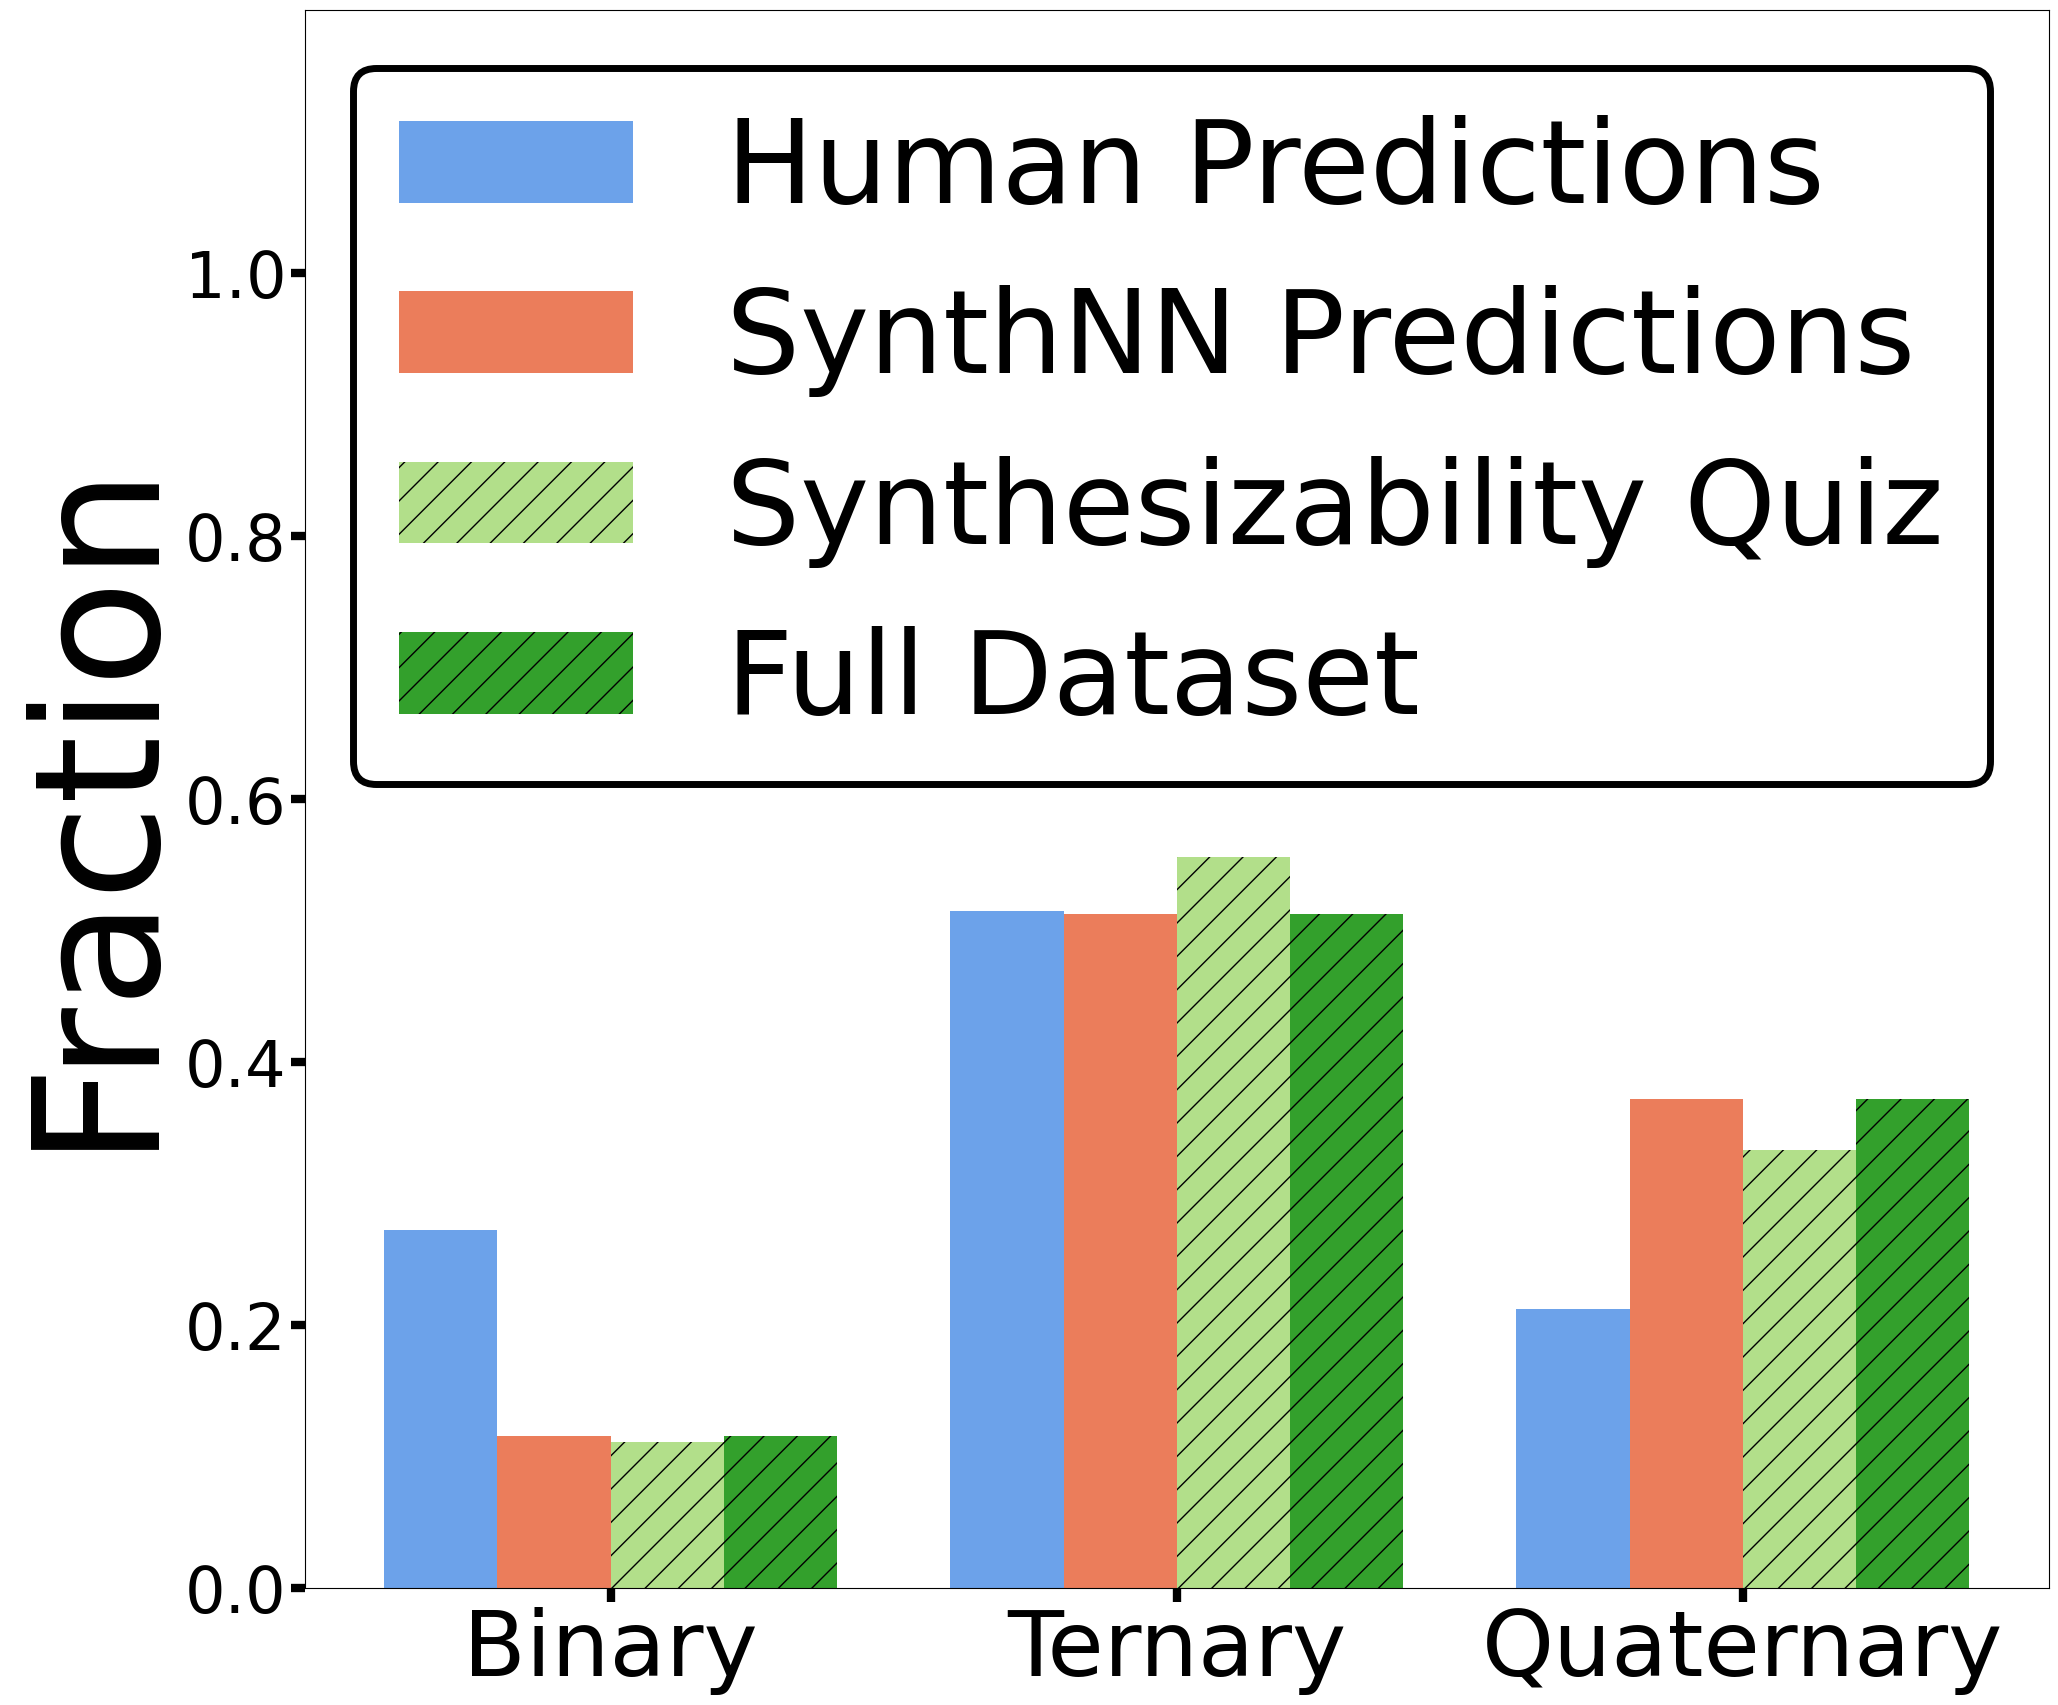

In [9]:
output=np.zeros(100)
synthNN_counter=np.loadtxt('Figure_data/Figure_3/SynthNN_counter.txt')
synthNN_counter=np.array(synthNN_counter,dtype=int)
dataset_counter=np.loadtxt('Figure_data/Figure_3/dataset_counter.txt')
dataset_counter=np.array(synthNN_counter,dtype=int)
results=np.loadtxt('Figure_data/Figure_3/synthesizability_quiz_responses.txt', dtype=str, delimiter=';')
formula_array=np.loadtxt('Figure_data/Figure_3/human_test_set.txt', dtype=str)
labels_array=np.loadtxt('Figure_data/Figure_3/human_test_set_labels.txt', dtype=int)
true_label_indices=np.where(labels_array==1)[0]

for j in range(len(results)):
    for i in range(len(results[j])):
        try:
            answer=int(results[j][i][0:3])
        except:
            try:
                answer=int(results[j][i][0:2])
            except:
                answer=int(results[j][i][0:1])
        output[answer-1]=output[answer-1]+1

binary_counter_synth=[0,0,0] #count binary, ternary, quat compounds
binary_counter_unsynth=[0,0,0]

for i in range(len(formula_array)):
    if(labels_array[i]==1):
        num_atoms=len(Composition(formula_array[i]))
        binary_counter_synth[num_atoms-2]=binary_counter_synth[num_atoms-2]+1
    else:
        num_atoms=len(Composition(formula_array[i]))
        binary_counter_unsynth[num_atoms-2]=binary_counter_unsynth[num_atoms-2]+1

#normalize these and plot 
binary_counter_synth_human=[0,0,0]
for i in range(len(formula_array)):
    if(i in true_label_indices):
        num_atoms=len(mg.core.composition.Composition(formula_array[i]))
        binary_counter_synth_human[num_atoms-2]=binary_counter_synth_human[num_atoms-2]+output[i]

barWidth = 0.20
# set heights of bars, 
bars1=binary_counter_synth_human/np.sum(binary_counter_synth_human)
bars2=np.array([synthNN_counter[0],synthNN_counter[1],synthNN_counter[2]])/(np.sum(synthNN_counter)) #synthNN prediction
bars3= binary_counter_synth/np.sum(binary_counter_synth) #counter for Synthesizability Quiz
bars4 = np.array([dataset_counter[0],dataset_counter[1],dataset_counter[2]])/(np.sum(dataset_counter)) #counter for Synthesizability dataset

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + (barWidth) for x in r2]
r4 = [x + (barWidth) for x in r3]

# Make the plot
barfont=35
barshift=barWidth/2.25
plt.bar(r1, bars1, color='#6CA2EA', width=barWidth,  label='Human Predictions')
plt.bar(r2, bars2, color='#EB7D5B', width=barWidth, label='SynthNN Predictions')
plt.bar(r3, bars3, color='#b2df8a', width=barWidth, label='Synthesizability Quiz',hatch='/')
plt.bar(r4, bars4, color='#33a02c', width=barWidth, label='Full Dataset',hatch='/')

# Add xticks on the middle of the group bars
plt.xticks([r + (1.5*barWidth) for r in range(len(bars1))], ['Binary', 'Ternary', 'Quaternary'], fontsize=75)
plt.yticks([0,0.20,0.40,0.60,0.80,1.00])
# Create legend & Show graphic
leg=plt.legend(fontsize=84, framealpha=1)
leg.get_frame().set_linewidth(5)
leg.get_frame().set_edgecolor("black")
plt.ylabel('Fraction', fontsize=126)
plt.tick_params(axis='y', which='major', labelsize=46, width=6, length=10)
plt.tick_params(axis='x', which='major', labelsize=66, width=6, length=10)
plt.ylim(0,1.2)
fig = plt.gcf()
fig.set_size_inches(22.5, 20.5)
plt.show()

# Figure 3c Data Generation

In [91]:
#Figure 3c
output=np.zeros(100)
labels_array=np.loadtxt('Figure_data/Figure_3/human_test_set_labels.txt', dtype=int)
results=np.loadtxt('Figure_data/Figure_3/synthesizability_quiz_responses.txt', dtype=str, delimiter=';')
data=np.loadtxt('Figure_data/Figure_3/human_test_set.txt', dtype=str)

#process the human answers
for j in range(len(results)):
    for i in range(len(results[j])):
        try:
            answer=int(results[j][i][0:3])
        except:
            try:
                answer=int(results[j][i][0:2])
            except:
                answer=int(results[j][i][0:1])
        output[answer-1]=output[answer-1]+1

#now calculate the Human Performance on Synthesizability Quiz
human_TP_block_pred_dict = {"s": 0,"p": 0,"d": 0,"f":0}
human_FP_block_pred_dict = {"s": 0,"p": 0,"d": 0,"f":0}
human_TN_block_pred_dict = {"s": 0,"p": 0,"d": 0,"f":0}
human_FN_block_pred_dict = {"s": 0,"p": 0,"d": 0,"f":0}
for i in range(len(data)):
    elements=mg.core.composition.Composition(data[i]).as_dict().keys()
    blocks_in_formula=np.unique([mg.core.periodic_table.Element(element).block for element in elements])
    for element_block_name in blocks_in_formula:
        if(labels_array[i]==1): 
            human_TP_block_pred_dict[element_block_name]=human_TP_block_pred_dict[element_block_name]+output[i]
            human_FN_block_pred_dict[element_block_name]=human_FN_block_pred_dict[element_block_name]+(20-output[i])
        else:
            for element in elements:
                human_FP_block_pred_dict[element_block_name]=human_TP_block_pred_dict[element_block_name]+output[i]
                human_TN_block_pred_dict[element_block_name]=human_FN_block_pred_dict[element_block_name]+(20-output[i])           
human_s_block_performance=(human_TP_block_pred_dict['s']/(human_TP_block_pred_dict['s']+(0.5*(human_FP_block_pred_dict['s']+human_FN_block_pred_dict['s']))))
human_p_block_performance=(human_TP_block_pred_dict['p']/(human_TP_block_pred_dict['p']+(0.5*(human_FP_block_pred_dict['p']+human_FN_block_pred_dict['p']))))
human_d_block_performance=(human_TP_block_pred_dict['d']/(human_TP_block_pred_dict['d']+(0.5*(human_FP_block_pred_dict['d']+human_FN_block_pred_dict['d']))))
human_f_block_performance=(human_TP_block_pred_dict['f']/(human_TP_block_pred_dict['f']+(0.5*(human_FP_block_pred_dict['f']+human_FN_block_pred_dict['f']))))
human_results=np.array([human_s_block_performance,human_p_block_performance,human_d_block_performance,human_f_block_performance])

#SynthNN results on Synthesizabilty Quiz (100 examples)
quiz_s_block_performance,quiz_p_block_performance,quiz_d_block_performance,quiz_f_block_performance=get_block_performance(data,labels_array)
synthNN_quiz_F1=np.array([np.mean(quiz_s_block_performance),np.mean(quiz_p_block_performance),np.mean(quiz_d_block_performance),np.mean(quiz_f_block_performance)])
#######

#synthNN full test set means and std dev
s_block_performance=[]
p_block_performance=[]
d_block_performance=[]
f_block_performance=[]
xte,yte,te_data=get_batch_test(91/9)
shuffle_indices=np.random.permutation(len(te_data))
xte_shuff,yte_shuff,te_data_shuff=xte[shuffle_indices],yte[shuffle_indices],te_data[shuffle_indices]
for batch_num in range(int(np.floor(len(te_data)/100))):
    yte_batch=np.array(yte_shuff)[:,0][100*batch_num:100*(batch_num+1)]
    te_data_batch=te_data_shuff[100*batch_num:100*(batch_num+1)] 
    s_block_performance_batch,p_block_performance_batch,d_block_performance_batch,f_block_performance_batch=get_block_performance(te_data_batch,yte_batch)
    s_block_performance.append(s_block_performance_batch)
    p_block_performance.append(p_block_performance_batch)
    d_block_performance.append(d_block_performance_batch)
    f_block_performance.append(f_block_performance_batch)
synthNN_full_test_set_F1=np.array([np.mean(s_block_performance),np.mean(p_block_performance),np.mean(d_block_performance),np.mean(f_block_performance)])
synthNN_full_test_set_std_dev=np.array([np.std(s_block_performance),np.std(p_block_performance),np.std(d_block_performance),np.std(f_block_performance)])
################
np.savetxt('Figure_data/Figure_3/synthNN_quiz_F1.txt',synthNN_quiz_F1)
np.savetxt('Figure_data/Figure_3/synthNN_full_test_set_F1.txt',synthNN_full_test_set_F1)
np.savetxt('Figure_data/Figure_3/synthNN_full_test_set_std_dev.txt',synthNN_full_test_set_std_dev)
np.savetxt('Figure_data/Figure_3/human_results.txt',human_results)

# Figure 3c Plotting

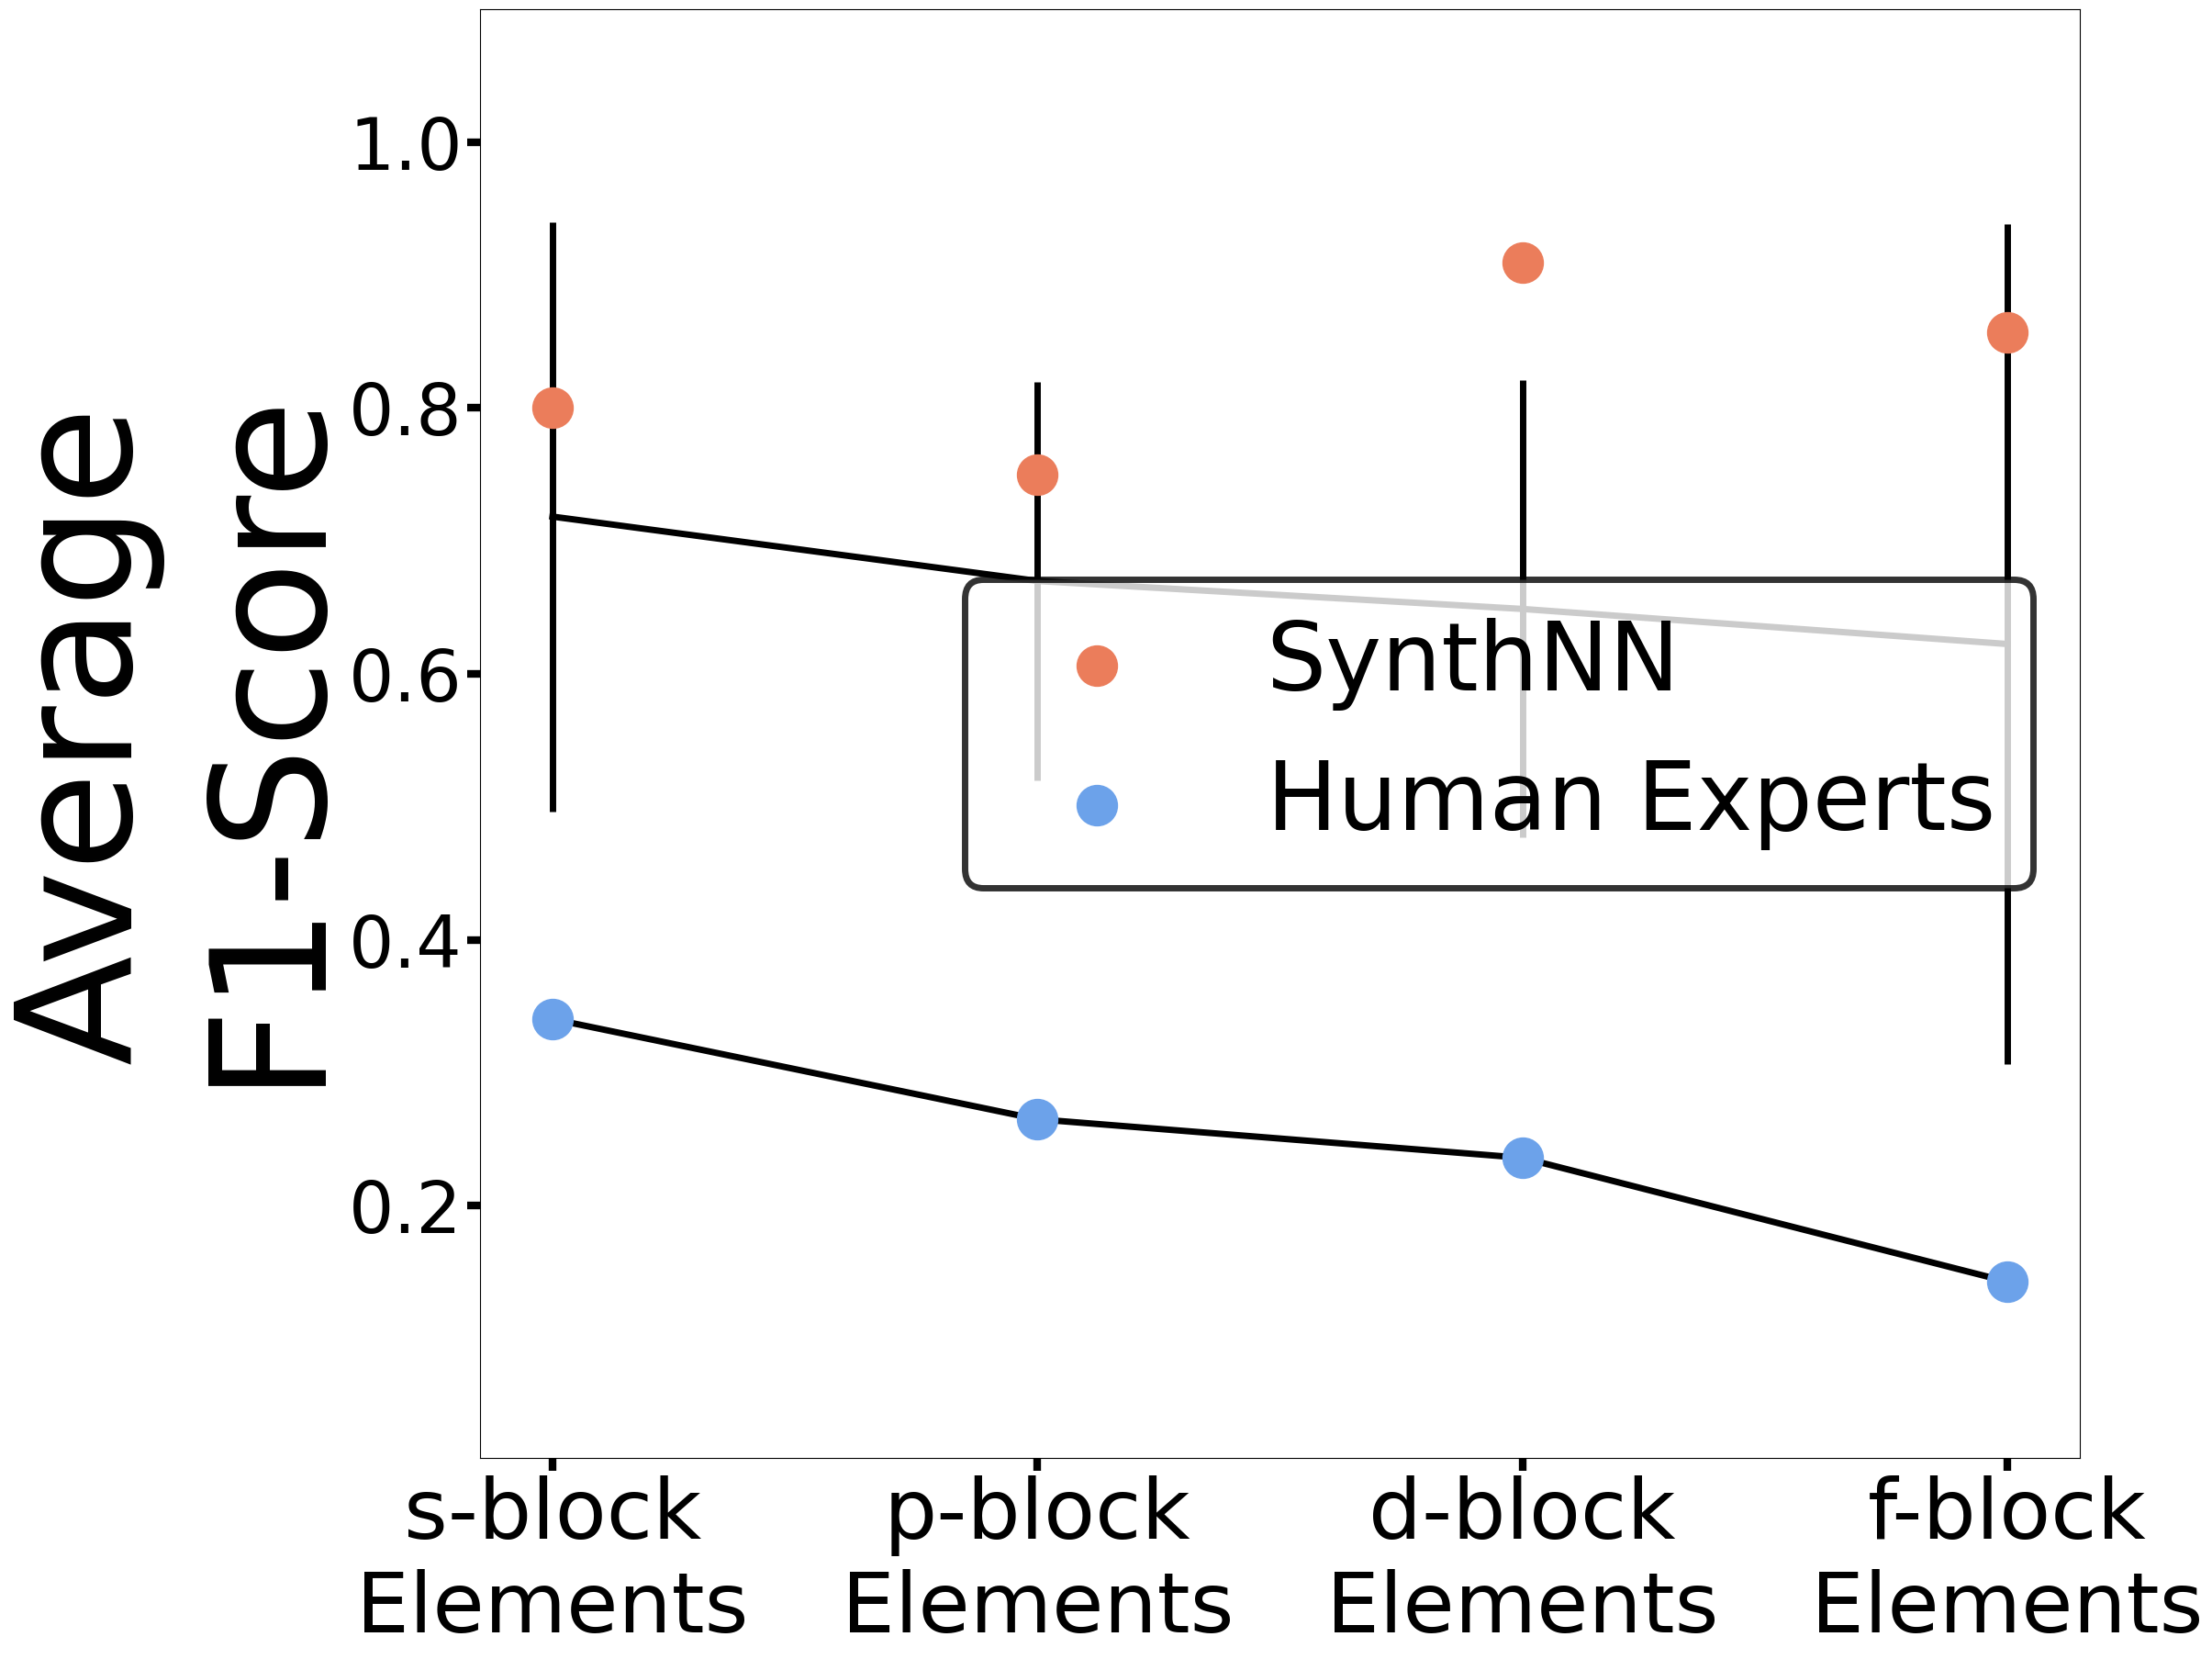

In [10]:
human_results=np.loadtxt('Figure_data/Figure_3/human_results.txt')
synthNN_full_test_set_std_dev=np.loadtxt('Figure_data/Figure_3/synthNN_full_test_set_std_dev.txt')
synthNN_full_test_set_F1=np.loadtxt('Figure_data/Figure_3/synthNN_full_test_set_F1.txt')
synthNN_quiz_F1=np.loadtxt('Figure_data/Figure_3/synthNN_quiz_F1.txt')

plot_marker_size=30
plot_line_width=5
plt.scatter(np.linspace(0,3,4), synthNN_quiz_F1, label='SynthNN', marker='o', s=1000,  color='#EB7D5B', zorder=1)
plt.errorbar(np.linspace(0,3,4), synthNN_full_test_set_F1, markersize=5, linewidth=5, yerr=synthNN_full_test_set_std_dev, color='black', zorder=0)
plt.scatter(np.linspace(0,3,4), human_results,label='Human Experts', s=1000, zorder=1, color='#6CA2EA')
plt.plot(np.linspace(0,3,4), human_results, marker='o', c='black', markersize=0, linewidth=plot_line_width, zorder=0)
plt.xticks([r for r in range(len(human_results))], ['s-block\nElements', 'p-block\nElements', 'd-block\nElements', 'f-block\nElements'], fontsize=56)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
leg=plt.legend(fontsize=74,  loc='right')
leg.get_frame().set_linewidth(5)
leg.get_frame().set_edgecolor("black")
plt.ylabel('Average\nF1-Score', fontsize=126)
plt.tick_params(axis='y', which='major', labelsize=56, width=6, length=10)
plt.tick_params(axis='x', which='major', labelsize=66, width=6, length=10)
plt.ylim(0.01,1.10)
fig = plt.gcf()
fig.set_size_inches(22.5, 20.5)
plt.show()

# Figure 3: Statistical hypothesis testing of SynthNN vs. Hivemind Human

In [101]:

formula_array=np.loadtxt('Figure_data/Figure_3/human_test_set.txt', dtype=str)
np.random.seed(0)
output=np.zeros(100)
results=np.loadtxt('Figure_data/Figure_3/synthesizability_quiz_responses.txt', dtype=str, delimiter=';')
labels_array=np.loadtxt('Figure_data/Figure_3/human_test_set_labels.txt', dtype=int)
for j in range(len(results)):
    for i in range(len(results[j])):
        try:
            answer=int(results[j][i][0:3])
        except:
            try:
                answer=int(results[j][i][0:2])
            except:
                answer=int(results[j][i][0:1])
        output[answer-1]=output[answer-1]+1


data=range(0,100)
correct_answers=np.where(labels_array==1)[0]
true_label_indices=np.where(labels_array==1)[0]
hivemind_results=[]
sample_size=50
x_quiz=get_features(formula_array)
dummy_y_values=np.zeros((len(formula_array),2))
synthNN_quiz_preds=SynthNN_best_model(x_quiz,dummy_y_values,formula_array)[:,0]
synthNN_guesses=np.argsort(-synthNN_quiz_preds)[:9]
formula_array=np.loadtxt('Figure_data/Figure_3/human_test_set.txt', dtype=str)
synthnn_results=[]
hivemind_guesses=np.argsort(-output)[0:9]

for i in range(10):
    bootrstrapped_data=[]
    bootstrapped_data = np.random.choice(data, sample_size)
    num_positives=len(list(set(bootstrapped_data) & set(correct_answers)))
    if(num_positives==0):
        continue
    hivemind_guesses_bootstrap=(list(set(hivemind_guesses) & set(bootstrapped_data)))
    num_correct_answers=len(list(set(hivemind_guesses_bootstrap) & set(correct_answers)))
    hivemind_results.append(num_correct_answers/num_positives)
    
    synthNN_guesses_bootstrap=(list(set(synthNN_guesses) & set(bootstrapped_data)))
    synthnn_num_correct_answers=len(list(set(synthNN_guesses_bootstrap) & set(correct_answers)))
    synthnn_results.append(synthnn_num_correct_answers/num_positives)
    
print(np.mean(hivemind_results),np.std(hivemind_results))
print(np.mean(synthnn_results), np.std(synthnn_results))
scipy.stats.ttest_ind(synthnn_results,hivemind_results)

0.33999999999999997 0.17594190960528863
0.7316666666666667 0.2142752642954592


Ttest_indResult(statistic=4.238000420316892, pvalue=0.0004946639669980712)

# Figure 4: Data Generation

In [3]:
#decade testing table
num_positive=41599
tf.compat.v1.disable_eager_execution()
#NOTE: 1980 means trained on all materials before 1980
for train_decade in ['1980','1990','2000','2010']: 
    values=[]
    neg_pos_ratio=20
    #use correct decade in line below! '1980' gets ALL entries synthesized before 1980s (not just 1980s)
    if(train_decade=='1980'):
        xte,yte,te_data=get_batch_val_1980(neg_pos_ratio)
        preds=get_decade_model_preds(train_decade,te_data)
        recall,threshold=get_recall(preds,yte, precision=5/21)
        print(train_decade  + ' (train decade): '+str(recall))
        values.append(recall)
    elif(train_decade=='1990'):
        xte,yte,te_data=get_batch_val_1990(neg_pos_ratio)
        preds=get_decade_model_preds(train_decade,te_data)
        recall,threshold=get_recall(preds,yte, precision=5/21)
        print(train_decade  + ' (train decade): '+str(recall))
        values.append(recall)
    elif(train_decade=='2000'):
        xte,yte,te_data=get_batch_val_2000(neg_pos_ratio)
        preds=get_decade_model_preds(train_decade,te_data)
        recall,threshold=get_recall(preds,yte, precision=5/21)
        print(train_decade  + ' (train decade): '+str(recall))
        values.append(recall)
    elif(train_decade=='2010'):
        xte,yte,te_data=get_batch_val_2010(neg_pos_ratio)
        preds=get_decade_model_preds(train_decade,te_data)
        recall,threshold=get_recall(preds,yte, precision=5/21)
        print(train_decade  + ' (train decade): '+str(recall))
        values.append(recall)

    #use this for predicting performance on future decades
    for test_decade in ['1980','1990','2000','2010']:
        data_test=np.loadtxt('All_hyperparam_training/icsd_full_data_unique_no_frac_'+test_decade+'_only_nopenta.txt', dtype=str)
        preds=get_decade_model_preds(train_decade,data_test)
        print(test_decade + ': '+ str(len(np.where(preds[:,0]>threshold)[0])/len(data_test)))
        values.append(len(np.where(preds[:,0]>threshold)[0])/len(data_test))
    np.savetxt('Figure_data/Figure_4/'+str(train_decade) + '_recall.txt',values)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
1980 (train decade): 0.726790450928382
1980: 0.7281393534968368
1990: 0.7027050017012589
2000: 0.6897934011717546
2010: 0.6535400938583963
1990 (train decade): 0.8317094774136404
1980: 0.892365022965595
1990: 0.7924464103436543
2000: 0.765340733888375
2010: 0.7006733319730667
2000 (train decade): 0.8248847926267281
1980: 0.8959181904844441
1990: 0.8980945899965975
2000: 0.8181467776749923
2010: 0.7556281031082092
2010 (train decade): 0.852880658436214
1980: 0.8987780570240056
1990: 0.9095780877849609
2000: 0.9010175763182239
2010: 0.7964361014758893


# Figure 4 Plotting

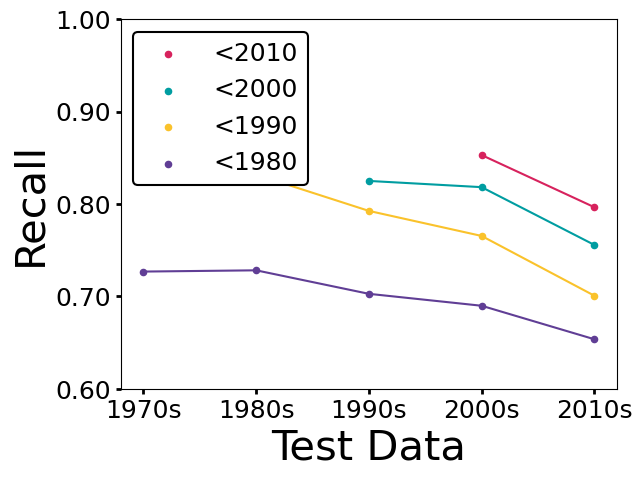

In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

train_decades = ['<' +str(1980 +(10*i)) for i in range(4)]
test_decades = [str(1970 + (10*i)) + 's' for i in range(5) ]
#obtain values from the above block of code
values_2010=np.loadtxt('Figure_data/Figure_4/2010_recall.txt')
values_2000=np.loadtxt('Figure_data/Figure_4/2000_recall.txt')
values_1990=np.loadtxt('Figure_data/Figure_4/1990_recall.txt')
values_1980=np.loadtxt('Figure_data/Figure_4/1980_recall.txt')

fig, ax = plt.subplots()
colors=['#603E95','#FAC22B','#009DA1', '#D7225D' ]

plt.plot(np.linspace(3,4,2),np.append(values_2010[0],values_2010[4:]),color=colors[3])
plt.scatter(np.linspace(3,4,2),np.append(values_2010[0],values_2010[4:]), label='<2010',c=colors[3],s=20)

plt.plot(np.linspace(2,4,3),np.append(values_2000[0],values_2000[3:]),color=colors[2])
plt.scatter(np.linspace(2,4,3),np.append(values_2000[0],values_2000[3:]), label='<2000',c=colors[2],s=20)

plt.plot(np.linspace(1,4,4),np.append(values_1990[0],values_1990[2:]),color=colors[1])
plt.scatter(np.linspace(1,4,4),np.append(values_1990[0],values_1990[2:]), label='<1990',c=colors[1],s=20)

plt.plot(np.linspace(0,4,5),values_1980,color=colors[0])
plt.scatter(np.linspace(0,4,5),values_1980, label='<1980',c=colors[0],s=20)

#plt.legend(fontsize=14)
leg=plt.legend(fontsize=18, framealpha=1)
leg.get_frame().set_linewidth(1.5)
leg.get_frame().set_edgecolor("black")

ax.xaxis.set_ticks(list(np.linspace(0,4,5)))
ax.xaxis.set_ticklabels(['1970s','1980s','1990s','2000s','2010s'],fontsize=18)
ax.yaxis.set_ticks(list(np.linspace(0.60,1,5)))
ax.yaxis.set_ticklabels(['0.60','0.70','0.80','0.90','1.00'],fontsize=18)
#ax.yaxis.set_ticklabels(['<1980','<1990','<2000','<2010'],fontsize=16)
ax.tick_params(axis='x', width=2)
ax.tick_params(axis='y', width=2)
plt.xlabel('Test Data',fontsize=30)
plt.ylabel('Recall', fontsize=30)
plt.ylim(0.6,1.0)

plt.show()

# Figure 5a

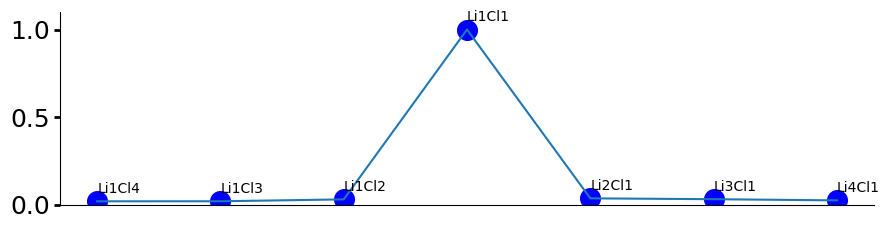

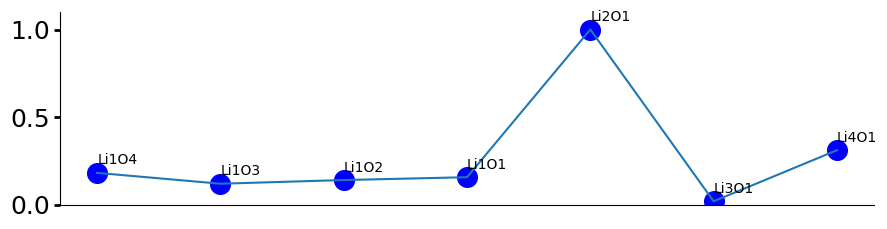

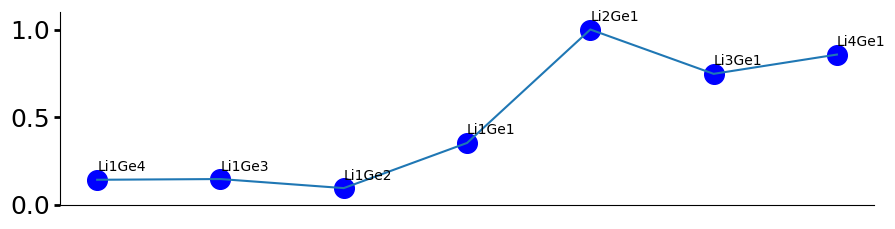

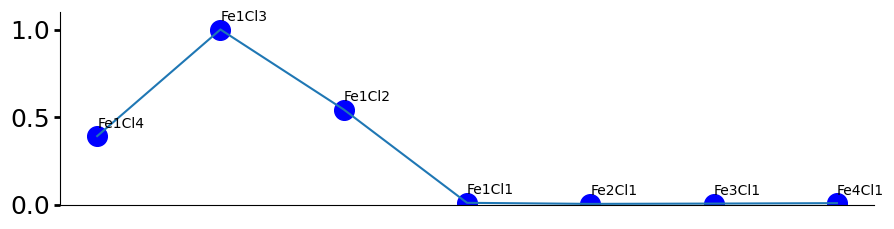

In [12]:
element_pairs=[['Li','Cl'],['Li','O'],['Li','Ge'],['Fe','Cl']]
for elements in element_pairs:
    el1_amounts=[1,1,1,1,2,3,4]
    el2_amounts=[4,3,2,1,1,1,1]
    data_examples=[elements[0] + str(el1_amounts[i]) + elements[1] + str(el2_amounts[i]) for i in range(len(el1_amounts))]
    x_data=get_features(data_examples)
    yval=np.zeros([len(x_data),2])
    preds=SynthNN_best_model(x_data,yval,data_examples)
    #preds=a3.eval(feed_dict={x: x_data, y_: yval , W1:W1_loaded, F1:F1_loaded, F2:F2_loaded, F3:F3_loaded, b1:b1_loaded, b2:b2_loaded, b3:b3_loaded})
    preds_normalized=preds[:,0]/np.max(preds[:,0])
    plt.plot(np.linspace(0,len(preds_normalized)-1,len(preds_normalized)),preds_normalized)
    for i in range(len(preds)):
        plt.scatter(i,preds_normalized[i],c='b',s=200)
        plt.annotate(elements[0] + str(el1_amounts[i]) + elements[1] + str(el2_amounts[i]), [i,preds_normalized[i]+0.05], c='black')
    #plt.ylabel('Normalized \n Synthesizability Prediction', fontsize=26)
    #plt.xlabel('Composition',fontsize=26)
    plt.ylim(0,1.1)
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([0,0.50,1.00])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig = plt.gcf()
    fig.set_size_inches(10.5, 2.5)
    plt.tick_params(axis='y', which='major', labelsize=18, width=2, length=4)
    plt.show()

# Figure 5b Data Generation

In [8]:
from sklearn.manifold import TSNE
form_energy_data=np.loadtxt('All_hyperparam_training/30M/icsd_full_data_unique_no_frac_no_penta_2020.txt',dtype=str)
fake_data=np.loadtxt('All_hyperparam_training/standard_neg_ex_tr_val_v5_balanced_shuffled.txt',dtype=str)
element_of_interest='Li'
#interesting_Li=[element_of_interest + element for element in element_names_array]
seed=1
test_data=[]
for i in range(len(form_energy_data)):
    comp=Composition(form_energy_data[i])
    if('Li' in comp and len(comp)<4):
        test_data.append(form_energy_data[i])
num_synth_entries=len(test_data)

interesting_synth=['Ge1Li1','Li1Pt7','Li4Si1','Li1Si1','Li2Si1', 'Li2S1',
                   'Li1Pd7', 'Li1Pd3',
                   'C3Li8','Ge12Li7','C1Li6',
                   'Li2Se1', 'Li1O2','Li3N1', 
                  'Cl1Li1','Br1Li1','Li2O2',]
interesting_unsynth=['Li1N2','Li3S1',
                     'Li3Se1', 
                     'Li1Pt5', 'Li1Pd5','Cl2Li1','Br3Li1','Br2Li1']
#interesting_synth2=['LiO3','LiO2','LiO','Li2O','Li3O']
#interesting_unsynth2=['LiCl4']
for i in range(len(interesting_synth)):
        test_data.append(interesting_synth[i])
for i in range(len(interesting_unsynth)):
        test_data.append(interesting_unsynth[i])      
num_fake_entries=len(interesting_synth) + len(interesting_unsynth)
num_data_points=len(test_data)

#interesting_Li=test_data
perplexities = [5, 30, 50, 100]
#test_data=test_data[50:100]
num_positive=41599
tf.compat.v1.disable_eager_execution()
M =30
DIR='../Atom2Vec_sherlock/Decade_testing_v4/' +str(M) + 'M/20/'
for name in os.listdir(DIR):
    if(name.endswith('.txt')):
        if(name.startswith('performance_matrix_TL_v3_' + str(M) + 'M_14112')):
            hyperparams=[name[-9],name[-8],name[-7],name[-6],name[-5]]
            hyperparams=np.array(hyperparams, dtype=int)
            no_h1=[30,40,50,60,80][hyperparams[1]]
            no_h2=[30,40,50,60,80][hyperparams[2]]
            batch_size = 64
            xtr,ytr,batch_data,weights,idxs=get_batch(batch_size, neg_positive_ratio=20, use_semi_weights=False, model_name='test')
            x = tf.compat.v1.placeholder(tf.float32, shape=[None, xtr.shape[1]])
            y_ = tf.compat.v1.placeholder(tf.float32, shape=[None, 2])
            W1=tf.compat.v1.placeholder(tf.float32, shape=[xtr.shape[1],M]) #if loading in weights for TL
            F1 = tf.compat.v1.placeholder(tf.float32, shape=[M,no_h1])
            F2 = tf.compat.v1.placeholder(tf.float32, shape=[no_h1,no_h2])
            F3 = tf.compat.v1.placeholder(tf.float32, shape=[no_h2,2])
            b1 = tf.compat.v1.placeholder(tf.float32, shape=[no_h1])
            b2 = tf.compat.v1.placeholder(tf.float32, shape=[no_h2])
            b3 = tf.compat.v1.placeholder(tf.float32, shape=[2])
            sess = tf.compat.v1.InteractiveSession()
            sess.run(tf.compat.v1.initialize_all_variables())
            z0_raw = tf.multiply(tf.expand_dims(x,2),tf.expand_dims(W1,0)) #(ntr, I, M)
            tempmean,var = tf.nn.moments(x=z0_raw,axes=[1])
            z0 = tf.concat([tf.reduce_sum(input_tensor=z0_raw,axis=1)],1) #(ntr, M)
            z1 = tf.add(tf.matmul(z0,F1),b1) #(ntr, no_h1)
            a1 = tf.tanh(z1) #(ntr, no_h1)
            z2= tf.add(tf.matmul(a1,F2),b2) #(ntr,no_h1)
            a2= tf.tanh(z2) #(ntr, no_h1)
            z3 = tf.add(tf.matmul(a2,F3),b3) #(ntr, 2)
            a3 = tf.nn.softmax(z3) #(ntr, 2)
            clipped_y = tf.clip_by_value(a3, 1e-10, 1.0)
            cross_entropy = -tf.reduce_sum(input_tensor=y_*tf.math.log(clipped_y)*np.array([weight_for_1,weight_for_0]))
            correct_prediction = tf.equal(tf.argmax(input=a3,axis=1), tf.argmax(input=y_,axis=1))
            accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
            sess.run(tf.compat.v1.initialize_all_variables())
            model_name=str(M) + 'M_synth_v3_semi' + str(hyperparams[0]) + str(hyperparams[1])+ str(hyperparams[2])+ str(hyperparams[3])+ str(hyperparams[4])  +'.txt'
            directory=DIR + '/'
            W1_loaded=np.loadtxt(directory + 'W1_' + model_name) #load weights if doing TL HERE!!
            F1_loaded=np.loadtxt(directory + 'F1_' + model_name) #load weights if doing TL HERE!!
            F2_loaded=np.loadtxt(directory + 'F2_' + model_name) #load weights if doing TL HERE!!
            F3_loaded=np.loadtxt(directory + 'F3_' + model_name) #load weights if doing TL HERE!!
            F3_loaded=np.reshape(F3_loaded, [no_h2,2])
            b1_loaded=np.loadtxt(directory + 'b1_' + model_name) #load weights if doing TL HERE!!
            b2_loaded=np.loadtxt(directory + 'b2_' + model_name) #load weights if doing TL HERE!!
            b3_loaded=np.loadtxt(directory + 'b3_' + model_name) #load weights if doing TL HERE!!
            b3_loaded=np.reshape(b3_loaded, [2])
x_data=get_features(test_data)
yval=np.zeros([len(x_data),2])

embeddings0=z0.eval(feed_dict={x: x_data, y_: yval , W1:W1_loaded, F1:F1_loaded, F2:F2_loaded, F3:F3_loaded, b1:b1_loaded, b2:b2_loaded, b3:b3_loaded})
tsne_data0 = TSNE(n_components=2, random_state=seed,perplexity=perplexities[2]).fit_transform(embeddings0)
print('done 0')
embeddings1=z1.eval(feed_dict={x: x_data, y_: yval , W1:W1_loaded, F1:F1_loaded, F2:F2_loaded, F3:F3_loaded, b1:b1_loaded, b2:b2_loaded, b3:b3_loaded})
tsne_data1 = TSNE(n_components=2, random_state=seed,perplexity=perplexities[2]).fit_transform(embeddings1)
print('done 1')
embeddings2=z2.eval(feed_dict={x: x_data, y_: yval , W1:W1_loaded, F1:F1_loaded, F2:F2_loaded, F3:F3_loaded, b1:b1_loaded, b2:b2_loaded, b3:b3_loaded})
tsne_data2 = TSNE(n_components=2, random_state=seed,perplexity=perplexities[2]).fit_transform(embeddings2)
print('done 2')
embeddings3=z3.eval(feed_dict={x: x_data, y_: yval , W1:W1_loaded, F1:F1_loaded, F2:F2_loaded, F3:F3_loaded, b1:b1_loaded, b2:b2_loaded, b3:b3_loaded})
tsne_data3 = TSNE(n_components=2, random_state=seed,perplexity=perplexities[2]).fit_transform(embeddings3)
print('done 3')
interesting_indices=range(num_synth_entries,len(test_data))
start_index,end_index=0,num_fake_entries
tsne_data0_plot=tsne_data0[interesting_indices]
tsne_data1_plot=tsne_data1[interesting_indices]
tsne_data2_plot=tsne_data2[interesting_indices]
tsne_data3_plot=tsne_data3[interesting_indices]
np.savetxt('Figure_data/Figure_5/tsne_data0.txt',tsne_data0_plot)
np.savetxt('Figure_data/Figure_5/tsne_data1.txt',tsne_data1_plot)
np.savetxt('Figure_data/Figure_5/tsne_data2.txt',tsne_data2_plot)
np.savetxt('Figure_data/Figure_5/tsne_data3.txt',tsne_data3_plot)
np.savetxt('Figure_data/Figure_5/plotting_formulas.txt',np.array(test_data)[list(interesting_indices)],fmt='%s')

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


done 0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


done 1


/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


done 2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


done 3


# Figure 5b Plotting


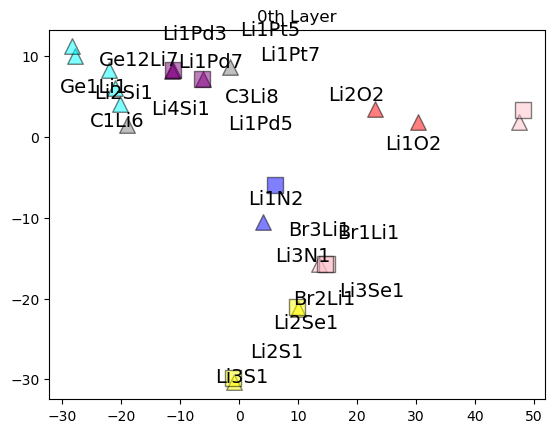

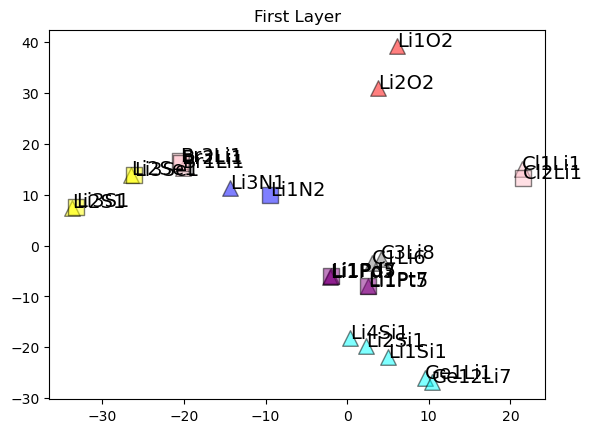

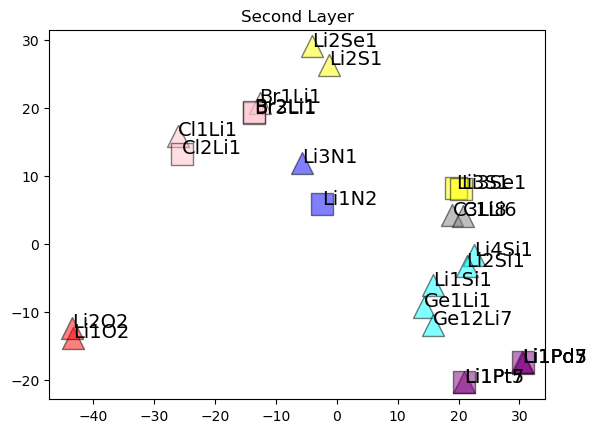

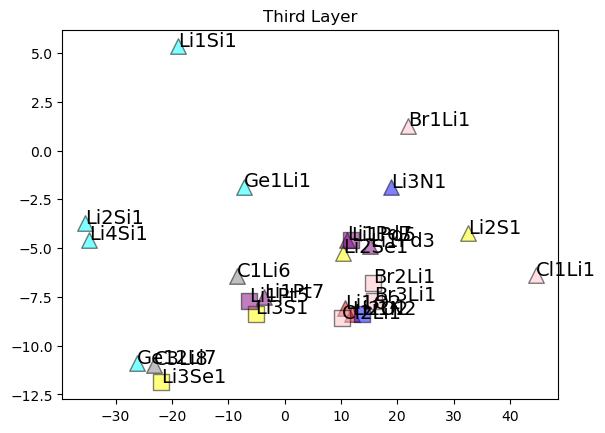

In [13]:
tsne_data0_plot=np.loadtxt('Figure_data/Figure_5/tsne_data0.txt')
tsne_data1_plot=np.loadtxt('Figure_data/Figure_5/tsne_data1.txt')
tsne_data2_plot=np.loadtxt('Figure_data/Figure_5/tsne_data2.txt')
tsne_data3_plot=np.loadtxt('Figure_data/Figure_5/tsne_data3.txt')
plotting_formula=np.loadtxt('Figure_data/Figure_5/plotting_formulas.txt',dtype=str)

labelsize=14
highlighted_entry=30 #if want to max a particular index larger..

interesting_synth=17 #number of synthesized entries in the list; i.e. first 17 are synthesized
for i in range(len(plotting_formula)):
    test_dict=Composition(plotting_formula[i]).as_dict()
    del test_dict['Li']
    other_element=''
    for key in test_dict.keys():
        other_element=key
    if(i<interesting_synth):
        color=get_element_type_color(other_element)
        plt.scatter(tsne_data0_plot[i][0],tsne_data0_plot[i][1], c=color,s=125,alpha=0.5,edgecolor='black',marker='^')
        plt.annotate(plotting_formula[i], tsne_data0_plot[i]+5*np.array([np.random.normal(),np.random.normal()]),fontsize=labelsize)
    else:
        color=get_element_type_color(other_element)
        plt.scatter(tsne_data0_plot[i][0],tsne_data0_plot[i][1], c=color,s=125,alpha=0.5,marker='s',edgecolor='black')
        plt.annotate(plotting_formula[i], tsne_data0_plot[i]+5*np.array([np.random.normal(),np.random.normal()]),fontsize=labelsize)
plt.title('0th Layer')
plt.show()
for i in range(len(plotting_formula)):
    test_dict=Composition(plotting_formula[i]).as_dict()
    del test_dict['Li']
    other_element=''
    for key in test_dict.keys():
        other_element=key
    if(i<interesting_synth):
        color=get_element_type_color(other_element)
        plt.scatter(tsne_data1_plot[i][0],tsne_data1_plot[i][1], c=color,s=125,alpha=0.5,edgecolor='black',marker='^')
        plt.annotate(plotting_formula[i], [tsne_data1_plot[i][0],tsne_data1_plot[i][1]],fontsize=labelsize)
    else:
        color=get_element_type_color(other_element)
        plt.scatter(tsne_data1_plot[i][0],tsne_data1_plot[i][1], c=color,marker='s',s=125,alpha=0.5,edgecolor='black')
        plt.annotate(plotting_formula[i], [tsne_data1_plot[i][0],tsne_data1_plot[i][1]],fontsize=labelsize)
plt.title('First Layer')
plt.show()
for i in range(len(plotting_formula)):
    test_dict=Composition(plotting_formula[i]).as_dict()
    del test_dict['Li']
    other_element=''
    for key in test_dict.keys():
        other_element=key
    if(i<interesting_synth):
        color=get_element_type_color(other_element)
        labelsize=14
        markersize=250
        if(i==highlighted_entry):
            labelsize=24
            markersize=250
            plt.annotate(plotting_formula[i], [tsne_data2_plot[i][0],tsne_data2_plot[i][1]],fontsize=labelsize)
        plt.scatter(tsne_data2_plot[i][0],tsne_data2_plot[i][1], c=color,s=markersize,alpha=0.5,edgecolor='black',marker='^')
        plt.annotate(plotting_formula[i], [tsne_data2_plot[i][0],tsne_data2_plot[i][1]],fontsize=labelsize)
    else:
        color=get_element_type_color(other_element)
        plt.scatter(tsne_data2_plot[i][0],tsne_data2_plot[i][1], c=color,marker='s',s=markersize,alpha=0.5,edgecolor='black')
        plt.annotate(plotting_formula[i], [tsne_data2_plot[i][0],tsne_data2_plot[i][1]],fontsize=labelsize)
plt.title('Second Layer')
plt.show()
fig, ax = plt.subplots(1)
for i in range(len(plotting_formula)):
    test_dict=Composition(plotting_formula[i]).as_dict()
    del test_dict['Li']
    other_element=''
    for key in test_dict.keys():
        other_element=key
    if(i<interesting_synth):
        color=get_element_type_color(other_element)
        plt.scatter(tsne_data3_plot[i][0],tsne_data3_plot[i][1], c=color,s=125,alpha=0.5,edgecolor='black',marker='^')
        plt.annotate(plotting_formula[i], [tsne_data3_plot[i][0],tsne_data3_plot[i][1]],fontsize=labelsize)
    else:
        color=get_element_type_color(other_element)
        plt.scatter(tsne_data3_plot[i][0],tsne_data3_plot[i][1], c=color,s=125,alpha=0.5,marker='s',edgecolor='black')
        plt.annotate(plotting_formula[i], [tsne_data3_plot[i][0],tsne_data3_plot[i][1]],fontsize=labelsize)

plt.title('Third Layer')
plt.show()

# Table S1 Data Generation

In [10]:
#hyperparameter testing for Table S1 performance
from numpy import trapz
num_positive=41599
tf.compat.v1.disable_eager_execution()
hyperparameter_string='' #can enter string here of model of choice; ex. hyperparameter_string='14000'
nsynth_train=20 #Nsynth used in training the model
nsynth_val=20 #Nsynth of the validation set
nsynth_test=20 #Nsynth of the test set
for M in [2,6,10,15,20,25,30]:
    best_auc=0
    best_file=''
    results=[]
    DIR='All_hyperparam_training/' +str(M) + 'M/' + str(nsynth_train) +'/'
    for name in os.listdir(DIR):
        if(name.endswith('.txt')):
            if(name.startswith('performance_matrix_TL_v3_' + str(M) + 'M_' + hyperparameter_string)):
                xval,yval,val_data=get_batch_val(nsynth_val)
                xte,yte,te_data=get_batch_test(nsynth_test)
                #preds=a3.eval(feed_dict={x: xte, y_: yte , W1:W1_loaded, F1:F1_loaded, F2:F2_loaded, F3:F3_loaded, b1:b1_loaded, b2:b2_loaded, b3:b3_loaded})
                preds=get_model_preds(M,nsynth_train,name[-9:-4],te_data)
                TP, FP, TN, FN=perf_measure(np.array(yte)[:,0],np.array(preds)[:,0])
                #print('Te Recall:' + str(TP/(TP+FN)) + ' Te prec:' + str(TP/(TP+FP)))
                
                perf_matrix=[]
                preds=get_model_preds(M,nsynth_train,name[-9:-4],val_data)
                for i in range(100):
                    #preds=a3.eval(feed_dict={x: xval, y_: yval , W1:W1_loaded, F1:F1_loaded, F2:F2_loaded, F3:F3_loaded, b1:b1_loaded, b2:b2_loaded, b3:b3_loaded})
                    TP, FP, TN, FN=perf_measure(np.array(yval)[:,0],np.array(preds)[:,0], cutoff=i/100)
                    if(TP>0):
                        perf_matrix.append([TP/(TP+FP), TP/(TP+FN)])
                perf_matrix=np.array(perf_matrix)
                data_400000=[]
                for recall in np.linspace(0,1,100):
                    data_400000.append(perf_matrix[:,0][np.argmin(np.abs(recall-perf_matrix[:,1]))])
                area = trapz(data_400000, dx=0.01)
                if(area>best_auc):
                    best_auc=area
                    best_file=name
                print(name + " area =", area)
                results.append([name,area])
                #np.savetxt('Figure_data/Table_s1/results_' + str(nsynth_train) + '_' + str(nsynth_val) + '.txt',results,fmt='%s')
    print('Done: ' + best_file + str(best_auc))
    results.append([best_file,best_auc])
    np.savetxt('Figure_data/Table_s1/results_' +str(M) + 'M_' + str(nsynth_train) + '_' + str(nsynth_val) + '.txt',results,fmt='%s')

Instructions for updating:
Use `tf.global_variables_initializer` instead.
performance_matrix_TL_v3_2M_44404.txt area = 0.2332916069118422
performance_matrix_TL_v3_2M_02243.txt area = 0.33036236054061296
performance_matrix_TL_v3_2M_22420.txt area = 0.2316373005643686
performance_matrix_TL_v3_2M_42302.txt area = 0.30281287639548476
performance_matrix_TL_v3_2M_11013.txt area = 0.30266774513054734
performance_matrix_TL_v3_2M_13411.txt area = 0.33600701570824376
performance_matrix_TL_v3_2M_31211.txt area = 0.2778574755682676
performance_matrix_TL_v3_2M_24032.txt area = 0.33773826497302323
performance_matrix_TL_v3_2M_22333.txt area = 0.08321039570462775
performance_matrix_TL_v3_2M_44303.txt area = 0.23796131914558805
performance_matrix_TL_v3_2M_04044.txt area = 0.30896712495042555
performance_matrix_TL_v3_2M_41122.txt area = 0.24665943973232402
performance_matrix_TL_v3_2M_01442.txt area = 0.31507573863709826
performance_matrix_TL_v3_2M_41113.txt area = 0.2855623601916534
performance_matrix_T

# Table S1 Data Generation

In [100]:
#make prec/recall curves for best performing models for each entry in Table S1
DIR='Figure_data/Table_s1/'

for name in os.listdir(DIR):
    M,nsynth_train=name.split('_')[1],name.split('_')[2]
    M=int(M.replace('M',''))
    
    #only save the M=30 models
    if(M!=30):
        continue
    with open(DIR+name) as f:
        for line in f:
            pass
        last_line = line
    f.close()
    best_file_name=last_line.split(' ')[0]
    print(best_file_name)
    for nsynth_val in [5,10,15,20]:
        xval,yval,val_data=get_batch_val(nsynth_val)
        preds=get_model_preds(M,nsynth_train,best_file_name[-9:-4],val_data)
        perf_matrix=[]
        for i in range(100):
            #preds=a3.eval(feed_dict={x: xval, y_: yval , W1:W1_loaded, F1:F1_loaded, F2:F2_loaded, F3:F3_loaded, b1:b1_loaded, b2:b2_loaded, b3:b3_loaded})
            TP, FP, TN, FN=perf_measure(np.array(yval)[:,0],np.array(preds)[:,0], cutoff=i/100)
            if(TP>0):
                perf_matrix.append([TP/(TP+FP), TP/(TP+FN)])
        perf_matrix=np.array(perf_matrix)
        data_400000=[]
        for recall in np.linspace(0,1,100):
            data_400000.append(perf_matrix[:,0][np.argmin(np.abs(recall-perf_matrix[:,1]))])
        np.savetxt('Figure_data/PR_curves/'+str(M) + 'M_' + str(nsynth_train) + '_' + str(nsynth_val) + '.txt',data_400000)

performance_matrix_TL_v3_30M_13243.txt


/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


performance_matrix_TL_v3_30M_14112.txt
performance_matrix_TL_v3_30M_14000.txt
performance_matrix_TL_v3_30M_14134.txt


# Figure S1; plotting training ratio values for different validation ratios

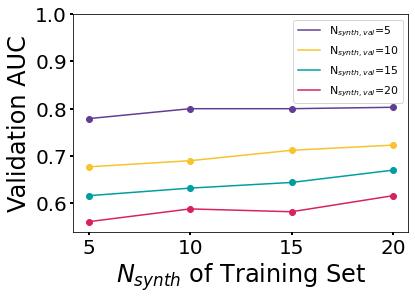

In [3]:
data_full=[]

for val_set_ratio in [5,10,15,20]:
    data=[]
    for train_set_ratio in [5,10,15,20]:
        data_400000_20=np.loadtxt('Figure_data/PR_curves/30M_'+str(train_set_ratio) + '_' + str(val_set_ratio) + '.txt')
        data.append((np.round(trapz(data_400000_20, dx=0.01),decimals=3)))
    data_full.append(data)
colors=['#603E95','#FAC22B','#009DA1', '#D7225D' ]
labels=['N$_{synth,val}$=5','N$_{synth,val}$=10','N$_{synth,val}$=15','N$_{synth,val}$=20']
for i in range(4):
    plt.plot(np.linspace(5,20,4),data_full[i],label=labels[i],color=colors[i])
    plt.scatter(np.linspace(5,20,4),data_full[i],c=colors[i])
plt.ylim(0.54,1)
plt.ylabel('Validation AUC',fontsize=24)
plt.xlabel('$N_{synth}$ of Training Set',fontsize=24)
plt.legend(fontsize=11)
plt.tick_params(axis='y', which='major', labelsize=20, width=2, length=3)
plt.tick_params(axis='x', which='major', labelsize=20, width=2, length=3)
plt.show()

# Figure S2 Figure Plotting

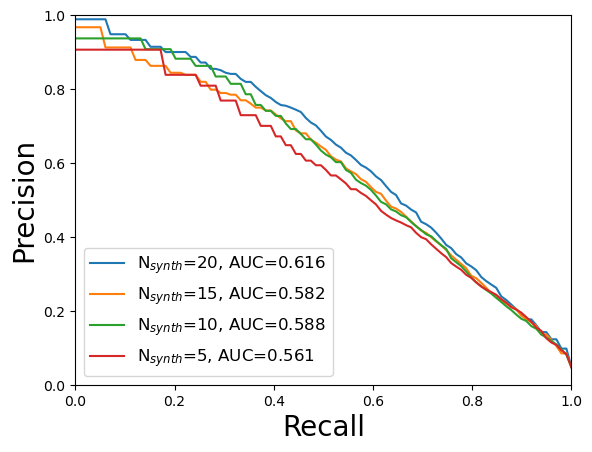

In [14]:
#plot for comparing the prec/recall curves with M=30 for different values of Nsynth
val_set_ratio=20
data_400000_20=np.loadtxt('Figure_data/PR_curves/30M_20_' + str(val_set_ratio) + '.txt')
data_400000_15=np.loadtxt('Figure_data/PR_curves/30M_15_' + str(val_set_ratio) + '.txt')
data_400000_10=np.loadtxt('Figure_data/PR_curves/30M_10_' + str(val_set_ratio) + '.txt')
data_400000_5=np.loadtxt('Figure_data/PR_curves/30M_5_' + str(val_set_ratio) + '.txt')

plt.plot(np.linspace(0,1,100),data_400000_20, label=r'N$_{synth}$=20, AUC=' +str(np.round(trapz(data_400000_20, dx=0.01),decimals=3)))
plt.plot(np.linspace(0,1,100),data_400000_15, label=r'N$_{synth}$=15, AUC='+str(np.round(trapz(data_400000_15, dx=0.01),decimals=3)))
plt.plot(np.linspace(0,1,100),data_400000_10, label=r'N$_{synth}$=10, AUC='+str(np.round(trapz(data_400000_10, dx=0.01),decimals=3)))
plt.plot(np.linspace(0,1,100),data_400000_5, label=r'N$_{synth}$=5, AUC='+str(np.round(trapz(data_400000_5, dx=0.01),decimals=3)))
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.legend(fontsize=12)
plt.ylim(0,1)
plt.xlim(0,1)
plt.show()

# Figure S3 Figure Plotting

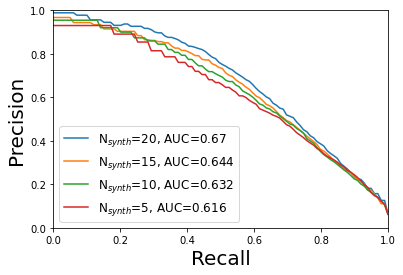

In [5]:
val_set_ratio=15
data_400000_20=np.loadtxt('Figure_data/PR_curves/30M_20_' + str(val_set_ratio) + '.txt')
data_400000_15=np.loadtxt('Figure_data/PR_curves/30M_15_' + str(val_set_ratio) + '.txt')
data_400000_10=np.loadtxt('Figure_data/PR_curves/30M_10_' + str(val_set_ratio) + '.txt')
data_400000_5=np.loadtxt('Figure_data/PR_curves/30M_5_' + str(val_set_ratio) + '.txt')

plt.plot(np.linspace(0,1,100),data_400000_20, label=r'N$_{synth}$=20, AUC=' +str(np.round(trapz(data_400000_20, dx=0.01),decimals=3)))
plt.plot(np.linspace(0,1,100),data_400000_15, label=r'N$_{synth}$=15, AUC='+str(np.round(trapz(data_400000_15, dx=0.01),decimals=3)))
plt.plot(np.linspace(0,1,100),data_400000_10, label=r'N$_{synth}$=10, AUC='+str(np.round(trapz(data_400000_10, dx=0.01),decimals=3)))
plt.plot(np.linspace(0,1,100),data_400000_5, label=r'N$_{synth}$=5, AUC='+str(np.round(trapz(data_400000_5, dx=0.01),decimals=3)))
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.legend(fontsize=12)
plt.ylim(0,1)
plt.xlim(0,1)
plt.show()

# Figure S4 Figure Plotting

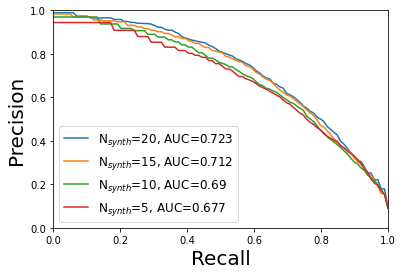

In [15]:
val_set_ratio=10
data_400000_20=np.loadtxt('Figure_data/PR_curves/30M_20_' + str(val_set_ratio) + '.txt')
data_400000_15=np.loadtxt('Figure_data/PR_curves/30M_15_' + str(val_set_ratio) + '.txt')
data_400000_10=np.loadtxt('Figure_data/PR_curves/30M_10_' + str(val_set_ratio) + '.txt')
data_400000_5=np.loadtxt('Figure_data/PR_curves/30M_5_' + str(val_set_ratio) + '.txt')

plt.plot(np.linspace(0,1,100),data_400000_20, label=r'N$_{synth}$=20, AUC=' +str(np.round(trapz(data_400000_20, dx=0.01),decimals=3)))
plt.plot(np.linspace(0,1,100),data_400000_15, label=r'N$_{synth}$=15, AUC='+str(np.round(trapz(data_400000_15, dx=0.01),decimals=3)))
plt.plot(np.linspace(0,1,100),data_400000_10, label=r'N$_{synth}$=10, AUC='+str(np.round(trapz(data_400000_10, dx=0.01),decimals=3)))
plt.plot(np.linspace(0,1,100),data_400000_5, label=r'N$_{synth}$=5, AUC='+str(np.round(trapz(data_400000_5, dx=0.01),decimals=3)))
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.legend(fontsize=12)
plt.ylim(0,1)
plt.xlim(0,1)
plt.show()

# Figure S5 Figure Plotting

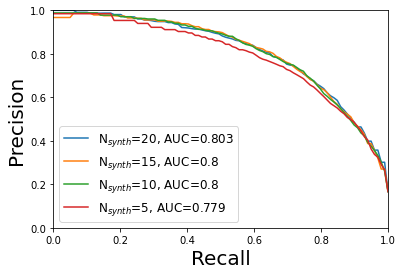

In [6]:
val_set_ratio=5
data_400000_20=np.loadtxt('Figure_data/PR_curves/30M_20_' + str(val_set_ratio) + '.txt')
data_400000_15=np.loadtxt('Figure_data/PR_curves/30M_15_' + str(val_set_ratio) + '.txt')
data_400000_10=np.loadtxt('Figure_data/PR_curves/30M_10_' + str(val_set_ratio) + '.txt')
data_400000_5=np.loadtxt('Figure_data/PR_curves/30M_5_' + str(val_set_ratio) + '.txt')

plt.plot(np.linspace(0,1,100),data_400000_20, label=r'N$_{synth}$=20, AUC=' +str(np.round(trapz(data_400000_20, dx=0.01),decimals=3)))
plt.plot(np.linspace(0,1,100),data_400000_15, label=r'N$_{synth}$=15, AUC='+str(np.round(trapz(data_400000_15, dx=0.01),decimals=3)))
plt.plot(np.linspace(0,1,100),data_400000_10, label=r'N$_{synth}$=10, AUC='+str(np.round(trapz(data_400000_10, dx=0.01),decimals=3)))
plt.plot(np.linspace(0,1,100),data_400000_5, label=r'N$_{synth}$=5, AUC='+str(np.round(trapz(data_400000_5, dx=0.01),decimals=3)))
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.legend(fontsize=12)
plt.ylim(0,1)
plt.xlim(0,1)
plt.show()

# Figure S6 Plotting

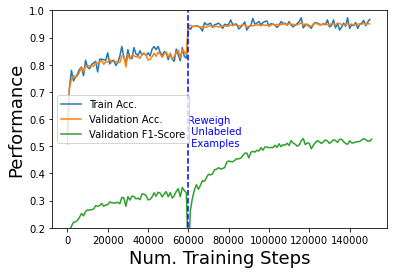

In [119]:
pretraining_curve=np.loadtxt('Figure_data/Figure_s6/performance_matrix_TL_v3_pretrain1411.txt',dtype=float)
training_curve=np.loadtxt('Figure_data/Figure_s6/performance_matrix_TL_v3_30M_14112.txt',dtype=float)

train_acc_array=np.append(pretraining_curve[:,0],training_curve[1:][:,0])
val_acc_array=np.append(pretraining_curve[:,1],training_curve[1:][:,1])

#prec/recall arrays
prec_array_pretraining=pretraining_curve[:,2]/(pretraining_curve[:,2]+pretraining_curve[:,3])
recall_array_pretraining=pretraining_curve[:,2]/(pretraining_curve[:,2]+pretraining_curve[:,5])
prec_array_training=training_curve[:,2]/(training_curve[:,2]+training_curve[:,3])
recall_array_training=training_curve[:,2]/(training_curve[:,2]+training_curve[:,5])
recall_array=np.append(recall_array_pretraining,recall_array_training)
precision_array=np.append(prec_array_pretraining,prec_array_training)
F1_array=(2*precision_array*recall_array)/(precision_array+recall_array)


#TP,FP,TN,FN
plt.plot(np.linspace(0,1000*(len(train_acc_array)-1),len(train_acc_array)),train_acc_array,label='Train Acc.')
plt.plot(np.linspace(0,1000*(len(val_acc_array)-1),len(val_acc_array)),val_acc_array,label='Validation Acc.')
plt.xlabel('Num. Training Steps',fontsize=18)
plt.ylabel('Performance',fontsize=18)

#plt.plot(np.linspace(0,1000*(len(recall_array)-1),len(recall_array)),recall_array,label='Validation Recall')
#plt.plot(np.linspace(0,1000*(len(precision_array)-1),len(precision_array)),precision_array,label='Validation Precision')
plt.plot(np.linspace(0,1000*(len(F1_array)-1),len(F1_array)),F1_array,label='Validation F1-Score')
plt.annotate('Reweigh \n Unlabeled \n Examples',[60000,0.5],c='b')

plt.legend(loc='center left')

plt.plot(np.linspace(60000,60000,10),np.linspace(0,1,10),c='b',linestyle='--')
plt.ylim(0.2,1.0)
plt.show()

# Table S4 Data Generation

In [15]:
# Table S4
data=np.loadtxt('icsd_full_data_unique_no_frac_no_penta_2020.txt',dtype=str)
counter=0
output=[]
for i in range(len(data)):
    formula=mg.core.composition.Composition(data[i])
    if('Cs' in formula and len(formula)==2):
        print(data[i], balanced_frac([data[i]],ox_dict=common_ox_dict))
        output.append([data[i], balanced_frac([data[i]],ox_dict=common_ox_dict)])
        counter=counter+1
print(counter)
np.savetxt('Figure_data/Table_s4/Cs_binary_output.txt',output,fmt='%s')

Br3Cs1 ['False', 'None']
Cs11O3 ['False', 'None']
Bi1Cs1 ['False', 'None']
Cs4Ge9 ['False', 'None']
As1Cs3 ['True', {'As': -3.0, 'Cs': 1.0}]
Cs2Te1 ['True', {'Cs': 1.0, 'Te': -2.0}]
C60Cs6 ['False', 'None']
Cs3Sb7 ['False', 'None']
Cs2Hg27 ['False', 'None']
Cs1Sb1 ['False', 'None']
Cs1K2 ['False', 'None']
Cs2S5 ['False', 'None']
Cs1Rb1 ['False', 'None']
Cs4O1 ['False', 'None']
Cs2Pt1 ['False', 'None']
Cs4P6 ['False', 'None']
Cs3P7 ['False', 'None']
Cs1Ge1 ['False', 'None']
Cs1Te4 ['False', 'None']
Cs4Te28 ['False', 'None']
Cs2Se1 ['True', {'Cs': 1.0, 'Se': -2.0}]
Cs5Sb8 ['False', 'None']
Cs7O1 ['False', 'None']
Cs2In3 ['False', 'None']
Cs1Ga7 ['False', 'None']
Cs4Se16 ['False', 'None']
Cs2S6 ['False', 'None']
Cs2Xe1 ['False', 'None']
Cs3Te22 ['False', 'None']
Cs1N3 ['False', 'None']
Cs2Te2 ['False', 'None']
Cs1P7 ['False', 'None']
Cs1Ga3 ['False', 'None']
Cs1F1 ['True', {'Cs': 1.0, 'F': -1.0}]
Cs3O1 ['False', 'None']
Cs52Sn82 ['False', 'None']
Cd13Cs1 ['False', 'None']
Cs6K7 ['False', 

# Figure S8 Data Generation

In [24]:
def get_average_coeff(data):
    coeffs=[]
    for entry in data:
        coeffs.append(np.mean(list(mg.core.Composition(entry).as_dict().values())))
    return np.mean(coeffs)
data1=np.loadtxt('icsd_full_data_unique_no_frac_no_penta_2020.txt',dtype=str)
bars4=np.array([get_average_coeff(data1)]) #counter for entire dataset
np.savetxt('Figure_data/Figure_s8/bars4.txt',bars4)

# Figure S8 Plotting

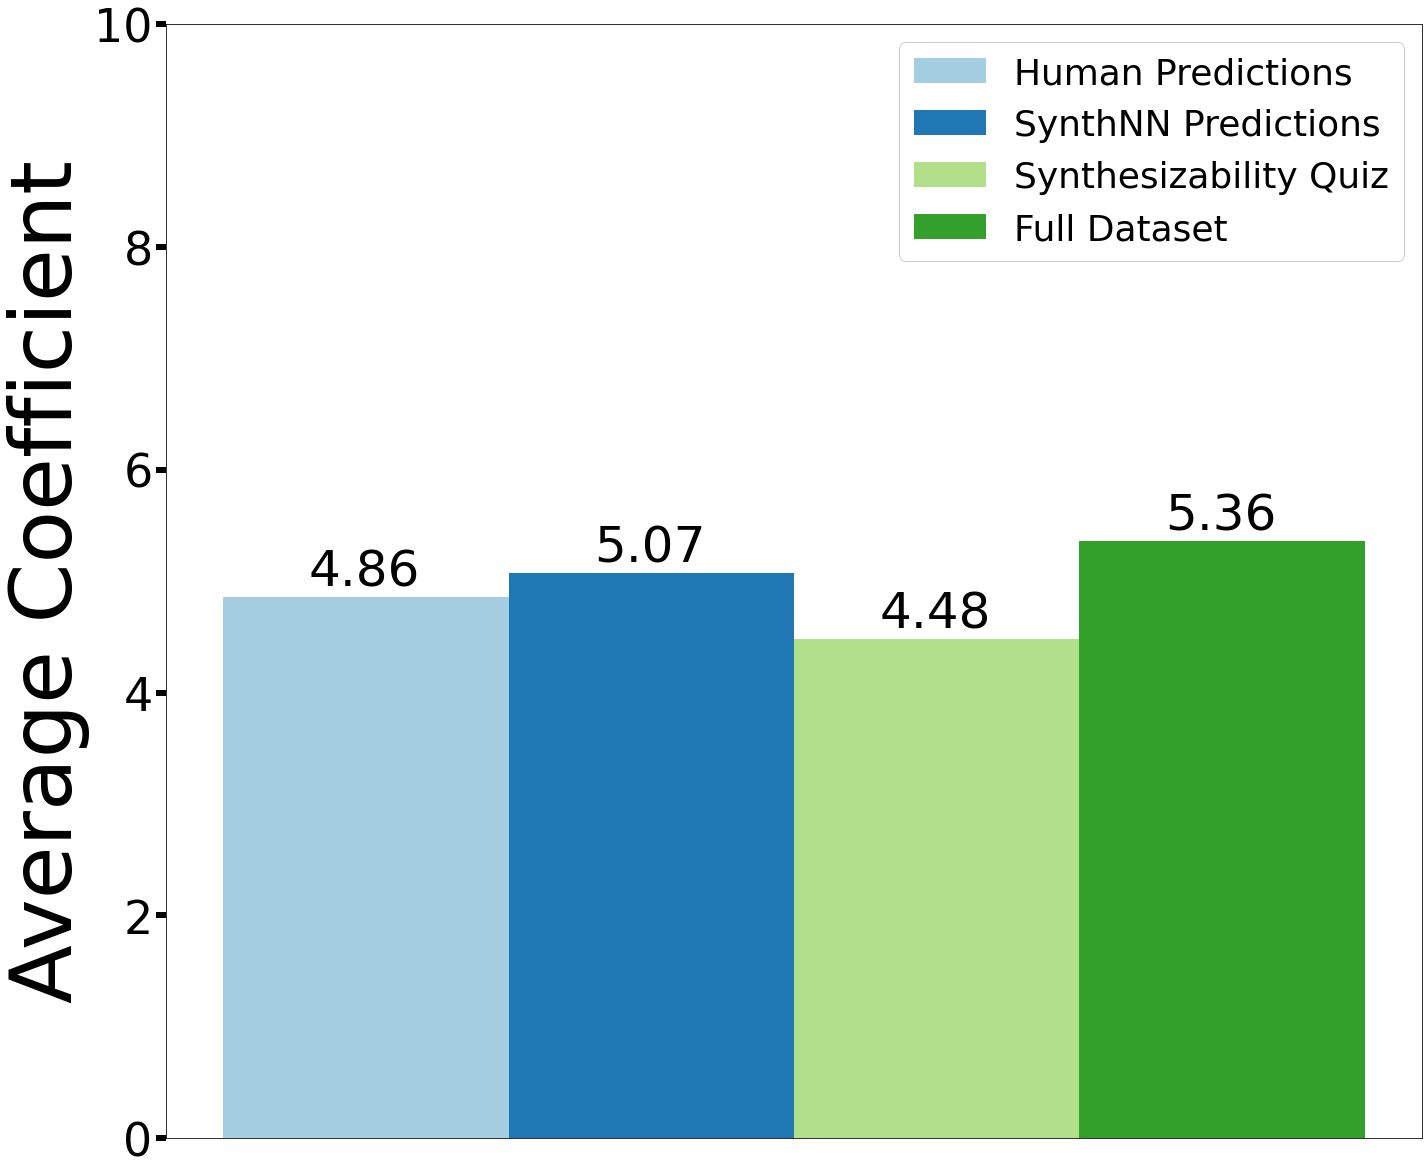

In [123]:
def get_average_coeff(data):
    coeffs=[]
    for entry in data:
        coeffs.append(np.mean(list(mg.core.Composition(entry).as_dict().values())))
    return np.mean(coeffs)

output=np.zeros(100)
formula_array=np.loadtxt('Figure_data/Figure_3/human_test_set.txt', dtype=str)
labels_array=np.loadtxt('Figure_data/Figure_3/human_test_set_labels.txt', dtype=int)
results=np.loadtxt('Figure_data/Figure_3/synthesizability_quiz_responses.txt', dtype=str, delimiter=';')

for j in range(len(results)):
    for i in range(len(results[j])):
        try:
            answer=int(results[j][i][0:3])
        except:
            try:
                answer=int(results[j][i][0:2])
            except:
                answer=int(results[j][i][0:1])
        output[answer-1]=output[answer-1]+1

#then plot this vs. avg coefficient
human_guess_array=[]
for i in range(len(output)):
    if(output[i]>0):
        for j in range(int(output[i])):
            human_guess_array.append(formula_array[i])


barWidth = 0.20
bars1=np.array([get_average_coeff(human_guess_array)])

#result for synthNN on synth quiz
x_quiz=get_features(formula_array)
dummy_y_values=np.zeros((len(formula_array),2))
synthNN_quiz_preds=SynthNN_best_model(x_quiz,dummy_y_values,formula_array)[:,0]
synthNN_formula_preds=formula_array[np.argsort(-synthNN_quiz_preds)[:9]]
bars2=np.array([get_average_coeff(synthNN_formula_preds)])
######

#average coeff of synth materials in quiz
bars3=np.array([get_average_coeff(formula_array[np.where(labels_array==1)[0]])]) 
########

#get average coeff of entire dataset (from above code)
bars4=np.loadtxt('Figure_data/Figure_s8/bars4.txt')
bars4=np.array(bars4,dtype=float)
#########

# Set position of bar on X axis
r1 = 1
r2 = 1.2
r3 = 1.4
r4 = 1.6

# Make the plot
plt.bar(r1, bars1, color='#a6cee3', width=barWidth,  label='Human Predictions')
plt.annotate(str(np.round(bars1[0], decimals=2)), [r1-(barWidth/5),bars1[0]+0.1], fontsize=50)

#make another bar for SynthNN predictions
plt.bar(r2, bars2, color='#1f78b4', width=barWidth, label='SynthNN Predictions') #Done on test set only!
plt.annotate(str(np.round(bars2[0], decimals=2)), [r2-(barWidth/5),bars2[0]+0.1], fontsize=50)

plt.bar(r3, bars3, color='#b2df8a', width=barWidth, label='Synthesizability Quiz')
plt.annotate(str(np.round(bars3[0], decimals=2)), [r3-(barWidth/5),bars3[0]+0.1], fontsize=50)

plt.bar(r4, bars4, color='#33a02c', width=barWidth, label='Full Dataset')
plt.annotate(str(np.round(bars4, decimals=2)), [r4-(barWidth/5),bars4+0.1], fontsize=50)

# Add xticks on the middle of the group bars
plt.xticks([r + (1.5*barWidth) for r in range(len(bars1))], ['Binary\nCompounds'], fontsize=56)
plt.yticks([0,2,4,6,8,10])
# Create legend & Show graphic
plt.legend(fontsize=36, framealpha=1)

plt.ylabel('Average Coefficient', fontsize=86)

plt.tick_params(axis='y', which='major', labelsize=46, width=6, length=10)
plt.tick_params(axis='x', which='major', labelsize=56, width=6, length=10)

plt.ylim(0,10)
fig = plt.gcf()
fig.set_size_inches(22.5, 20.5)
plt.show()

# Figure S9 Figure Plotting

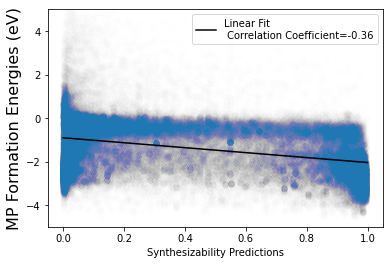

In [122]:
#form energy vs. synth preds 
form_energy_data=np.loadtxt('Figure_data/Figure_s9/MP_form_energies.txt',dtype=str,delimiter=',')
test_data=[]
form_energy_values=[]
for i in range(len(form_energy_data)):
    try:
        form_energy_values.append(float(form_energy_data[i][0]))#form energy
        test_data.append(form_energy_data[i][3])
        #ehull energy
    except:
        continue
x_data=get_features(test_data)
yval=np.zeros([len(x_data),2])
preds=SynthNN_best_model(x_data,yval,test_data)
plt.scatter(preds[:,0],form_energy_values,alpha=0.002)
#print(np.corrcoef(preds[:,0],form_energy_values))

corr_coeff=np.corrcoef(preds[:,0],form_energy_values)
plt.xlabel('Synthesizability Predictions')
plt.ylabel('MP Formation Energies (eV)', fontsize=16)
m, b = np.polyfit(preds[:,0], form_energy_values, 1)

y_fit=m*np.linspace(0,1) +b
plt.plot(np.linspace(0,1),y_fit, label='Linear Fit \n Correlation Coefficient=' + str(np.round(corr_coeff[0][1],decimals=2)),c='black')
plt.ylim(-5,5)
plt.legend()
plt.show()

# Figure S10 Figure Plotting

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


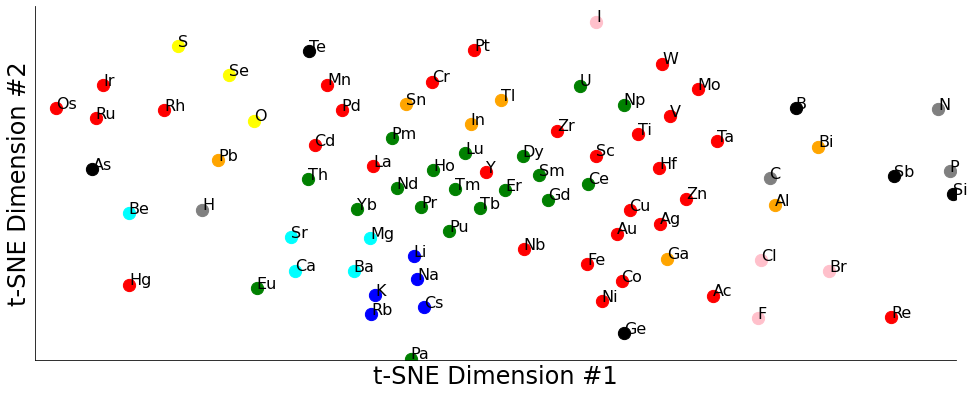

In [121]:
#visualizing t-sne embeddings
from sklearn.manifold import TSNE
import elements
element_names_array=['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl', 'Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn','Fr','Ra','Ac','Th','Pa','U','Np','Pu']
banned_elements=['Fr','He', 'Ne', 'Ar', 'Kr','Xe','Rn','Tc','Po','At','Rn','Ra']
data=np.loadtxt('Figure_data/Figure_s10/W1_30M_synth_v3_semi14112.txt',)
data = TSNE(n_components=2, random_state=0).fit_transform(data)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 6.5)
text_fontsize=24
scatter_size=150

for i in range(len(data)):
    symbol=element_names_array[i]
    if(mg.core.periodic_table.Element(symbol).row<10 and symbol not in banned_elements):
        if(mg.core.periodic_table.Element(symbol).is_noble_gas):
            plt.scatter(data[i,0], data[i,1],  c='purple',s=scatter_size)
            plt.annotate(symbol, data[i], fontsize=16)
        elif(mg.core.periodic_table.Element(symbol).is_transition_metal):
            plt.scatter(data[i,0], data[i,1],  c='red',s=scatter_size)
            plt.annotate(symbol, data[i], fontsize=16)
        elif(mg.core.periodic_table.Element(symbol).is_post_transition_metal):
            plt.scatter(data[i,0], data[i,1],  c='orange',s=scatter_size)
            plt.annotate(symbol, data[i], fontsize=16)
        elif(mg.core.periodic_table.Element(symbol).is_rare_earth_metal):
            plt.scatter(data[i,0], data[i,1],  c='green',s=scatter_size)
            plt.annotate(symbol, data[i], fontsize=16)
        elif(mg.core.periodic_table.Element(symbol).is_alkali):
            plt.scatter(data[i,0], data[i,1],  c='blue',s=scatter_size)
            plt.annotate(symbol, data[i], fontsize=16)
        elif(mg.core.periodic_table.Element(symbol).is_alkaline):
            plt.scatter(data[i,0], data[i,1],  c='cyan',s=scatter_size)
            plt.annotate(symbol, data[i], fontsize=16)
        elif(mg.core.periodic_table.Element(symbol).is_metalloid):
            plt.scatter(data[i,0], data[i,1], c='black',s=scatter_size)
            plt.annotate(symbol, data[i], fontsize=16)
        elif(mg.core.periodic_table.Element(symbol).is_halogen):
            plt.scatter(data[i,0], data[i,1],  c='pink',s=scatter_size)
            plt.annotate(symbol, data[i], fontsize=16)
        elif(mg.core.periodic_table.Element(symbol).is_chalcogen):
            plt.scatter(data[i,0], data[i,1],  c='yellow',s=scatter_size)
            plt.annotate(symbol, data[i], fontsize=16)
        else:
            plt.scatter(data[i,0], data[i,1],  c='gray',s=scatter_size)
            plt.annotate(symbol, data[i], fontsize=16)
            
plt.xlim(min(data[:,0]-1),max(data[:,0])+1)
plt.ylim(min(data[:,1]-1),max(data[:,1])+1)
plt.xlabel('t-SNE Dimension #1', fontsize=24)
plt.ylabel('t-SNE Dimension #2', fontsize=24)
#plt.scatter(-200,-20, label='Noble Gas', c='purple')
plt.scatter(-200,-20, label='Transition Metal', c='red')
plt.scatter(-200,-20, label='Post Transition Metal', c='orange')
plt.scatter(-200,-20, label='Rare Earth Metals', c='green')
plt.scatter(-200,-20,  label='Alkali', c='blue')
plt.scatter(-200,-20,label='Alkaline', c='cyan')
plt.scatter(-200,-20, label='Metalloid', c='black')
plt.scatter(-200,-20, label='Halogen', c='pink')
plt.scatter(-200,-20, label='Chalcogen', c='yellow')
plt.scatter(-200,-200, label='Other', c='gray')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#legend = plt.legend(loc="upper right", edgecolor="black",fontsize=24)
#legend.get_frame().set_alpha(None)
    
plt.show()

# Figure S11 data generation

In [10]:
#AUC Curves for charge-balanced/not charge-balanced (Figure S11)
data=np.loadtxt('decade_v4_train_set_charges.txt',dtype=str,delimiter='\t')
formulas=[]
labels=[]
charge_balanced_array=[]
for i in range(len(data)):
    formula=''
    if(i<150000):
        formula=data[i].split(' ')[0]
    else:
        formula=data[i].split("'")[1]
    if(len(Composition(formula))==2):
        formulas.append(formula)
        if(i<150000):
            label=int(float(data[i].split(' ')[1]))
            labels.append(label)
        else:
            label=int(float(data[i].split(',')[1].replace(' ','')))
            labels.append(label)

        charge_balanced='True' in data[i]
        charge_balanced_array.append(charge_balanced)
x_data=get_features(formulas)
yvalues=np.zeros((len(formulas),2))
for i in range(len(yvalues)):
    if labels[i]==1:
        yvalues[i,0]=1
    else:
        yvalues[i,1]=1
preds=SynthNN_best_model(x_data,yvalues,formulas)

#########
#get indices of formulas that are ionic/non-ionic
EN_array=[]
for i in range(len(formulas)):
    formula_dict=Composition(formulas[i]).as_dict()
    EN_temp_array=[]
    for key in formula_dict.keys():
        EN_temp_array.append(Element(key).X)
    EN_array.append(np.abs(EN_temp_array[0]-EN_temp_array[1]))
EN_array=np.array(EN_array)
ionic_indices=np.where(EN_array>1.7)[0]
nonionic_indices=np.where(EN_array<1.7)[0]
########

charge_balanced_binary=[]
precision_cb_array=[]
recall_cb_array=[]
for i in charge_balanced_array:
    if(i):
        charge_balanced_binary.append([1,0])
    else:
        charge_balanced_binary.append([0,1])

#do for ionics first    
ionic_precision_synthNN_array=[]
ionic_recall_synthNN_array=[]
ionic_precision_cb_array=[]
ionic_recall_cb_array=[]
for threshold in np.linspace(0.001,0.90,25):
    TP, FP, TN, FN=perf_measure(np.array(charge_balanced_binary)[:,0][ionic_indices],np.array(preds)[:,0][ionic_indices],threshold)
    print(TP,FP,TN,FN)
    ionic_precision_synthNN_array.append(TP/(TP+FP))
    ionic_recall_synthNN_array.append(TP/(TP+FN))
    
#nonionics
nonionic_precision_synthNN_array=[]
nonionic_recall_synthNN_array=[]
for threshold in np.linspace(0.001,0.95,25):
    TP, FP, TN, FN=perf_measure(np.array(charge_balanced_binary)[:,0][nonionic_indices],np.array(preds)[:,0][nonionic_indices],threshold)
    print(TP,FP,TN,FN)
    nonionic_precision_synthNN_array.append(TP/(TP+FP))
    nonionic_recall_synthNN_array.append(TP/(TP+FN))

np.savetxt('Figure_data/Figure_s11/ionic_precision_synthNN.txt',ionic_precision_synthNN_array)
np.savetxt('Figure_data/Figure_s11/ionic_recall_synthNN.txt',ionic_recall_synthNN_array)
np.savetxt('Figure_data/Figure_s11/nonionic_precision_synthNN.txt',nonionic_precision_synthNN_array)
np.savetxt('Figure_data/Figure_s11/nonionic_recall_synthNN.txt',nonionic_recall_synthNN_array)

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/opt/anaconda3/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:212: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:212: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:212: UserWarning: No electronegativity for 

230 13125 764 0
207 5201 8688 23
191 2918 10971 39
187 2145 11744 43
182 1629 12260 48
172 1346 12543 58
166 1129 12760 64
159 959 12930 71
151 801 13088 79
144 687 13202 86
140 593 13296 90
137 517 13372 93
128 446 13443 102
121 375 13514 109
110 328 13561 120
99 294 13595 131
91 252 13637 139
82 220 13669 148
78 181 13708 152
71 153 13736 159
62 136 13753 168
58 113 13776 172
52 78 13811 178
48 52 13837 182
37 38 13851 193
3600 129127 7341 43
1931 57643 78825 1712
1395 41141 95327 2248
1133 32145 104323 2510
978 25652 110816 2665
824 20781 115687 2819
720 17227 119241 2923
650 14288 122180 2993
588 11976 124492 3055
536 9788 126680 3107
474 8300 128168 3169
428 6922 129546 3215
390 5735 130733 3253
350 4664 131804 3293
316 3819 132649 3327
288 3029 133439 3355
253 2249 134219 3390
229 1749 134719 3414
212 1315 135153 3431
191 959 135509 3452
167 665 135803 3476
143 454 136014 3500
117 281 136187 3526
89 137 136331 3554
51 40 136428 3592


# Figure S11 Plotting

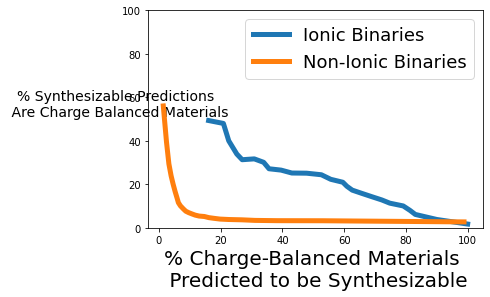

In [120]:
ionic_precision_synthNN_array=np.loadtxt('Figure_data/Figure_s11/ionic_precision_synthNN.txt')
ionic_recall_synthNN_array=np.loadtxt('Figure_data/Figure_s11/ionic_recall_synthNN.txt')
nonionic_precision_synthNN_array=np.loadtxt('Figure_data/Figure_s11/nonionic_precision_synthNN.txt')
nonionic_recall_synthNN_array=np.loadtxt('Figure_data/Figure_s11/nonionic_recall_synthNN.txt')

plt.plot(100*np.array(ionic_recall_synthNN_array),100*np.array(ionic_precision_synthNN_array),label='Ionic Binaries', linewidth=5)
plt.plot(100*np.array(nonionic_recall_synthNN_array),100*np.array(nonionic_precision_synthNN_array),label='Non-Ionic Binaries', linewidth=5)
plt.xlabel('% Charge-Balanced Materials \n Predicted to be Synthesizable',fontsize=20)
plt.ylabel('% Synthesizable Predictions \n Are Charge Balanced Materials',fontsize=14,rotation='horizontal')
plt.ylim(0,100)
plt.legend(fontsize=18)
plt.show()